# Reproduce the Results for the Public Datasets

Here, we report the code to reproduce the results reported in our work "GHOST: Adjusting the Decision Threshold to Handle Imbalanced Data in Machine Learning".

Especially, the code below allows to train four different machine learning classifiers (random forest, gradient boosting, XGBoost, and logistic regression) in combination with two different molecular descriptors (ECFP4 and RDKit2D). The models are trained on 138 public datasets, which are described and used in [this RDKit blog post](http://rdkit.blogspot.com/2018/11/working-with-unbalanced-data-part-i.html) by Gregory Landrum.

For a step by step execution and explanation of the code, see the tutorial `Tutorial_Threshold_Optimization_RF.ipynb`.

### Outlook

[Import Libraries](#section0) <br>

1. [Functions](#section1)

    1.1 [Functions to prepare the datasets and generate the fingerprints](#section1.1) <br>
    1.2 [Functions to calculate output metrics](#section1.2) <br>
    1.3 [Functions to optimize the decision threhold](#section1.3) <br>
    1.3.1 [Optimize the decision threshold using the prediction probabilities of the out-of-bag (oob) set](#section1.3.1) <br>
    1.3.2 [Generalized procedure to optimize the decision threshold](#section1.3.2) <br>
    1.4 [Functions to run other rebalancing approaches: RUS, SMOTE, and balanced random forest](#section1.4) <br>
    1.5 [Functions for Conformal Prediction](#section1.5) <br>
    1.6 [Function to run everything and store the results into an archive](#section1.6) <br>
    
    
2. [Run the code](#section2)

    2.1 [Set Parameters](#section2.1) <br>
    2.2 [Serotonin Datasets](#section2.2) <br>
    2.3 ["Dataset 1" (DS1) Datasets](#section2.3) <br>
    2.4 [PubChem Datasets](#section1.3.1) <br>
    2.5 [CHEMBL DrugMatrix Datasets](#section2.4) <br>
    
   
3. [Plot Results](#section3)<br>

<a id='section0'></a>

### Import Libraries

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem
from rdkit import SimDivFilters
from rdkit.Chem.MolStandardize import rdMolStandardize

from collections import defaultdict
import pandas as pd
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator

In [2]:
# only print out critical error messages of rdkit
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


In [3]:
from sklearn.model_selection import train_test_split
import sklearn
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from imblearn.ensemble import BalancedRandomForestClassifier


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6

<a id='section1'></a>

# 1. Functions

<a id='section1.1'></a>

### 1.1 Functions to prepare the datasets and generate the fingerprints

In [4]:
# Remove counterions: Take the largest organic fragment
def salt_remover(smiles):
    rmv = rdMolStandardize.LargestFragmentChooser(preferOrganic = True)
    cleaned_smiles = []
    for smi in smiles:
        if "." in smi:
            smi_new = Chem.MolToSmiles(rmv.choose(Chem.MolFromSmiles(smi)))
            cleaned_smiles.append(smi_new)
        else:
            cleaned_smiles.append(smi)
    return cleaned_smiles



# Compute the ECFP4 fingerprint with 2048 bits
def add_MorganFP(acts):
    act_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in acts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        act_data.append(bv)
    acts['MorganFP'] = act_data
    return(acts)


# Compute the RDKit2D fingerprint (200 topological properties) using the descriptastorus library
def add_rdkit2d(acts, smiles_column = 'canonical_smiles'):
    if smiles_column not in list(acts):
        print("Error: the column {} is not contained in the input dataframe. A column containing SMILES is required to calculate property-based fingerprints".format(smiles_column))
        return(acts)
    acts[smiles_column] = acts[smiles_column].astype(str)
    rdkit2d = []
    generator = MakeGenerator(("RDKit2D",))
    for n, smi in enumerate(acts[smiles_column]):
        try:
            data = generator.process(smi)
            if data[0] == True:
                data.pop(0)
            if data[0] == False:
                data.pop(0)
            data = np.float32(data)
            data[np.isposinf(data)] = np.finfo('float32').max
            data[np.isneginf(data)] = np.finfo('float32').min
            data = np.nan_to_num(data)
            rdkit2d.append(list(data))
        except:
            rdkit2d.append([0]*200)
            print("Error: RDKit2D not generated for {}".format(acts['compound_chembl_id'][n]))
    acts['RDKit2D'] = rdkit2d
    return(acts)


def gen_fps(acts,inacts, descriptor = 'MorganFP'):
    # generate fingerprints for the actives and inactives and convert them to numpy arrays so that
    # we can learn from them. This uses the generalized fingerprinter added in the RDKit 2018.09 release
    labels_column = 'labels'
    if descriptor == 'RDKit2D':
        acts = add_rdkit2d(acts)
        inacts = add_rdkit2d(inacts)
    if descriptor == 'MorganFP':
        acts = add_MorganFP(acts)
        inacts = add_MorganFP(inacts)
    acts[labels_column] = 1
    inacts[labels_column] = 0
    df_dataset = pd.concat((acts, inacts))
    df_dataset.reset_index(inplace = True, drop = True)
    # exclude the compounds for which RDKit2D could not be completely calculated
    if descriptor == 'RDKit2D':
        check_idx = [i for i,a in enumerate(list(df_dataset[descriptor])) if len(a) != 200]
        df_dataset.drop(check_idx, inplace=True) 
    return df_dataset



<a id='section1.2'></a>

### 1.2 Function to calculate output metrics

In [5]:
def calc_metrics(labels_test, test_probs, threshold = 0.5):
    scores = [1 if x>=threshold else 0 for x in test_probs]
    auc = metrics.roc_auc_score(labels_test, test_probs)
    kappa = metrics.cohen_kappa_score(labels_test,scores)
    confusion = metrics.confusion_matrix(labels_test,scores, labels=list(set(labels_test)))
    print('thresh: %.2f, kappa: %.3f, AUC test-set: %.3f'%(threshold, kappa, auc))
    print(confusion)
    print(metrics.classification_report(labels_test,scores))
    return kappa, confusion, auc



<a id='section1.3'></a>

### 1.3 Functions to optimize the decision threhold

<a id='section1.3.1'></a>
#### 1.3.1 Optimize the decision threshold using the prediction probabilities of the out-of-bag (oob) set 
This approach has been described [here](http://rdkit.blogspot.com/2018/11/working-with-unbalanced-data-part-i.html) and can only be used for the random forest classifier.

The function below requires as input:
- `oob_probs`: the oob active prediction probabilities, which can be extracted from the trained RF model (cls) as 

        oob_probs = cls.oob_decision_function_
        oob_probs = [x[1] for x in oob_probs]
        
- `labels_train`: the true labels of the training set 
- `thresholds`: list a thresholds (e.g. [0.1, 0.2, 0.3, 0.4, 0.5])

To optmize the decision threshold, one can use different metrics. 
Here, you can select `ThOpt_metrics = 'Kappa'`, `'ROC'`, or `'ROC_Song14'`.

With, `ThOpt_metrics = 'Kappa'`, the Cohen's Kappa is calculated for the oob set and a range of thresholds (specified using the threshold argument). The optimal threshold (returned) is the one that maximizes the Cohen's Kappa.

The threshold optimization based on the ROC curve is described [here](https://doi.org/10.1007/s11548-013-0913-8). With, `ThOpt_metrics = 'ROC'`, sensitivity and specificity are calculated for a range of thresholds using the roc_curve function of scikit-learn. The optimal threshold (returned) is the one that minimizes the distance to the [0,1] corner of the ROC plot. 

In [6]:
def run_it_oob_optimization(oob_probs, labels_train, thresholds, ThOpt_metrics = 'Kappa'):
    """Optimize the decision threshold based on the prediction probabilities of the out-of-bag set of random forest.
    The threshold that maximizes the Cohen's kappa coefficient or a ROC-based criterion 
    on the out-of-bag set is chosen as optimal.
    
    Parameters
    ----------
    oob_probs : list of floats
        Positive prediction probabilities for the out-of-bag set of a trained random forest model
    labels_train: list of int
        True labels for the training set
    thresholds: list of floats
        List of decision thresholds to screen for classification
    ThOpt_metrics: str
        Optimization metric. Choose between "Kappa" and "ROC"
        
    Returns
    ----------
    thresh: float
        Optimal decision threshold for classification
    """

    # Optmize the decision threshold based on the Cohen's Kappa coefficient
    if ThOpt_metrics == 'Kappa':
        tscores = []
        # evaluate the score on the oob using different thresholds
        for thresh in thresholds:
            scores = [1 if x>=thresh else 0 for x in oob_probs]
            kappa = metrics.cohen_kappa_score(labels_train,scores)
            tscores.append((np.round(kappa,3),thresh))
        # select the threshold providing the highest kappa score as optimal
        tscores.sort(reverse=True)
        thresh = tscores[0][-1]
    # Optmize the decision threshold based on the ROC-curve
    elif ThOpt_metrics == 'ROC':
        # ROC optimization with thresholds determined by the roc_curve function of sklearn
        fpr, tpr, thresholds_roc = metrics.roc_curve(labels_train, oob_probs, pos_label=1)
        specificity = 1-fpr
        roc_dist_01corner = (2*tpr*specificity)/(tpr+specificity)
        thresh = thresholds_roc[np.argmax(roc_dist_01corner)]
    return thresh



<a id='section1.3.2'></a>

#### 1.3.2 GHOST: Generalized procedure to optimize the decision threshold
The function below utilizes the prediction probabilities of N training subsets (`N_subsets`) to optimize the classification threshold. The subsets can be drawn with or without replacement (`with_replacement`). The subset size can be selected using the `subset_size` argument (default = 0.2), which, if float, represents the proportion of the dataset to include in the subset. If integer, it represents the actual number of instances to include in the subset. As for the previous function, two optimization metrics are available `ThOpt_metrics = 'Kappa'` or `ThOpt_metrics = 'ROC'`.

Required inputs are:
- `cls`: trained classification model
- `fps_train`: numpy array of descriptors of the training set
- `labels_train`: list of true labels for the training set
- `thresholds`: list a thresholds (e.g. [0.1, 0.2, 0.3, 0.4, 0.5])


In [7]:
def optimize_threshold_train_subset(cls, fps_train, labels_train, thresholds, 
                                    ThOpt_metrics = 'Kappa', N_subsets = 100, 
                                    subsets_size = 0.2, with_replacement = False, random_seed = None):

    """Optimize the decision threshold based on subsets of the training set.
    The threshold that maximizes the Cohen's kappa coefficient or a ROC-based criterion 
    on the training subsets is chosen as optimal.
    
    Parameters
    ----------
    cls : obj
        Trained machine learning classifier built using scikit-learn
    fps_train: list 
        Molecular descriptors for the training set
    labels_train: list of int
        True labels for the training set
    thresholds: list of floats
        List of decision thresholds to screen for classification
    ThOpt_metrics: str
        Optimization metric. Choose between "Kappa" and "ROC"
    N_subsets: int
        Number of training subsets to use in the optimization
    subsets_size: float or int
        Size of the subsets. if float, represents the proportion of the dataset to include in the subsets. 
        If integer, it represents the actual number of instances to include in the subsets. 
    with_replacement: bool
        The subsets are drawn randomly. True to draw the subsets with replacement
    random_seed: int    
        random number to seed the drawing of the subsets
    
    Returns
    ----------
    thresh: float
        Optimal decision threshold for classification
    """
    
    # seeding
    np.random.seed(random_seed)
    random_seeds = np.random.randint(N_subsets*10, size=N_subsets)  
    
    # calculate prediction probability for the training set
    probs_train = cls.predict_proba(fps_train)[:,1]
    labels_train_thresh = {'labels': labels_train}
    labels_train_thresh.update({'probs': probs_train})
    # recalculate the predictions for the training set using different thresholds and
    # store the predictions in a dataframe
    for thresh in thresholds:
        labels_train_thresh.update({str(thresh): [1 if x >= thresh else 0 for x in probs_train]})
    df_preds = pd.DataFrame(labels_train_thresh)
    # Optmize the decision threshold based on the Cohen's Kappa coefficient
    if ThOpt_metrics == 'Kappa':
        # pick N_subsets training subsets and determine the threshold that provides the highest kappa on each 
        # of the subsets
        kappa_accum = []
        for i in range(N_subsets):
            if with_replacement:
                if isinstance(subsets_size, float):
                    Nsamples = int(df_preds.shape[0]*subsets_size)
                elif isinstance(subsets_size, int):
                    Nsamples = subsets_size                    
                df_subset = resample(df_preds, n_samples = Nsamples, stratify=list(df_preds.labels), random_state = random_seeds[i])
                labels_subset = df_subset['labels']
            else:
                df_tmp, df_subset, labels_tmp, labels_subset = train_test_split(df_preds, labels_train, test_size = subsets_size, stratify = labels_train, random_state = random_seeds[i])
            probs_subset = list(df_subset['probs'])
            thresh_names = [x for x in df_preds.columns if (x != 'labels' and x != 'probs')]
            kappa_train_subset = []
            for col1 in thresh_names:
                kappa_train_subset.append(metrics.cohen_kappa_score(labels_subset, list(df_subset[col1])))
            kappa_accum.append(kappa_train_subset)
        # determine the threshold that provides the best results on the training subsets
        y_values_median, y_values_std = helper_calc_median_std(kappa_accum)
        opt_thresh = thresholds[np.argmax(y_values_median)]
    # Optmize the decision threshold based on the ROC-curve, as described here https://doi.org/10.1007/s11548-013-0913-8
    elif ThOpt_metrics == 'ROC':
        sensitivity_accum = []
        specificity_accum = []
        # Calculate sensitivity and specificity for a range of thresholds and N_subsets
        for i in range(N_subsets):
            if with_replacement:
                if isinstance(subsets_size, float):
                    Nsamples = int(df_preds.shape[0]*subsets_size)
                elif isinstance(subsets_size, int):
                    Nsamples = subsets_size                    
                df_subset = resample(df_preds, n_samples = Nsamples, stratify=list(df_preds.labels), random_state = random_seeds[i])
                labels_subset = list(df_subset['labels'])
            else:
                df_tmp, df_subset, labels_tmp, labels_subset = train_test_split(df_preds, labels_train, test_size = subsets_size, stratify = labels_train, random_state = random_seeds[i])
            probs_subset = list(df_subset['probs'])
            sensitivity = []
            specificity = []
            for thresh in thresholds:
                scores = [1 if x >= thresh else 0 for x in probs_subset]
                tn, fp, fn, tp = metrics.confusion_matrix(labels_subset, scores, labels=list(set(labels_train))).ravel()
                sensitivity.append(tp/(tp+fn))
                specificity.append(tn/(tn+fp))
            sensitivity_accum.append(sensitivity)
            specificity_accum.append(specificity)
        # determine the threshold that provides the best results on the training subsets
        median_sensitivity, std_sensitivity = helper_calc_median_std(sensitivity_accum)
        median_specificity, std_specificity = helper_calc_median_std(specificity_accum)
        roc_dist_01corner = (2*median_sensitivity*median_specificity)/(median_sensitivity+median_specificity)
        opt_thresh = thresholds[np.argmax(roc_dist_01corner)]
    return opt_thresh


def helper_calc_median_std(specificity):
    # Calculate median and std of the columns of a pandas dataframe
    arr = np.array(specificity)
    y_values_median = np.median(arr,axis=0)
    y_values_std = np.std(arr,axis=0)
    return y_values_median, y_values_std    





<a id='section1.4'></a>

### 1.4 Functions to run other rebalancing approaches: RUS, SMOTE, and balanced random forest

Functions implemented in the [imbalanced-learn](https://imbalanced-learn.org/stable/index.html) library are used.

In [8]:
def run_smote(fps_train, fps_test, labels_train, labels_test, method = "RF", **kwargs):
    # resample the training set
    oversample = SMOTE()
    fps_train_os, labels_train_os = oversample.fit_resample(fps_train, labels_train)
    
    # build the classification model:
    if method  == 'RF':
        cls = RandomForestClassifier(n_estimators = 500, max_depth = 15, min_samples_leaf = 2,oob_score = True,
                                     n_jobs=4, **kwargs)
    elif method == 'GB':
        cls = GradientBoostingClassifier(n_estimators = 100, validation_fraction = 0.2, n_iter_no_change = 10, 
                                         tol = 0.01, **kwargs)
    elif method == 'XGB':
        cls = xgb.XGBClassifier(n_estimators = 100, **kwargs)

    elif method == 'LR':
        cls = LogisticRegression(**kwargs)
    
    if method == 'XGB':
        cls.fit(fps_train_os, labels_train_os, early_stopping_rounds=10, eval_metric="error", 
                eval_set=[(fps_train_os, labels_train_os)])
    else:
        cls.fit(fps_train_os, labels_train_os)

    probs = cls.predict_proba(fps_test)[:,1]
    return cls, probs 


def run_random_undersampling(fps_train, fps_test, labels_train, labels_test, method = "RF", **kwargs):
    # resample the training set
    rus = RandomUnderSampler()
    fps_train_rus, labels_train_rus = rus.fit_resample(fps_train, labels_train)
    
    # build the classification model:
    if method  == 'RF':
        cls = RandomForestClassifier(n_estimators = 500, max_depth = 15, min_samples_leaf = 2,oob_score = True,
                                     n_jobs=4, **kwargs)
    elif method == 'GB':
        cls = GradientBoostingClassifier(n_estimators = 100, validation_fraction = 0.2, n_iter_no_change = 10, 
                                         tol = 0.01, **kwargs)
    elif method == 'XGB':
        cls = xgb.XGBClassifier(n_estimators = 100, **kwargs)
        
    elif method == 'LR':
        cls = LogisticRegression(**kwargs)
    
    if method == 'XGB':
        cls.fit(fps_train_rus, labels_train_rus, early_stopping_rounds=10, eval_metric="error", 
                eval_set=[(fps_train_rus, labels_train_rus)])
    else:
        cls.fit(fps_train_rus, labels_train_rus)

    probs = cls.predict_proba(fps_test)[:,1]
    return cls, probs 


def run_balancedRF(fps_train, fps_test, labels_train, labels_test, **kwargs):
    # build the classification model:
    cls = BalancedRandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4, **kwargs)
    cls.fit(fps_train, labels_train)
    probs = cls.predict_proba(fps_test)[:,1]
    return cls, probs 
    

<a id='section1.5'></a>

### 1.5 Functions for Conformal Prediction

The [nonconformist](https://github.com/donlnz/nonconformist) library is used. The functions below were adapted from the [code](https://github.com/volkamerlab/knowtox_manuscript_SI) of the Volkamer lab (see also [this Ref](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00422-x)).

In [9]:
from nonconformist.icp import IcpClassifier
from nonconformist.nc import InverseProbabilityErrFunc, NcFactory
from nonconformist.acp import AggregatedCp, RandomSubSampler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold

# function to train ML model and calibrate cross-validation ACP conformal predictor.
# Within each loop of a fivefold cross-validation, an ACP with 25 loops was generated. 
# In each ACP loop, training data was split into 70% proper training and 30% calibration data
def run_acp(fps, labels, cv_folds = 5, nc_normalization = True, N_acp_models = 25, 
            error_function = None, icp_classifier_condition = None, aggregation_function = None,
            random_seed = None, mol_names = None, **kwargs):
    
    # DEFAULT PARAMETERS FOR CP
    # error function
    if error_function == None:
        error_function = InverseProbabilityErrFunc()
    # ICP
    if icp_classifier_condition == None:
        icp_classifier_condition = (lambda instance: instance[1]) # Mondrian condition in conformal prediction
    # aggregation
    if aggregation_function == None:
        aggregation_function = (lambda x: np.median(x,axis=2)) # Function to aggregate p-values in ACP

    # Split data for crossvalidation
    kf = StratifiedKFold(n_splits=cv_folds, random_state=random_seed, shuffle=True)
    acps_cv = [] # Save all ACPs to use for further prediction
    
    # Define parameters for choosen CP model set-up: 
    # - acp_option: how to split the data into training and calibration set for each acp loop
    # - normaliser_model = True: normalize the nonconformity score by training a KNeighborsRegressor model
    if nc_normalization == False:
        normaliser_model = None
        acp_option = RandomSubSampler() #stratified random split. default calibration proportion 0.3
    elif nc_normalization == True:
        normaliser_model = KNeighborsRegressor()
        acp_option = RandomSubSampler() #stratified random split. default calibration proportion 0.3 

    # Fit model within crossvalidation and make prediction for respective calibration set
    df_output = pd.DataFrame()
    for train_index, calib_index in kf.split(fps, labels):
        # Prepare the data splits
        X_train, X_calib = fps[train_index], fps[calib_index]
        y_train, y_calib = labels[train_index], labels[calib_index]

        # train model on training set
        if method  == 'RF':
            cls = RandomForestClassifier(n_estimators = 500, max_depth = 15, min_samples_leaf = 2,oob_score = True,
                                         n_jobs=4, **kwargs)
        elif method == 'GB':
            cls = GradientBoostingClassifier(n_estimators = 100, validation_fraction = 0.2, n_iter_no_change = 10, 
                                             tol = 0.01, **kwargs)
        elif method == 'XGB':
            cls = xgb.XGBClassifier(n_estimators = 100, **kwargs)

        elif method == 'LR':
            cls = LogisticRegression(**kwargs)

        nc = NcFactory.create_nc(cls, err_func=error_function, normalizer_model=normaliser_model)
        icp = IcpClassifier(nc, condition=icp_classifier_condition)
        acp = AggregatedCp(n_models=N_acp_models, predictor=icp, sampler=acp_option,
                           aggregation_func=aggregation_function)
        acp.fit(X_train, y_train)
        acps_cv.append(acp)
        
        # Make predictions for calibration set
        predictions = acp.predict(X_calib)

        # Write p-values and further compound information for each split into output dataframe
        df_output_tmp = pd.DataFrame({'p0': list(predictions[:,0]), 'p1': list(predictions[:,1]), 
                                      'prediction': list(predictions), 'y_true': list(y_calib)})
        
        if isinstance(mol_names, (list,np.ndarray)) and len(mol_names) == len(labels):
            if isinstance(mol_names, list):
                mol_names = np.array(mol_names)
            mol_names_train, mol_names_calib = mol_names[train_index], mol_names[calib_index]
            df_output_tmp["mol_names"] = list(mol_names_calib)
            
        df_output = pd.concat((df_output, df_output_tmp))
    # save to csv file  
    #df_output.to_csv('conformal_predictions_calibration.csv', index = False)
    return acps_cv, df_output



def predict_acp_get_pvalues(acps_cv, fps_test, labels_test, mol_names = None):
    """
    Make conformal predictions for external test data and save p-values to dataframe
    """
    predict_df = pd.DataFrame()

    # With each of the ACPs trained in CV
    predictions_p0 = pd.DataFrame()
    predictions_p1 = pd.DataFrame()

    for i, a in enumerate(acps_cv):
        p = a.predict(fps_test)
        predictions_p0[i] = list(p[:,0])
        predictions_p1[i] = list(p[:,1])

    predict_df['p0'] = list(predictions_p0.median(axis=1))
    predict_df['p1'] = list(predictions_p1.median(axis=1))
    predict_df['y_true'] = list(labels_test)
    if mol_names != None and len(mol_names) == len(labels_test):
        predict_df['mol_names'] = list(mol_names)
        
    # save to csv file    
    #predict_df.to_csv('conformal_predictions_test.csv')
    return predict_df



#### 1.5.1 Evaluate conformal predictor <a name="evaluate-conformal-predictors"></a>

#### Define evaluation functions to calculate validity, efficiency, accuracy_rate, and accuracy
**Efficiency** = fraction of single class predictions, ignoring whether they are correct or not <br>
**Validity** = fraction of correct prediction, including uncertain (multi, [0,1]) predictions<br>
**Accuracy rate** = ratio between the number of correct single class predictions and the total number of single class predictions<br>
**Accuracy** = ratio between the number of correct single class predictions and the total number of predictions

In [10]:
def check_counts_rows(counts):
    if '0' not in list(counts.index):
        counts.loc['0'] = [0.0] * counts.shape[1]
    if '1' not in list(counts.index):
        counts.loc['1'] = [0.0] * counts.shape[1]
    if '[0,1]' not in list(counts.index):
        counts.loc['[0,1]'] = [0.0] * counts.shape[1]
    if '[,]' not in list(counts.index):
        counts.loc['[,]'] = [0.0] * counts.shape[1]
    return(counts)

def calc_CP_performance(predict_df, labels_column = 'y_true', significance_levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]):
    pd.options.mode.chained_assignment = None  # default='warn'
    for significance_level in significance_levels:
        predict_df['y_pred_{}'.format(significance_level)] = np.nan
        predict_df['y_pred_{}'.format(significance_level)][(predict_df['p0'] >= significance_level) & (predict_df['p1'] < significance_level)] = '0'
        predict_df['y_pred_{}'.format(significance_level)][(predict_df['p1'] >= significance_level) & (predict_df['p0'] < significance_level)] = '1'
        predict_df['y_pred_{}'.format(significance_level)][(predict_df['p0'] >= significance_level) & (predict_df['p1'] >= significance_level)] = '[0,1]'
        predict_df['y_pred_{}'.format(significance_level)][(predict_df['p0'] < significance_level) & (predict_df['p1'] < significance_level)] = '[,]'
    # Calculate metrics: efficiency, validity, accuracy_rate, and accuracy
    metrics_dict = {}
    metrics_dict['significance_level'] = significance_levels
    predict_df0 = predict_df.loc[predict_df['y_true'] == 0]
    predict_df1 = predict_df.loc[predict_df['y_true'] == 1]
    counts = predict_df[[s for s in list(predict_df.columns) if 'y_pred' in s]].apply(pd.Series.value_counts).fillna(0)
    counts_0 = predict_df0[[s for s in list(predict_df0.columns) if 'y_pred' in s]].apply(pd.Series.value_counts).fillna(0)
    counts_1 = predict_df1[[s for s in list(predict_df1.columns) if 'y_pred' in s]].apply(pd.Series.value_counts).fillna(0)
    counts = check_counts_rows(counts)
    counts_0 = check_counts_rows(counts_0)
    counts_1 = check_counts_rows(counts_1)
    if len(list(set(counts_0.sum()))) == 1 and len(list(set(counts_1.sum()))) == 1:
        metrics_dict['efficiency_0'] = (np.array(counts_0.loc['0']) + np.array(counts_0.loc['1']))/int(list(set(counts_0.sum()))[0])
        metrics_dict['efficiency_1'] = (np.array(counts_1.loc['0']) + np.array(counts_1.loc['1']))/int(list(set(counts_1.sum()))[0])
        metrics_dict['efficiency'] = (np.array(counts.loc['0']) + np.array(counts.loc['1']))/int(list(set(counts.sum()))[0])
        metrics_dict['validity_0'] = (np.array(counts_0.loc['0']) + np.array(counts_0.loc['[0,1]']))/int(list(set(counts_0.sum()))[0])
        metrics_dict['validity_1'] = (np.array(counts_1.loc['1']) + np.array(counts_1.loc['[0,1]']))/int(list(set(counts_1.sum()))[0])
        metrics_dict['validity'] = (np.array(counts_0.loc['0']) + np.array(counts_1.loc['1']) + np.array(counts.loc['[0,1]']))/int(list(set(counts.sum()))[0])
        metrics_dict['accuracy_rate_0'] = np.array(counts_0.loc['0'])/(np.array(counts_0.loc['0']) + np.array(counts_0.loc['1']))
        metrics_dict['accuracy_rate_1'] = np.array(counts_1.loc['1'])/(np.array(counts_1.loc['0']) + np.array(counts_1.loc['1']))
        metrics_dict['accuracy_rate'] = (np.array(counts_0.loc['0']) + np.array(counts_1.loc['1']))/(np.array(counts.loc['0']) + np.array(counts.loc['1']))
        metrics_dict['accuracy_0'] = np.array(counts_0.loc['0'])/predict_df0.shape[0]
        metrics_dict['accuracy_1'] = np.array(counts_1.loc['1'])/predict_df1.shape[0]
        metrics_dict['accuracy'] = (np.array(counts_0.loc['0']) + np.array(counts_1.loc['1']))/predict_df.shape[0]
    else:
        print('Error: There must be an error in the countings. \nThere are different number of predictions for the different significance levels')

    df_metrics = pd.DataFrame(metrics_dict)    
    return predict_df, df_metrics



Plot results of conformal prediction:

In [11]:
def plot_cp_results(predict_df, df_metrics, output_name = "test"):
    fig, axs = plt.subplots(2, 1, figsize = (6,8))
    fig.subplots_adjust(hspace=0.3)
    # plot validity and efficiency vs significance (error rate)
    axs[0].plot(df_metrics.significance_level, df_metrics.efficiency_0, c = 'red', label = 'efficiency_0')
    axs[0].plot(df_metrics.significance_level, df_metrics.efficiency_1, c = 'orange', label = 'efficiency_1')
    axs[0].plot(df_metrics.significance_level, df_metrics.validity_0, c = 'navy', label = 'validity_0')
    axs[0].plot(df_metrics.significance_level, df_metrics.validity_1, c = 'deepskyblue', label = 'validity_1')
    axs[0].set_ylabel("Metric", fontsize = 20)
    axs[0].set_xlabel("ACP Significance", fontsize = 20)
    axs[0].legend(loc='upper center', bbox_to_anchor=(1.25, 1), fontsize = 16, ncol = 1)
    axs[0].tick_params(labelsize = 16)
    # bar plot of predictions
    counts = predict_df[[s for s in list(predict_df.columns) if 'y_pred' in s]].apply(pd.Series.value_counts).fillna(0)
    counts.columns = [s.replace('y_pred_','') for s in counts.columns]
    counts.T.plot(kind="bar", ax=axs[1])
    axs[1].set_ylabel("N. of predictions", fontsize = 20)
    axs[1].set_xlabel("ACP Significance", fontsize = 20)
    axs[1].legend(loc='upper center', bbox_to_anchor=(1.17, 1), fontsize = 16, ncol = 1)
    axs[1].tick_params(labelsize = 16)
    plt.savefig("./figures/CP_results_{}.png".format(output_name), dpi=600, bbox_inches='tight')


<a id='section1.6'></a>

### 1.6 Function to run everything and store the results into an archive

In [12]:
def run_it_(assay_id, acts, inacts, archive, descriptor = 'MorganFP', method = "RF", scale_features = False, 
            test_set_size = 0.2, random_seed = None, 
            opt_oob = False, ThOpt_metrics = 'Kappa', thresholds = None, N_subsets = None, 
            subsets_size = None, with_replacement = False, try_resampling = True, try_brf = False, 
            try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25, **kwargs):
    
    # clean data:
    acts['canonical_smiles'] = salt_remover(acts['canonical_smiles'])
    inacts['canonical_smiles'] = salt_remover(inacts['canonical_smiles'])
    
    # generate descriptors and split the data into a training and test set:
    df_dataset = gen_fps(acts,inacts, descriptor = descriptor)

    # return fps and true labels
    labels = np.array(list(df_dataset['labels']))
    fps = np.array(df_dataset[descriptor])
    fps = np.stack(fps, axis = 0)
     # retrieve compound IDs
    mol_names = list(df_dataset['compound_chembl_id']) 
    
    # scale features:
    if scale_features:
        scaler = StandardScaler()
        fps = scaler.fit_transform(fps)

    # train - test split
    fps_train, fps_test, labels_train, labels_test, names_train, names_test = train_test_split(fps, labels, mol_names, 
                                                                      test_size = test_set_size, 
                                                                      stratify = labels, random_state = random_seed)
    # train classifier
    print("--------- Default -----------")
    if method  == 'RF':
        cls = RandomForestClassifier(n_estimators = 500, max_depth = 15, min_samples_leaf = 2,oob_score = True,
                                     n_jobs=4, **kwargs)
    elif method == 'GB':
        cls = GradientBoostingClassifier(n_estimators = 100, validation_fraction = 0.2, n_iter_no_change = 10, 
                                         tol = 0.01, **kwargs)
    elif method == 'XGB':
        cls = xgb.XGBClassifier(n_estimators = 100, **kwargs)
        
    elif method == 'LR':
        cls = LogisticRegression(**kwargs)
    
    if method == 'XGB':
        cls.fit(fps_train, labels_train, early_stopping_rounds=10, eval_metric="error", 
                eval_set=[(fps_train, labels_train)])
    else:
        cls.fit(fps_train, labels_train)

    # predict the test set
    test_probs = cls.predict_proba(fps_test)[:,1] #prediction probabilities for the test set
    #store predictions in dataframe
    scores = [1 if x>=0.5 else 0 for x in test_probs]
    df_preds = pd.DataFrame({'mol_names': names_test, 'y_true': labels_test, 'standard': scores})
   
    # generate and show some evaluation stats for the model on the test data:
    kappa, confusion, auc = calc_metrics(labels_test, test_probs, threshold = 0.5)
    archive[assay_id].append(('standard',0.5,kappa,confusion,auc))
    
    # Optimize decision threshold
    print("--------- Balanced -----------")
    if thresholds is None:
        # pick the best threshold using the OOB kappas
        thresholds = np.round(np.arange(0.05,0.55,0.05),2)
        
    # optimize the decision thresholds based on the prediction probabilities of the oob set
    # Can only be used for random forest
    if opt_oob == True and method == 'RF':
        print("--------- Balanced Oob -----------")
        # extract oob probabilities
        oob_probs = cls.oob_decision_function_
        oob_probs = [x[1] for x in oob_probs]
        oob_auc = metrics.roc_auc_score(labels_train, oob_probs)
        # optimize threshold
        thresh_oob = run_it_oob_optimization(oob_probs, labels_train, thresholds, ThOpt_metrics = ThOpt_metrics)  
        # calculate metrics using the optimized decision threshold
        kappa, confusion, auc_tmp = calc_metrics(labels_test, test_probs, threshold = thresh_oob)
        archive[assay_id].append(('OobOpt',thresh_oob,kappa,confusion,oob_auc))
        #store predictions in dataframe
        scores = [1 if x>=thresh_oob else 0 for x in test_probs]
        df_preds['OobOpt'] = scores
        
    print("--------- Balanced Subsets -----------")
    # optimize the decision thresholds based on the prediction probabilities of N training subsets
    # Can be used for every machine learning model
    thresh_sub = optimize_threshold_train_subset(cls, fps_train, labels_train, thresholds,
                                                              ThOpt_metrics = ThOpt_metrics, 
                                                              N_subsets = N_subsets, subsets_size = subsets_size, 
                                                              with_replacement = with_replacement, random_seed = random_seed) 
    #store predictions in dataframe
    scores = [1 if x>=thresh_sub else 0 for x in test_probs]
    df_preds['GHOST'] = scores    
    # calculate metrics using the optimized decision threshold
    kappa, confusion, auc_tmp = calc_metrics(labels_test, test_probs, threshold = thresh_sub)
    archive[assay_id].append(('GHOST',thresh_sub,kappa,confusion,auc_tmp))
    
    if try_resampling:
        print("--------- SMOTE -----------")
        cls_smote, test_probs_smote = run_smote(fps_train, fps_test, labels_train, labels_test, 
                                                method = method, **kwargs)
        kappa, confusion, auc_smote = calc_metrics(labels_test, test_probs_smote, threshold = 0.5)
        archive[assay_id].append(('SMOTE',0.5,kappa,confusion,auc_smote))
        scores = [1 if x>=0.5 else 0 for x in test_probs_smote]
        df_preds['SMOTE'] = scores
        
        print("--------- RUS -----------")
        cls_rus, test_probs_rus = run_random_undersampling(fps_train, fps_test, labels_train, labels_test, 
                                                           method = method, **kwargs)
        kappa, confusion, auc_rus = calc_metrics(labels_test, test_probs_rus, threshold = 0.5)
        archive[assay_id].append(('RUS',0.5,kappa,confusion,auc_rus))
        scores = [1 if x>=0.5 else 0 for x in test_probs_rus]
        df_preds['RUS'] = scores
        
    if try_brf:
        print("--------- BRF -----------")
        cls_brf, test_probs_brf = run_balancedRF(fps_train, fps_test, labels_train, labels_test, **kwargs)
        kappa, confusion, auc_brf = calc_metrics(labels_test, test_probs_brf, threshold = 0.5)
        archive[assay_id].append(('BRF',0.5,kappa,confusion,auc_brf))
        scores = [1 if x>=0.5 else 0 for x in test_probs_brf]
        df_preds['BRF'] = scores
        
    # run 5-fold CV conformal prediction
    if try_cp:
        print("--------- CP -----------")
        # calibration
        acps_cv, df_output = run_acp(fps_train, labels_train, method = method, cv_folds = cv_folds, 
                                     nc_normalization = nc_normalization, N_acp_models = N_acp_models, 
                                     mol_names = names_train)
        # calculate p-values for the test set
        predict_df = predict_acp_get_pvalues(acps_cv, fps_test, labels_test, mol_names = names_test)
        # obtain predictions of a range of significance levels and
        # calculate efficiency, validity, accuracy_rate, and accuracy. See above.
        predict_df, df_metrics = calc_CP_performance(predict_df)        
        print(df_metrics)
        # plot results
        plot_cp_results(predict_df, df_metrics, output_name = assay_id)
        df_preds = pd.merge(df_preds, predict_df, how = 'left', on = ['mol_names', 'y_true'])

    return df_preds




<a id='section2'></a>


# 2. Run the code

<a id='section2.1'></a>

### 2.1 Set Paramenters

In [13]:
# parameters to build model
method = 'XGB' # choose between RF, GB, XGB, and LR
descriptor = 'MorganFP' # choose between MorganFP and RDKit2D
scale_features = False
test_set_size = 0.2

# parameters for threshold optimization - we use default values for most parameters
thresholds = np.round(np.arange(0.05,0.55,0.05),2)
random_seed = 16
#these are default:
ThOpt_metrics = 'Kappa'
N_subsets = 100
subsets_size = 0.2
with_replacement = False
opt_oob = True # only for RF, one can also optimize the threshold using the oob-based method

# run resampling with SMOTE and RUS
try_resampling = True

# run BRF
try_brf = False  # set it to True to also run a balanced random forest 

# run conformal prediction
try_cp = False # very computational expensive - set it to True to run conformal prediction


In [14]:
# create folders where to store the output files 
import os

if not os.path.exists("results"):
    os.makedirs("results")

if not os.path.exists("figures"):
    os.makedirs("figures")

The results shown in the paper were averaged over 50 train-test splits. The 50 random seeds used for the paper are:

In [15]:
list_random_seeds_paper = [16, 102, 279, 314, 325, 376, 382, 398, 453, 490 , 
                           10, 133, 181, 202, 269, 304, 317, 392, 429, 447,
                           109, 124, 137, 145, 155, 170, 297, 435, 470, 481,
                           33, 37, 59, 76, 299, 340, 412, 444, 471, 493,
                           48, 82, 132, 175, 191, 253, 264, 364, 399, 478]

<a id='section2.2'></a>

### 2.2 Serotonin Datasets
This is a set of data about binding to serotonin receptors exported from ChEMBL.

In [16]:
with gzip.open('data/chembl_5HT.csv.gz') as inf:
    serotonin_d = pd.read_csv(inf)
serotonin_d.head()

,standard_relation,standard_value,standard_type,pchembl_value,assay_chembl_id,target_chembl_id,canonical_smiles,compound_chembl_id
0,>,10000.0,Ki,NaN,CHEMBL615807,CHEMBL214,CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\...,CHEMBL1794855
1,=,168.0,Ki,6.78,CHEMBL615460,CHEMBL214,CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C,CHEMBL278751
2,=,181.0,Ki,6.74,CHEMBL615809,CHEMBL214,C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4,CHEMBL103772
3,=,3.9,Ki,8.41,CHEMBL615460,CHEMBL214,CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23,CHEMBL328107
4,=,1.6,Ki,8.80,CHEMBL615756,CHEMBL214,COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C...,CHEMBL148860


In [17]:
tpls = sorted([(len(v),k) for k,v in serotonin_d.groupby('target_chembl_id').groups.items()],reverse=True)

In [18]:
with open('data/serotonin_data.pkl','rb') as inf:
    serotonin_d,assay_lookup = pickle.load(inf)

**Run the `run_it_` function for all serotonin datasets**

In [19]:
def run_serotonin_assay(assay_id, d, assay_lookup, method = 'RF', descriptor = 'MorganFP', scale_features = False, 
                        test_set_size = None, random_seed = None, 
                        opt_oob = False, ThOpt_metrics = 'Kappa', thresholds=None, N_subsets = 100, 
                        subsets_size = 0.2, with_replacement = False, try_resampling = False, try_brf = False, 
                        try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25,
                        archive=None, archive_key = None, **kwargs):
    if archive is None:
        archive=defaultdict(list)
    if archive_key == None:
        archive_key = assay_id
    # these need to be converted into a classification problem.
    # start with a pretty strict cutoff for active/inactive:
    assay = d.loc[d['target_chembl_id']==assay_id]
    acts = assay.loc[assay['pchembl_value']>9.0]
    if len(acts)>=50:
        inacts = assay.loc[assay['pchembl_value']<8.5]
    else:
        # but relax that if we don't end up with a reasonable number of actives:
        acts = assay.loc[assay['pchembl_value']>8.0]
        inacts = assay.loc[assay['pchembl_value']<7.5]
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}, organism: {assay_lookup[assay_id][0]}, target: {assay_lookup[assay_id][1]}')
    df_preds = run_it_(archive_key, acts, inacts, archive, method = method, descriptor = descriptor, 
                       scale_features = scale_features, test_set_size = test_set_size, random_seed = random_seed, 
                       opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, 
                       N_subsets = N_subsets, subsets_size = subsets_size, with_replacement = with_replacement,
                       try_resampling = try_resampling, try_brf = try_brf, try_cp = try_cp, cv_folds = cv_folds, 
                       nc_normalization = nc_normalization, N_acp_models = N_acp_models, **kwargs)
    
    # save predictions
    df_preds.to_csv(f"./results/{method}_{descriptor}_predictions_{assay_id}.csv", index = False)
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


Run it all:

In [20]:
serotonin_archive = defaultdict(list)

for v,k in tpls:
    if v>900:
        run_serotonin_assay(k, serotonin_d, assay_lookup, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=serotonin_archive, archive_key = k,
                            try_resampling = try_resampling, try_cp = try_cp, random_state = random_seed)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3371, organism: Homo sapiens, target: Serotonin 6 (5-HT6) receptor


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.09990
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.08268
[2]	validation_0-error:0.08169
[3]	validation_0-error:0.06693
[4]	validation_0-error:0.06791
[5]	validation_0-error:0.05955
[6]	validation_0-error:0.05807
[7]	validation_0-error:0.05069
[8]	validation_0-error:0.04970
[9]	validation_0-error:0.04675
[10]	validation_0-error:0.04528
[11]	validation_0-error:0.04429
[12]	validation_0-error:0.04380
[13]	validation_0-error:0.04183
[14]	validation_0-error:0.03986
[15]	validation_0-error:0.03937
[16]	validation_0-error:0.03937
[17]	validation_0-error:0.03740
[18]	validation_0-error:0.03691
[19]	validation_0-error:0.03543
[20]	validation_0-error:0.03396
[21]	validation_0-error:0.03199
[22]	validation_0-error:0.03100
[23]	validation_0-error:0.03150
[24]	validation_0-error:0.03100
[25]	validation_0-error:0.02805
[26]	validation_0-error:0.02707
[27]	validation_0-error:0.02608
[28]	validation_0-

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.18285
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.10650
[2]	validation_0-error:0.08338
[3]	validation_0-error:0.08280
[4]	validation_0-error:0.07607
[5]	validation_0-error:0.07695
[6]	validation_0-error:0.07431
[7]	validation_0-error:0.07022
[8]	validation_0-error:0.06349
[9]	validation_0-error:0.06290
[10]	validation_0-error:0.05354
[11]	validation_0-error:0.04886
[12]	validation_0-error:0.05061
[13]	validation_0-error:0.05061
[14]	validation_0-error:0.04272
[15]	validation_0-error:0.03482
[16]	validation_0-error:0.03482
[17]	validation_0-error:0.03423
[18]	validation_0-error:0.03335
[19]	validation_0-error:0.03247
[20]	validation_0-error:0.03013
[21]	validation_0-error:0.02984
[22]	validation_0-error:0.02955
[23]	validation_0-error:0.02633
[24]	validation_0-error:0.02604
[25]	validation_0-error:0.02662
[26]	validation_0-error:0.02633
[27]	validation_0-error:0.02487
[28]	validation_0-error:0.02487
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[3]	validation_0-error:0.09598
[4]	validation_0-error:0.09598
[5]	validation_0-error:0.08204
[6]	validation_0-error:0.07276
[7]	validation_0-error:0.06192
[8]	validation_0-error:0.06347
[9]	validation_0-error:0.05573
[10]	validation_0-error:0.05573
[11]	validation_0-error:0.05882
[12]	validation_0-error:0.05263
[13]	validation_0-error:0.04489
[14]	validation_0-error:0.03870
[15]	validation_0-error:0.03096
[16]	validation_0-error:0.02477
[17]	validation_0-error:0.02477
[18]	validation_0-error:0.02322
[19]	validation_0-error:0.02477
[20]	validation_0-error:0.02477
[21]	validation_0-error:0.02477
[22]	validation_0-error:0.02477
[23]	validation_0-error:0.02477
[24]	validation_0-error:0.02167
[25]	validation_0-error:0.02167
[26]	validation_0-error:0.02012
[27]	validation_0-error:0.02012
[28]	validation_0-error:0.01858
[29]	validation_0-error:0.01548
[30]	validation_0-error:0.01548
[31]	validation_0-error:0.01548
[32]	validation_0-error:0.01393
[33]	validation_0-error:0.01084
[34]	validation

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.03070
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03488
[2]	validation_0-error:0.03163
[3]	validation_0-error:0.02791
[4]	validation_0-error:0.02558
[5]	validation_0-error:0.02651
[6]	validation_0-error:0.02419
[7]	validation_0-error:0.02279
[8]	validation_0-error:0.02512
[9]	validation_0-error:0.02372
[10]	validation_0-error:0.02140
[11]	validation_0-error:0.02140
[12]	validation_0-error:0.02000
[13]	validation_0-error:0.01954
[14]	validation_0-error:0.01907
[15]	validation_0-error:0.01954
[16]	validation_0-error:0.01814
[17]	validation_0-error:0.01674
[18]	validation_0-error:0.01767
[19]	validation_0-error:0.01628
[20]	validation_0-error:0.01581
[21]	validation_0-error:0.01535
[22]	validation_0-error:0.01535
[23]	validation_0-error:0.01535
[24]	validation_0-error:0.01488
[25]	validation_0-error:0.01535
[26]	validation_0-error:0.01349
[27]	validation_0-error:0.01349
[28]	validation_0-

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.13301
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.08884
[2]	validation_0-error:0.07925
[3]	validation_0-error:0.07471
[4]	validation_0-error:0.06638
[5]	validation_0-error:0.04417
[6]	validation_0-error:0.04265
[7]	validation_0-error:0.03635
[8]	validation_0-error:0.03281
[9]	validation_0-error:0.03079
[10]	validation_0-error:0.02903
[11]	validation_0-error:0.02726
[12]	validation_0-error:0.02322
[13]	validation_0-error:0.02221
[14]	validation_0-error:0.02196
[15]	validation_0-error:0.02171
[16]	validation_0-error:0.02044
[17]	validation_0-error:0.01944
[18]	validation_0-error:0.01969
[19]	validation_0-error:0.01792
[20]	validation_0-error:0.01565
[21]	validation_0-error:0.01514
[22]	validation_0-error:0.01489
[23]	validation_0-error:0.01388
[24]	validation_0-error:0.01413
[25]	validation_0-error:0.01237
[26]	validation_0-error:0.01237
[27]	validation_0-error:0.01161
[28]	validation_0-error:0.01161
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[5]	validation_0-error:0.05325
[6]	validation_0-error:0.04142
[7]	validation_0-error:0.03846
[8]	validation_0-error:0.04142
[9]	validation_0-error:0.03550
[10]	validation_0-error:0.03846
[11]	validation_0-error:0.02959
[12]	validation_0-error:0.02959
[13]	validation_0-error:0.02663
[14]	validation_0-error:0.02959
[15]	validation_0-error:0.02663
[16]	validation_0-error:0.02367
[17]	validation_0-error:0.02071
[18]	validation_0-error:0.02071
[19]	validation_0-error:0.02071
[20]	validation_0-error:0.02071
[21]	validation_0-error:0.02071
[22]	validation_0-error:0.01775
[23]	validation_0-error:0.01183
[24]	validation_0-error:0.01183
[25]	validation_0-error:0.01183
[26]	validation_0-error:0.00888
[27]	validation_0-error:0.00888
[28]	validation_0-error:0.00888
[29]	validation_0-error:0.00888
[30]	validation_0-error:0.01183
[31]	validation_0-error:0.00888
[32]	validation_0-error:0.00888
[33]	validation_0-error:0.00888
[34]	validation_0-error:0.00592
[35]	validation_0-error:0.00592
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.06003
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.05775
[2]	validation_0-error:0.05660
[3]	validation_0-error:0.05775
[4]	validation_0-error:0.05375
[5]	validation_0-error:0.05317
[6]	validation_0-error:0.04974
[7]	validation_0-error:0.04803
[8]	validation_0-error:0.04860
[9]	validation_0-error:0.04688
[10]	validation_0-error:0.04460
[11]	validation_0-error:0.04059
[12]	validation_0-error:0.03888
[13]	validation_0-error:0.03888
[14]	validation_0-error:0.03831
[15]	validation_0-error:0.03602
[16]	validation_0-error:0.03545
[17]	validation_0-error:0.03488
[18]	validation_0-error:0.03488
[19]	validation_0-error:0.03488
[20]	validation_0-error:0.03488
[21]	validation_0-error:0.03488
[22]	validation_0-error:0.03431
[23]	validation_0-error:0.03316
[24]	validation_0-error:0.03316
[25]	validation_0-error:0.03202
[26]	validation_0-error:0.03259
[27]	validation_0-error:0.03202
[28]	validation_0-

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.12698
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.10355
[2]	validation_0-error:0.10070
[3]	validation_0-error:0.09468
[4]	validation_0-error:0.06713
[5]	validation_0-error:0.06935
[6]	validation_0-error:0.06143
[7]	validation_0-error:0.05921
[8]	validation_0-error:0.06238
[9]	validation_0-error:0.05352
[10]	validation_0-error:0.04940
[11]	validation_0-error:0.04686
[12]	validation_0-error:0.04496
[13]	validation_0-error:0.04401
[14]	validation_0-error:0.04117
[15]	validation_0-error:0.04085
[16]	validation_0-error:0.04211
[17]	validation_0-error:0.04117
[18]	validation_0-error:0.03768
[19]	validation_0-error:0.03578
[20]	validation_0-error:0.03452
[21]	validation_0-error:0.03198
[22]	validation_0-error:0.03040
[23]	validation_0-error:0.02913
[24]	validation_0-error:0.02755
[25]	validation_0-error:0.02660
[26]	validation_0-error:0.02660
[27]	validation_0-error:0.02565
[28]	validation_0-error:0.02597
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[6]	validation_0-error:0.06177
[7]	validation_0-error:0.06177
[8]	validation_0-error:0.06177
[9]	validation_0-error:0.05882
[10]	validation_0-error:0.04412
[11]	validation_0-error:0.05000
[12]	validation_0-error:0.04706
[13]	validation_0-error:0.03529
[14]	validation_0-error:0.03823
[15]	validation_0-error:0.03529
[16]	validation_0-error:0.03529
[17]	validation_0-error:0.03529
[18]	validation_0-error:0.03235
[19]	validation_0-error:0.03235
[20]	validation_0-error:0.03235
[21]	validation_0-error:0.03235
[22]	validation_0-error:0.03235
[23]	validation_0-error:0.02941
[24]	validation_0-error:0.02941
[25]	validation_0-error:0.03235
[26]	validation_0-error:0.02941
[27]	validation_0-error:0.03235
[28]	validation_0-error:0.02941
[29]	validation_0-error:0.02941
[30]	validation_0-error:0.02647
[31]	validation_0-error:0.01765
[32]	validation_0-error:0.02059
[33]	validation_0-error:0.02059
[34]	validation_0-error:0.01471
[35]	validation_0-error:0.01471
[36]	validation_0-error:0.01471
[37]	validat

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.02905
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02905


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[2]	validation_0-error:0.02817
[3]	validation_0-error:0.02729
[4]	validation_0-error:0.02729
[5]	validation_0-error:0.02729
[6]	validation_0-error:0.02641
[7]	validation_0-error:0.02465
[8]	validation_0-error:0.02641
[9]	validation_0-error:0.02641
[10]	validation_0-error:0.02377
[11]	validation_0-error:0.02201
[12]	validation_0-error:0.02201
[13]	validation_0-error:0.02113
[14]	validation_0-error:0.02113
[15]	validation_0-error:0.02025
[16]	validation_0-error:0.02025
[17]	validation_0-error:0.01849
[18]	validation_0-error:0.01761
[19]	validation_0-error:0.01673
[20]	validation_0-error:0.01496
[21]	validation_0-error:0.01496
[22]	validation_0-error:0.01056
[23]	validation_0-error:0.00968
[24]	validation_0-error:0.01232
[25]	validation_0-error:0.01144
[26]	validation_0-error:0.00792
[27]	validation_0-error:0.00880
[28]	validation_0-error:0.00880
[29]	validation_0-error:0.00880
[30]	validation_0-error:0.00880
[31]	validation_0-error:0.00880
[32]	validation_0-error:0.00792
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.13438
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.06117
[2]	validation_0-error:0.07692
[3]	validation_0-error:0.07739
[4]	validation_0-error:0.04912
[5]	validation_0-error:0.04124
[6]	validation_0-error:0.03522
[7]	validation_0-error:0.03105
[8]	validation_0-error:0.02919
[9]	validation_0-error:0.02919
[10]	validation_0-error:0.02502
[11]	validation_0-error:0.02132
[12]	validation_0-error:0.01807
[13]	validation_0-error:0.01854
[14]	validation_0-error:0.01761
[15]	validation_0-error:0.01344
[16]	validation_0-error:0.01344
[17]	validation_0-error:0.01158
[18]	validation_0-error:0.01112
[19]	validation_0-error:0.01112
[20]	validation_0-error:0.01066
[21]	validation_0-error:0.01112
[22]	validation_0-error:0.00973
[23]	validation_0-error:0.00973
[24]	validation_0-error:0.00973
[25]	validation_0-error:0.00927
[26]	validation_0-error:0.00880
[27]	validation_0-error:0.00880
[28]	validation_0-error:0.00880
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00877
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
Stopping. Best iteration:
[15]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.170, AUC test-set: 0.814
[[204  67]
 [  3  11]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       271
           1       0.14      0.79      0.24        14

    accuracy                           0.75       285
   macro avg       0.56      0.77      0.55       285
weighted avg       0.94      0.75      0.82       285

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL225, organism: Homo sapiens, target: Serotonin 2c (5-HT2c) recepto

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.11402
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.11925


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[2]	validation_0-error:0.11088
[3]	validation_0-error:0.10146
[4]	validation_0-error:0.10669
[5]	validation_0-error:0.09519
[6]	validation_0-error:0.08577
[7]	validation_0-error:0.07845
[8]	validation_0-error:0.07950
[9]	validation_0-error:0.07741
[10]	validation_0-error:0.07113
[11]	validation_0-error:0.07113
[12]	validation_0-error:0.06799
[13]	validation_0-error:0.06799
[14]	validation_0-error:0.06171
[15]	validation_0-error:0.06067
[16]	validation_0-error:0.06067
[17]	validation_0-error:0.06171
[18]	validation_0-error:0.05962
[19]	validation_0-error:0.05649
[20]	validation_0-error:0.05335
[21]	validation_0-error:0.05230
[22]	validation_0-error:0.05126
[23]	validation_0-error:0.05021
[24]	validation_0-error:0.04916
[25]	validation_0-error:0.04812
[26]	validation_0-error:0.04707
[27]	validation_0-error:0.04603
[28]	validation_0-error:0.04393
[29]	validation_0-error:0.04393
[30]	validation_0-error:0.04393
[31]	validation_0-error:0.04393
[32]	validation_0-error:0.04184
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.13949
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.11590
[2]	validation_0-error:0.10647
[3]	validation_0-error:0.10243
[4]	validation_0-error:0.09299
[5]	validation_0-error:0.08828
[6]	validation_0-error:0.08558
[7]	validation_0-error:0.08558
[8]	validation_0-error:0.07749
[9]	validation_0-error:0.07547
[10]	validation_0-error:0.07480
[11]	validation_0-error:0.07345
[12]	validation_0-error:0.07008
[13]	validation_0-error:0.06536
[14]	validation_0-error:0.06334
[15]	validation_0-error:0.06402
[16]	validation_0-error:0.05862
[17]	validation_0-error:0.05660
[18]	validation_0-error:0.05728
[19]	validation_0-error:0.04919
[20]	validation_0-error:0.05054
[21]	validation_0-error:0.04784
[22]	validation_0-error:0.04717
[23]	validation_0-error:0.04515
[24]	validation_0-error:0.04178
[25]	validation_0-error:0.04313
[26]	validation_0-error:0.04245
[27]	validation_0-error:0.04245
[28]	validation_0-error:0.04313
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[7]	validation_0-error:0.07710
[8]	validation_0-error:0.06776
[9]	validation_0-error:0.07009
[10]	validation_0-error:0.06542
[11]	validation_0-error:0.06075
[12]	validation_0-error:0.06308
[13]	validation_0-error:0.05374
[14]	validation_0-error:0.05374
[15]	validation_0-error:0.05140
[16]	validation_0-error:0.05140
[17]	validation_0-error:0.04673
[18]	validation_0-error:0.03972
[19]	validation_0-error:0.03738
[20]	validation_0-error:0.03738
[21]	validation_0-error:0.03505
[22]	validation_0-error:0.03505
[23]	validation_0-error:0.03738
[24]	validation_0-error:0.03271
[25]	validation_0-error:0.03037
[26]	validation_0-error:0.02804
[27]	validation_0-error:0.03037
[28]	validation_0-error:0.03271
[29]	validation_0-error:0.02570
[30]	validation_0-error:0.02103
[31]	validation_0-error:0.02336
[32]	validation_0-error:0.01869
[33]	validation_0-error:0.01869
[34]	validation_0-error:0.01869
[35]	validation_0-error:0.01636
[36]	validation_0-error:0.01402
[37]	validation_0-error:0.01168
[38]	valida

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.06958
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.06958
[2]	validation_0-error:0.06473
[3]	validation_0-error:0.06311


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[4]	validation_0-error:0.05502
[5]	validation_0-error:0.05016
[6]	validation_0-error:0.04693
[7]	validation_0-error:0.04369
[8]	validation_0-error:0.04369
[9]	validation_0-error:0.04207
[10]	validation_0-error:0.04207
[11]	validation_0-error:0.04045
[12]	validation_0-error:0.04045
[13]	validation_0-error:0.04207
[14]	validation_0-error:0.04045
[15]	validation_0-error:0.04045
[16]	validation_0-error:0.03884
[17]	validation_0-error:0.03398
[18]	validation_0-error:0.03398
[19]	validation_0-error:0.02913
[20]	validation_0-error:0.02751
[21]	validation_0-error:0.02751
[22]	validation_0-error:0.02427
[23]	validation_0-error:0.02265
[24]	validation_0-error:0.02265
[25]	validation_0-error:0.02265
[26]	validation_0-error:0.01942
[27]	validation_0-error:0.01942
[28]	validation_0-error:0.01618
[29]	validation_0-error:0.01618
[30]	validation_0-error:0.01618
[31]	validation_0-error:0.01294
[32]	validation_0-error:0.00971
[33]	validation_0-error:0.00971
[34]	validation_0-error:0.01133
[35]	validatio

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.07372
[2]	validation_0-error:0.06711
[3]	validation_0-error:0.06805
[4]	validation_0-error:0.06144
[5]	validation_0-error:0.05577
[6]	validation_0-error:0.05293
[7]	validation_0-error:0.05199
[8]	validation_0-error:0.05293
[9]	validation_0-error:0.04820
[10]	validation_0-error:0.04631
[11]	validation_0-error:0.03875
[12]	validation_0-error:0.02741
[13]	validation_0-error:0.02552
[14]	validation_0-error:0.02457
[15]	validation_0-error:0.02552
[16]	validation_0-error:0.02268
[17]	validation_0-error:0.02174
[18]	validation_0-error:0.01985
[19]	validation_0-error:0.01796
[20]	validation_0-error:0.01607
[21]	validation_0-error:0.01607
[22]	validation_0-error:0.01607
[23]	validation_0-error:0.01512
[24]	validation_0-error:0.01418
[25]	validation_0-error:0.01418
[26]	validation_0-error:0.01323
[27]	validation_0-error:0.01323
[28]	validation_0-error:0.01229
[29]	validation_0-error:0.01229
[30]	validation_0-error:0.01229
[31]	validation_0-error:0.01229
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[16]	validation_0-error:0.01124
[17]	validation_0-error:0.01124
[18]	validation_0-error:0.01124
[19]	validation_0-error:0.01124
[20]	validation_0-error:0.01124
[21]	validation_0-error:0.01124
[22]	validation_0-error:0.01124
[23]	validation_0-error:0.01124
[24]	validation_0-error:0.01124
Stopping. Best iteration:
[14]	validation_0-error:0.01124

thresh: 0.50, kappa: 0.512, AUC test-set: 0.871
[[113  20]
 [  4  18]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       133
           1       0.47      0.82      0.60        22

    accuracy                           0.85       155
   macro avg       0.72      0.83      0.75       155
weighted avg       0.90      0.85      0.86       155

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




In [21]:
#### Save Results
pickle.dump(serotonin_archive, open(f'./results/serotonin_results_{method}_{descriptor}.pkl','wb+'))


<a id='section2.3'></a>

### 2.3 "Dataset 1" (DS1) Datasets

Now we'll work with the "Dataset 1" datasets from the benchmarking set. These are collections of diverse actives from various ChEMBL targets together with assumed inactives pulled from an older version of ZINC.

In [22]:
import glob
datasets = glob.glob('data/ChEMBL/cmp_list*_actives.dat.gz')
print(f"There are {len(datasets)} DS1 datasets")


There are 80 DS1 datasets


In [23]:
import re
with gzip.open('data/ChEMBL/cmp_list_ChEMBL_zinc_decoys.dat.gz') as inf:
    inactive_df = pd.read_csv(inf,sep='\t')

chembl_active_sets = {}
for fn in datasets:
    nm = re.search(r'cmp_list_(ChEMBL_[0-9]*)_actives',fn).groups()[0]
    with gzip.open(fn) as inf:
        chembl_active_sets[nm] = pd.read_csv(inf,sep='\t')

In [24]:
def run_dataset1_assay(assay_id, chembl_active_sets, inactive_df, factor=20, method = 'RF', descriptor = 'MorganFP', scale_features = False, 
                        test_set_size = None, random_seed = None, 
                        opt_oob = False, ThOpt_metrics = 'Kappa', thresholds=None, N_subsets = 100, 
                        subsets_size = 0.2, with_replacement = False, try_resampling = False, try_brf = False, 
                        try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25,
                        archive=None, archive_key = None, **kwargs):
    
    if archive is None:
        archive=defaultdict(list)
    if archive_key == None:
        archive_key = assay_id
    assay = chembl_active_sets[assay_id]
    acts = assay.rename(index=str,columns={'SMILES':'canonical_smiles','# _Name':'compound_chembl_id'})
    inacts = inactive_df.sample(n=factor*len(acts),random_state=hash(assay_id)%0xf00d).rename(index=str,columns={'SMILES':'canonical_smiles','# _Name':'compound_chembl_id'})

    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}')

    df_preds = run_it_(archive_key, acts, inacts, archive, method = method, descriptor = descriptor, 
                       scale_features = scale_features, test_set_size = test_set_size, random_seed = random_seed, 
                       opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, 
                       N_subsets = N_subsets, subsets_size = subsets_size, with_replacement = with_replacement,
                       try_resampling = try_resampling, try_brf = try_brf, try_cp = try_cp, cv_folds = cv_folds, 
                       nc_normalization = nc_normalization, N_acp_models = N_acp_models, **kwargs)
    
    # save predictions
    df_preds.to_csv(f"./results/{method}_{descriptor}_predictions_{assay_id}.csv", index = False)
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


In [25]:
ds1_archive = defaultdict(list)

for k in chembl_active_sets:
        run_dataset1_assay(k, chembl_active_sets, inactive_df, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=ds1_archive, archive_key = k,
                            try_resampling = try_resampling, try_cp = try_cp, random_state = random_seed)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_19905
--------- Default -----------
[0]	validation_0-error:0.02262
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02143
[2]	validation_0-error:0.02024
[3]	validation_0-error:0.01845
[4]	validation_0-error:0.01786
[5]	validation_0-error:0.01786
[6]	validation_0-error:0.01667
[7]	validation_0-error:0.01548
[8]	validation_0-error:0.01429
[9]	validation_0-error:0.01429
[10]	validation_0-error:0.01250
[11]	validation_0-error:0.01191
[12]	validation_0-error:0.01012
[13]	validation_0-error:0.00952
[14]	validation_0-error:0.00774
[15]	validation_0-error:0.00714
[16]	validation_0-error:0.00655
[17]	validation_0-error:0.00536
[18]	validation_0-error:0.00417
[19]	validation_0-error:0.00417
[20]	validation_0-error:0.00357
[21]	validation_0-error:0.00357
[22]	validation_0-error:0.00298
[23]	validation_0-error:0.00238
[24]	validation_0-error:0.00179
[25]	validation_0-error:0.00119
[26]	v

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.07844
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.06563
[2]	validation_0-error:0.05750
[3]	validation_0-error:0.04625
[4]	validation_0-error:0.03250
[5]	validation_0-error:0.02438
[6]	validation_0-error:0.02469
[7]	validation_0-error:0.02125
[8]	validation_0-error:0.01937
[9]	validation_0-error:0.01562
[10]	validation_0-error:0.01438
[11]	validation_0-error:0.01375
[12]	validation_0-error:0.01219
[13]	validation_0-error:0.01156
[14]	validation_0-error:0.01063
[15]	validation_0-error:0.00813
[16]	validation_0-error:0.00688
[17]	validation_0-error:0.00656
[18]	validation_0-error:0.00656
[19]	validation_0-error:0.00562
[20]	validation_0-error:0.00531
[21]	validation_0-error:0.00469
[22]	validation_0-error:0.00500
[23]	validation_0-error:0.00406
[24]	validation_0-error:0.00344
[25]	validation_0-error:0.00313
[26]	validation_0-error:0.00375
[27]	validation_0-error:0.00313
[28]	validation_0-error:0.00250
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[11]	validation_0-error:0.00000
[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
Stopping. Best iteration:
[7]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.268, AUC test-set: 0.896
[[347  53]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       400
           1       0.21      0.70      0.32        20

    accuracy                           0.86       420
   macro avg       0.60      0.78      0.62       420
weighted avg       0.95      0.86      0.89       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_126
--------- Default -----------
[0]	validation_0-error:0.02440
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02559
[2]	validation_0-error:0.02083
[

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02594
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02687
[2]	validation_0-error:0.01906
[3]	validation_0-error:0.01438
[4]	validation_0-error:0.01312
[5]	validation_0-error:0.01125
[6]	validation_0-error:0.01000
[7]	validation_0-error:0.00969
[8]	validation_0-error:0.00750
[9]	validation_0-error:0.00625
[10]	validation_0-error:0.00594
[11]	validation_0-error:0.00562
[12]	validation_0-error:0.00531
[13]	validation_0-error:0.00500
[14]	validation_0-error:0.00500
[15]	validation_0-error:0.00438
[16]	validation_0-error:0.00344
[17]	validation_0-error:0.00313
[18]	validation_0-error:0.00313
[19]	validation_0-error:0.00313
[20]	validation_0-error:0.00219
[21]	validation_0-error:0.00219
[22]	validation_0-error:0.00125
[23]	validation_0-error:0.00156
[24]	validation_0-error:0.00063
[25]	validation_0-error:0.00063
[26]	validation_0-error:0.00063
[27]	validation_0-error:0.00031
[28]	validation_0-error:0.00031
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
Stopping. Best iteration:
[6]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.269, AUC test-set: 0.902
[[352  48]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       400
           1       0.21      0.65      0.32        20

    accuracy                           0.87       420
   macro avg       0.60      0.77      0.62       420
weighted avg       0.94      0.87      0.90       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_20174
--------- Default -----------
[0]	validation_0-error:0.00536
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00536
[2]	validation_0-error:0.00536
[3]	validation_0-error:0.00357
[4]	validation_0-error:0.00357
[5]	validation_0-error:0.00238
[6

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.01031
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00750
[2]	validation_0-error:0.00781
[3]	validation_0-error:0.00438
[4]	validation_0-error:0.00375
[5]	validation_0-error:0.00344
[6]	validation_0-error:0.00313
[7]	validation_0-error:0.00281
[8]	validation_0-error:0.00063
[9]	validation_0-error:0.00125
[10]	validation_0-error:0.00125
[11]	validation_0-error:0.00125
[12]	validation_0-error:0.00094
[13]	validation_0-error:0.00125
[14]	validation_0-error:0.00094
[15]	validation_0-error:0.00094
[16]	validation_0-error:0.00063
[17]	validation_0-error:0.00063
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
Stopping. Best i

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.973, AUC test-set: 0.976
[[400   0]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      0.95      0.97        20

    accuracy                           1.00       420
   macro avg       1.00      0.97      0.99       420
weighted avg       1.00      1.00      1.00       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12840
--------- Default -----------
[0]	validation_0-error:0.01429
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01310
[2]	validation_0-error:0.00952
[3]	validation_0-error:0.01012
[4]	validation_0-error:0.00774
[5]	validation_0-error:0.00833
[6]	validation_0-error:0.00714
[7]	validation_0-error:0.00536
[8]	validation_0-error:0.00476
[9]	validation_0-error:0.00298
[10]	validation_0-error:0.00357
[11]	validation_0-error:0.00357


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04469
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04094
[2]	validation_0-error:0.04000
[3]	validation_0-error:0.02594
[4]	validation_0-error:0.03031
[5]	validation_0-error:0.02250
[6]	validation_0-error:0.01906
[7]	validation_0-error:0.01719
[8]	validation_0-error:0.01719
[9]	validation_0-error:0.01406
[10]	validation_0-error:0.01250
[11]	validation_0-error:0.01094
[12]	validation_0-error:0.01000
[13]	validation_0-error:0.00875
[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00656
[16]	validation_0-error:0.00594
[17]	validation_0-error:0.00438
[18]	validation_0-error:0.00281
[19]	validation_0-error:0.00313
[20]	validation_0-error:0.00313
[21]	validation_0-error:0.00250
[22]	validation_0-error:0.00250
[23]	validation_0-error:0.00250
[24]	validation_0-error:0.00156
[25]	validation_0-error:0.00125
[26]	validation_0-error:0.00125
[27]	validation_0-error:0.00094
[28]	validation_0-error:0.00063
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
Stopping. Best iteration:
[6]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.338, AUC test-set: 0.896
[[357  43]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       400
           1       0.26      0.75      0.38        20

    accuracy                           0.89       420
   macro avg       0.62      0.82      0.66       420
weighted avg       0.95      0.89      0.91       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_25
--------- Default -----------
[0]	validation_0-error:0.01726
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01607
[2]	validation_0-error:0.01429
[3]	validation_0-error:0.01310
[4]	validation_0-error:0.01191
[5]	validation_0-error:0.01131
[6]	validation_0-error:0.00952
[7]	validation_0-error:0.00774
[8]	val

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.01844
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01719
[2]	validation_0-error:0.01438
[3]	validation_0-error:0.01344
[4]	validation_0-error:0.01125
[5]	validation_0-error:0.00937
[6]	validation_0-error:0.00719
[7]	validation_0-error:0.00688
[8]	validation_0-error:0.00625
[9]	validation_0-error:0.00438
[10]	validation_0-error:0.00469
[11]	validation_0-error:0.00344
[12]	validation_0-error:0.00344
[13]	validation_0-error:0.00313
[14]	validation_0-error:0.00313
[15]	validation_0-error:0.00281
[16]	validation_0-error:0.00313
[17]	validation_0-error:0.00250
[18]	validation_0-error:0.00250
[19]	validation_0-error:0.00219
[20]	validation_0-error:0.00156
[21]	validation_0-error:0.00125
[22]	validation_0-error:0.00125
[23]	validation_0-error:0.00125
[24]	validation_0-error:0.00094
[25]	validation_0-error:0.00094
[26]	validation_0-error:0.00094
[27]	validation_0-error:0.00094
[28]	validation_0-error:0.00094
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11225
--------- Default -----------
[0]	validation_0-error:0.01012
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00952
[2]	validation_0-error:0.00893
[3]	validation_0-error:0.00893
[4]	validation_0-error:0.00774
[5]	validation_0-error:0.00595
[6]	validation_0-error:0.00595
[7]	validation_0-error:0.00595
[8]	validation_0-error:0.00536
[9]	validation_0-error:0.00476
[10]	validation_0-error:0.00357
[11]	validation_0-error:0.00357
[12]	validation_0-error:0.00357
[13]	validation_0-error:0.00357
[14]	validation_0-error:0.00357
[15]	validation_0-error:0.00298
[16]	validation_0-error:0.00238
[17]	validation_0-error:0.00238
[18]	validation_0-error:0.00238
[19]	validation_0-error:0.00119
[20]	validation_0-error:0.00119
[21]	validation_0-error:0.00119
[22]	validation_0-error:0.00060
[23]	validation_0-error:0.00060
[24]	validatio

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.09813
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.08188
[2]	validation_0-error:0.05156
[3]	validation_0-error:0.05906
[4]	validation_0-error:0.03156
[5]	validation_0-error:0.02969
[6]	validation_0-error:0.02406
[7]	validation_0-error:0.01750
[8]	validation_0-error:0.01594
[9]	validation_0-error:0.01469
[10]	validation_0-error:0.01312
[11]	validation_0-error:0.01250
[12]	validation_0-error:0.00656
[13]	validation_0-error:0.00531
[14]	validation_0-error:0.00594
[15]	validation_0-error:0.00469
[16]	validation_0-error:0.00469
[17]	validation_0-error:0.00500
[18]	validation_0-error:0.00500
[19]	validation_0-error:0.00500
[20]	validation_0-error:0.00438
[21]	validation_0-error:0.00469
[22]	validation_0-error:0.00438
[23]	validation_0-error:0.00281
[24]	validation_0-error:0.00313
[25]	validation_0-error:0.00313
[26]	validation_0-error:0.00344
[27]	validation_0-error:0.00250
[28]	validation_0-error:0.00187
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[17]	validation_0-error:0.00000
Stopping. Best iteration:
[7]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.621, AUC test-set: 0.996
[[378  22]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       400
           1       0.48      1.00      0.65        20

    accuracy                           0.95       420
   macro avg       0.74      0.97      0.81       420
weighted avg       0.98      0.95      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11631
--------- Default -----------
[0]	validation_0-error:0.01667
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01548
[2]	validation_0-error:0.01429
[3]	validation_0-error:0.01191
[4]	validation_0-error:0.01012
[5]	validation_0-error:0.01071
[6]	validation_0-error:0.01012
[7]	validation_0-error:0.00952
[8]	validation_0-error:0.00952
[9]	v

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.05656
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03687
[2]	validation_0-error:0.05031
[3]	validation_0-error:0.03313
[4]	validation_0-error:0.03562
[5]	validation_0-error:0.02813
[6]	validation_0-error:0.02906
[7]	validation_0-error:0.02406
[8]	validation_0-error:0.01844
[9]	validation_0-error:0.01625
[10]	validation_0-error:0.01250
[11]	validation_0-error:0.01094
[12]	validation_0-error:0.00656
[13]	validation_0-error:0.00719
[14]	validation_0-error:0.00562
[15]	validation_0-error:0.00562
[16]	validation_0-error:0.00500
[17]	validation_0-error:0.00375
[18]	validation_0-error:0.00250
[19]	validation_0-error:0.00219
[20]	validation_0-error:0.00313
[21]	validation_0-error:0.00281
[22]	validation_0-error:0.00219
[23]	validation_0-error:0.00219
[24]	validation_0-error:0.00187
[25]	validation_0-error:0.00156
[26]	validation_0-error:0.00156
[27]	validation_0-error:0.00156
[28]	validation_0-error:0.00094
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
Stopping. Best iteration:
[11]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.338, AUC test-set: 0.950
[[349  51]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       400
           1       0.25      0.85      0.39        20

    accuracy                           0.87       420
   macro avg       0.62      0.86      0.66       420
weighted avg       0.96      0.87      0.90       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11575
--------- Default -----------
[0]	validation_0-error:0.01964
Will train until validation_0-error hasn't improved in 10 roun

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.05250
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.05063
[2]	validation_0-error:0.03375
[3]	validation_0-error:0.04094
[4]	validation_0-error:0.02813
[5]	validation_0-error:0.02031
[6]	validation_0-error:0.01188
[7]	validation_0-error:0.01156
[8]	validation_0-error:0.00937
[9]	validation_0-error:0.00844
[10]	validation_0-error:0.00813
[11]	validation_0-error:0.00719
[12]	validation_0-error:0.00688
[13]	validation_0-error:0.00719
[14]	validation_0-error:0.00656
[15]	validation_0-error:0.00406
[16]	validation_0-error:0.00406
[17]	validation_0-error:0.00313
[18]	validation_0-error:0.00281
[19]	validation_0-error:0.00281
[20]	validation_0-error:0.00250
[21]	validation_0-error:0.00219
[22]	validation_0-error:0.00219
[23]	validation_0-error:0.00187
[24]	validation_0-error:0.00219
[25]	validation_0-error:0.00219
[26]	validation_0-error:0.00219
[27]	validation_0-error:0.00187
[28]	validation_0-error:0.00187
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[15]	validation_0-error:0.01250
[16]	validation_0-error:0.00625
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
Stopping. Best iteration:
[17]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.367, AUC test-set: 0.953
[[351  49]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       400
           1       0.27      0.90      0.41        20

    accuracy                           0.88       420
   macro avg       0.63      0.89      0.67       420
weighted avg       0.96      0.88      0.91       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_1

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.06531
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04844
[2]	validation_0-error:0.04437
[3]	validation_0-error:0.02969
[4]	validation_0-error:0.03000
[5]	validation_0-error:0.02312
[6]	validation_0-error:0.01750
[7]	validation_0-error:0.01406
[8]	validation_0-error:0.01312
[9]	validation_0-error:0.01094
[10]	validation_0-error:0.01063
[11]	validation_0-error:0.01000
[12]	validation_0-error:0.00875
[13]	validation_0-error:0.00844
[14]	validation_0-error:0.00781
[15]	validation_0-error:0.00781
[16]	validation_0-error:0.00719
[17]	validation_0-error:0.00781
[18]	validation_0-error:0.00781
[19]	validation_0-error:0.00688
[20]	validation_0-error:0.00562
[21]	validation_0-error:0.00469
[22]	validation_0-error:0.00469
[23]	validation_0-error:0.00406
[24]	validation_0-error:0.00406
[25]	validation_0-error:0.00344
[26]	validation_0-error:0.00344
[27]	validation_0-error:0.00313
[28]	validation_0-error:0.00375
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[12]	validation_0-error:0.01250
[13]	validation_0-error:0.01250
[14]	validation_0-error:0.01250
[15]	validation_0-error:0.01250
[16]	validation_0-error:0.01250
[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00625
[20]	validation_0-error:0.00625
[21]	validation_0-error:0.00625
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
[30]	validation_0-error:0.00000
[31]	validation_0-error:0.00000
[32]	validation_0-error:0.00000
Stopping. Best iteration:
[22]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.184, AUC test-set: 0.867
[[301  99]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.86       400
           1       0.15      0.85      0.25        20

    accuracy                      

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04156
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03938
[2]	validation_0-error:0.02250
[3]	validation_0-error:0.01438
[4]	validation_0-error:0.01281
[5]	validation_0-error:0.00594
[6]	validation_0-error:0.00781
[7]	validation_0-error:0.00656
[8]	validation_0-error:0.00625
[9]	validation_0-error:0.00438
[10]	validation_0-error:0.00406
[11]	validation_0-error:0.00375
[12]	validation_0-error:0.00313
[13]	validation_0-error:0.00344
[14]	validation_0-error:0.00313
[15]	validation_0-error:0.00281
[16]	validation_0-error:0.00187
[17]	validation_0-error:0.00156
[18]	validation_0-error:0.00156
[19]	validation_0-error:0.00156
[20]	validation_0-error:0.00125
[21]	validation_0-error:0.00125
[22]	validation_0-error:0.00094
[23]	validation_0-error:0.00063
[24]	validation_0-error:0.00063
[25]	validation_0-error:0.00063
[26]	validation_0-error:0.00063
[27]	validation_0-error:0.00063
[28]	validation_0-error:0.00063
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
Stopping. Best iteration:
[12]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.448, AUC test-set: 0.933
[[370  30]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       400
           1       0.35      0.80      0.48        20

    accuracy                           0.92       420
   macro avg       0.67      0.86      0.72       420
weighted avg       0.96      0.92      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_121
--------- Default -----------
[0]	validation_0-error:0.02798
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02738
[2]	validation_0-error:0.02381


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02625
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03406
[2]	validation_0-error:0.02156
[3]	validation_0-error:0.02125
[4]	validation_0-error:0.01750
[5]	validation_0-error:0.01781
[6]	validation_0-error:0.01688
[7]	validation_0-error:0.01406
[8]	validation_0-error:0.01406
[9]	validation_0-error:0.01281
[10]	validation_0-error:0.01219
[11]	validation_0-error:0.01156
[12]	validation_0-error:0.01000
[13]	validation_0-error:0.01000
[14]	validation_0-error:0.00937
[15]	validation_0-error:0.00875
[16]	validation_0-error:0.00813
[17]	validation_0-error:0.00656
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00500
[20]	validation_0-error:0.00531
[21]	validation_0-error:0.00375
[22]	validation_0-error:0.00375
[23]	validation_0-error:0.00281
[24]	validation_0-error:0.00250
[25]	validation_0-error:0.00250
[26]	validation_0-error:0.00187
[27]	validation_0-error:0.00219
[28]	validation_0-error:0.00187
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
Stopping. Best iteration:
[13]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.264, AUC test-set: 0.895
[[331  69]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       400
           1       0.20      0.85      0.32        20

    accuracy                           0.83       420
   macro avg       0.59      0.84      0.61       420
weighted avg       0.95      0.83      0.87       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_8
--------- Default -----------
[0]	validation_0-error:0.02143
Will train until validation_0-erro

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04063
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03656
[2]	validation_0-error:0.02531
[3]	validation_0-error:0.02156
[4]	validation_0-error:0.01781
[5]	validation_0-error:0.01625
[6]	validation_0-error:0.01312
[7]	validation_0-error:0.01250
[8]	validation_0-error:0.01063
[9]	validation_0-error:0.00969
[10]	validation_0-error:0.00844
[11]	validation_0-error:0.00750
[12]	validation_0-error:0.00688
[13]	validation_0-error:0.00688
[14]	validation_0-error:0.00688
[15]	validation_0-error:0.00594
[16]	validation_0-error:0.00500
[17]	validation_0-error:0.00469
[18]	validation_0-error:0.00438
[19]	validation_0-error:0.00344
[20]	validation_0-error:0.00344
[21]	validation_0-error:0.00281
[22]	validation_0-error:0.00281
[23]	validation_0-error:0.00281
[24]	validation_0-error:0.00250
[25]	validation_0-error:0.00219
[26]	validation_0-error:0.00219
[27]	validation_0-error:0.00187
[28]	validation_0-error:0.00125
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
Stopping. Best iteration:
[13]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.327, AUC test-set: 0.932
[[351  49]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       400
           1       0.25      0.80      0.38        20

    accuracy                           0.87       420
   macro avg       0.62      0.84      0.65       420
weighted avg       0.95      0.87      0.90       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10198
--------- Default -----------
[0]	validation_0-error:0.01429
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.015

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.03469
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02562
[2]	validation_0-error:0.02813
[3]	validation_0-error:0.02094
[4]	validation_0-error:0.01750
[5]	validation_0-error:0.01344
[6]	validation_0-error:0.01250
[7]	validation_0-error:0.01531
[8]	validation_0-error:0.01188
[9]	validation_0-error:0.00844
[10]	validation_0-error:0.00656
[11]	validation_0-error:0.00531
[12]	validation_0-error:0.00531
[13]	validation_0-error:0.00313
[14]	validation_0-error:0.00250
[15]	validation_0-error:0.00281
[16]	validation_0-error:0.00250
[17]	validation_0-error:0.00156
[18]	validation_0-error:0.00187
[19]	validation_0-error:0.00125
[20]	validation_0-error:0.00125
[21]	validation_0-error:0.00125
[22]	validation_0-error:0.00125
[23]	validation_0-error:0.00125
[24]	validation_0-error:0.00125
[25]	validation_0-error:0.00125
[26]	validation_0-error:0.00125
[27]	validation_0-error:0.00094
[28]	validation_0-error:0.00125
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
Stopping. Best iteration:
[11]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.412, AUC test-set: 0.971
[[362  38]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       400
           1       0.31      0.85      0.45        20

    accuracy                           0.90       420
   macro avg       0.65      0.88      0.70       420
weighted avg       0.96      0.90      0.92       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_20014
--------- Default -----------
[0]	validation_0-error:0.01429
Will train until validation_0-error hasn't improved in 10 roun

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.03719
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03375
[2]	validation_0-error:0.02687
[3]	validation_0-error:0.02344
[4]	validation_0-error:0.02156
[5]	validation_0-error:0.01688
[6]	validation_0-error:0.01219
[7]	validation_0-error:0.00750
[8]	validation_0-error:0.00688
[9]	validation_0-error:0.00531
[10]	validation_0-error:0.00500
[11]	validation_0-error:0.00438
[12]	validation_0-error:0.00313
[13]	validation_0-error:0.00187
[14]	validation_0-error:0.00219
[15]	validation_0-error:0.00156
[16]	validation_0-error:0.00156
[17]	validation_0-error:0.00156
[18]	validation_0-error:0.00125
[19]	validation_0-error:0.00094
[20]	validation_0-error:0.00094
[21]	validation_0-error:0.00094
[22]	validation_0-error:0.00094
[23]	validation_0-error:0.00094
[24]	validation_0-error:0.00094
[25]	validation_0-error:0.00094
[26]	validation_0-error:0.00094
[27]	validation_0-error:0.00094
[28]	validation_0-error:0.00094
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[12]	validation_0-error:0.00625
[13]	validation_0-error:0.00625
[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00625
[16]	validation_0-error:0.00625
[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00625
Stopping. Best iteration:
[9]	validation_0-error:0.00625

thresh: 0.50, kappa: 0.462, AUC test-set: 0.980
[[363  37]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       400
           1       0.34      0.95      0.50        20

    accuracy                           0.91       420
   macro avg       0.67      0.93      0.73       420
weighted avg       0.97      0.91      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_52
--------- Default -----------
[0]	validation_0-error:0.02976
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02738
[

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.03250
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03188
[2]	validation_0-error:0.02312
[3]	validation_0-error:0.02219
[4]	validation_0-error:0.01688
[5]	validation_0-error:0.01594
[6]	validation_0-error:0.01562
[7]	validation_0-error:0.00969
[8]	validation_0-error:0.00875
[9]	validation_0-error:0.00844
[10]	validation_0-error:0.00719
[11]	validation_0-error:0.00688
[12]	validation_0-error:0.00656
[13]	validation_0-error:0.00625
[14]	validation_0-error:0.00594
[15]	validation_0-error:0.00594
[16]	validation_0-error:0.00438
[17]	validation_0-error:0.00438
[18]	validation_0-error:0.00406
[19]	validation_0-error:0.00375
[20]	validation_0-error:0.00375
[21]	validation_0-error:0.00344
[22]	validation_0-error:0.00344
[23]	validation_0-error:0.00313
[24]	validation_0-error:0.00219
[25]	validation_0-error:0.00219
[26]	validation_0-error:0.00187
[27]	validation_0-error:0.00156
[28]	validation_0-error:0.00187
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00625
[16]	validation_0-error:0.00625
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
Stopping. Best iteration:
[17]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.283, AUC test-set: 0.957
[[327  73]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       400
           1       0.21      0.95      0.34        20

    accuracy                           0.82       420
   macro avg       0.60      0.88      0.62       420
weighted avg       0.96      0.82      0.87       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.01688
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01937
[2]	validation_0-error:0.01750
[3]	validation_0-error:0.01656
[4]	validation_0-error:0.01125
[5]	validation_0-error:0.00906
[6]	validation_0-error:0.00875
[7]	validation_0-error:0.00750
[8]	validation_0-error:0.00688
[9]	validation_0-error:0.00562
[10]	validation_0-error:0.00531
[11]	validation_0-error:0.00469
[12]	validation_0-error:0.00438
[13]	validation_0-error:0.00406
[14]	validation_0-error:0.00375
[15]	validation_0-error:0.00344
[16]	validation_0-error:0.00313
[17]	validation_0-error:0.00281
[18]	validation_0-error:0.00156
[19]	validation_0-error:0.00156
[20]	validation_0-error:0.00156
[21]	validation_0-error:0.00125
[22]	validation_0-error:0.00125
[23]	validation_0-error:0.00125
[24]	validation_0-error:0.00125
[25]	validation_0-error:0.00063
[26]	validation_0-error:0.00031
[27]	validation_0-error:0.00031
[28]	validation_0-error:0.00031
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[11]	validation_0-error:0.01250
[12]	validation_0-error:0.00625
[13]	validation_0-error:0.00625
[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00625
[16]	validation_0-error:0.00625
[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00625
Stopping. Best iteration:
[9]	validation_0-error:0.00625

thresh: 0.50, kappa: 0.491, AUC test-set: 0.982
[[364  36]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       400
           1       0.36      1.00      0.53        20

    accuracy                           0.91       420
   macro avg       0.68      0.96      0.74       420
weighted avg       0.97      0.91      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11359
--------- Default -----------
[0]	validation_0-error:0.01310
Will train until validation_0-error hasn't improved in 10 round

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.03594
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02438
[2]	validation_0-error:0.03531
[3]	validation_0-error:0.02438
[4]	validation_0-error:0.02000
[5]	validation_0-error:0.01438
[6]	validation_0-error:0.01250
[7]	validation_0-error:0.00906
[8]	validation_0-error:0.00750
[9]	validation_0-error:0.00594
[10]	validation_0-error:0.00406
[11]	validation_0-error:0.00281
[12]	validation_0-error:0.00219
[13]	validation_0-error:0.00219
[14]	validation_0-error:0.00156
[15]	validation_0-error:0.00125
[16]	validation_0-error:0.00094
[17]	validation_0-error:0.00063
[18]	validation_0-error:0.00063
[19]	validation_0-error:0.00063
[20]	validation_0-error:0.00063
[21]	validation_0-error:0.00063
[22]	validation_0-error:0.00063
[23]	validation_0-error:0.00031
[24]	validation_0-error:0.00031
[25]	validation_0-error:0.00031
[26]	validation_0-error:0.00031
[27]	validation_0-error:0.00031
[28]	validation_0-error:0.00031
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[11]	validation_0-error:0.00000
[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
Stopping. Best iteration:
[4]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.264, AUC test-set: 0.878
[[336  64]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.84      0.91       400
           1       0.20      0.80      0.32        20

    accuracy                           0.84       420
   macro avg       0.59      0.82      0.61       420
weighted avg       0.95      0.84      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_100126
--------- Default -----------
[0]	validation_0-error:0.01548
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01071
[2]	validation_0-error:0.01191
[3]	validation_0-error:0.01012
[4]	validation_0-error:0.00952
[5]	validation_0-error:0.00952
[

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02594
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02656
[2]	validation_0-error:0.02500
[3]	validation_0-error:0.01844
[4]	validation_0-error:0.01312
[5]	validation_0-error:0.01344
[6]	validation_0-error:0.00937
[7]	validation_0-error:0.00781
[8]	validation_0-error:0.00688
[9]	validation_0-error:0.00688
[10]	validation_0-error:0.00688
[11]	validation_0-error:0.00656
[12]	validation_0-error:0.00406
[13]	validation_0-error:0.00406
[14]	validation_0-error:0.00250
[15]	validation_0-error:0.00313
[16]	validation_0-error:0.00313
[17]	validation_0-error:0.00281
[18]	validation_0-error:0.00250
[19]	validation_0-error:0.00187
[20]	validation_0-error:0.00187
[21]	validation_0-error:0.00156
[22]	validation_0-error:0.00156
[23]	validation_0-error:0.00094
[24]	validation_0-error:0.00063
[25]	validation_0-error:0.00063
[26]	validation_0-error:0.00063
[27]	validation_0-error:0.00031
[28]	validation_0-error:0.00031
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[9]	validation_0-error:0.00625
[10]	validation_0-error:0.00000
[11]	validation_0-error:0.00000
[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
Stopping. Best iteration:
[8]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.555, AUC test-set: 0.989
[[374  26]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       400
           1       0.42      0.95      0.58        20

    accuracy                           0.94       420
   macro avg       0.71      0.94      0.77       420
weighted avg       0.97      0.94      0.95       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11488
--------- Default -----------
[0]	validation_0-error:0.00476
Will train until validation_0-er

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02438
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02562
[2]	validation_0-error:0.01344
[3]	validation_0-error:0.01125
[4]	validation_0-error:0.01281
[5]	validation_0-error:0.00969
[6]	validation_0-error:0.00844
[7]	validation_0-error:0.00469
[8]	validation_0-error:0.00438
[9]	validation_0-error:0.00281
[10]	validation_0-error:0.00187
[11]	validation_0-error:0.00156
[12]	validation_0-error:0.00125
[13]	validation_0-error:0.00125
[14]	validation_0-error:0.00094
[15]	validation_0-error:0.00063
[16]	validation_0-error:0.00063
[17]	validation_0-error:0.00063
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
Stopping. Best i

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[11]	validation_0-error:0.00000
[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
Stopping. Best iteration:
[7]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.369, AUC test-set: 0.990
[[344  56]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       400
           1       0.26      1.00      0.42        20

    accuracy                           0.87       420
   macro avg       0.63      0.93      0.67       420
weighted avg       0.96      0.87      0.90       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_276
--------- Default -----------
[0]	validation_0-error:0.01429
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01250
[2]	validation_0-error:0.00952
[

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04031
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02656
[2]	validation_0-error:0.01656
[3]	validation_0-error:0.01531
[4]	validation_0-error:0.01125
[5]	validation_0-error:0.01156
[6]	validation_0-error:0.00969
[7]	validation_0-error:0.00562
[8]	validation_0-error:0.00438
[9]	validation_0-error:0.00406
[10]	validation_0-error:0.00250
[11]	validation_0-error:0.00250
[12]	validation_0-error:0.00219
[13]	validation_0-error:0.00187
[14]	validation_0-error:0.00187
[15]	validation_0-error:0.00156
[16]	validation_0-error:0.00094
[17]	validation_0-error:0.00094
[18]	validation_0-error:0.00063
[19]	validation_0-error:0.00063
[20]	validation_0-error:0.00063
[21]	validation_0-error:0.00031
[22]	validation_0-error:0.00031
[23]	validation_0-error:0.00031
[24]	validation_0-error:0.00031
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
Stopping. Best iteration:
[8]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.481, AUC test-set: 0.958
[[371  29]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       400
           1       0.37      0.85      0.52        20

    accuracy                           0.92       420
   macro avg       0.68      0.89      0.74       420
weighted avg       0.96      0.92      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12252
--------- Default -----------
[0]	validation_0-error:0.01845
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01786
[2]	validation_0-error:0.01667

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.05281
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03594
[2]	validation_0-error:0.01844
[3]	validation_0-error:0.01969
[4]	validation_0-error:0.01406
[5]	validation_0-error:0.01000
[6]	validation_0-error:0.01031
[7]	validation_0-error:0.00844
[8]	validation_0-error:0.00750
[9]	validation_0-error:0.01000
[10]	validation_0-error:0.00719
[11]	validation_0-error:0.00625
[12]	validation_0-error:0.00594
[13]	validation_0-error:0.00531
[14]	validation_0-error:0.00531
[15]	validation_0-error:0.00438
[16]	validation_0-error:0.00406
[17]	validation_0-error:0.00375
[18]	validation_0-error:0.00313
[19]	validation_0-error:0.00313
[20]	validation_0-error:0.00313
[21]	validation_0-error:0.00250
[22]	validation_0-error:0.00250
[23]	validation_0-error:0.00219
[24]	validation_0-error:0.00250
[25]	validation_0-error:0.00219
[26]	validation_0-error:0.00156
[27]	validation_0-error:0.00125
[28]	validation_0-error:0.00156
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
Stopping. Best iteration:
[12]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.277, AUC test-set: 0.900
[[349  51]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       400
           1       0.22      0.70      0.33        20

    accuracy                           0.86       420
   macro avg       0.60      0.79      0.63       420
weighted avg       0.95      0.86      0.90       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_13001
--------- Default -----------
[0]	validation_0-error:0.01786
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01845
[2]	validation_0-error:0.01845
[3]	validation_0-error:0.01667

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.06344
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04250
[2]	validation_0-error:0.04000
[3]	validation_0-error:0.03281
[4]	validation_0-error:0.03250
[5]	validation_0-error:0.02063
[6]	validation_0-error:0.01656
[7]	validation_0-error:0.01438
[8]	validation_0-error:0.01312
[9]	validation_0-error:0.00969
[10]	validation_0-error:0.00781
[11]	validation_0-error:0.00688
[12]	validation_0-error:0.00531
[13]	validation_0-error:0.00406
[14]	validation_0-error:0.00438
[15]	validation_0-error:0.00375
[16]	validation_0-error:0.00281
[17]	validation_0-error:0.00281
[18]	validation_0-error:0.00187
[19]	validation_0-error:0.00125
[20]	validation_0-error:0.00125
[21]	validation_0-error:0.00094
[22]	validation_0-error:0.00094
[23]	validation_0-error:0.00094
[24]	validation_0-error:0.00094
[25]	validation_0-error:0.00031
[26]	validation_0-error:0.00031
[27]	validation_0-error:0.00031
[28]	validation_0-error:0.00000
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[11]	validation_0-error:0.00000
[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
Stopping. Best iteration:
[9]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.277, AUC test-set: 0.894
[[349  51]
 [  6  14]]
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       400
           1       0.22      0.70      0.33        20

    accuracy                           0.86       420
   macro avg       0.60      0.79      0.63       420
weighted avg       0.95      0.86      0.90       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_130
--------- Default -----------
[0]	validation_0-error:0.02381
Will train until validation_0-error hasn't improved in 10 rounds.

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02187
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02250
[2]	validation_0-error:0.01906
[3]	validation_0-error:0.01875
[4]	validation_0-error:0.01312
[5]	validation_0-error:0.01500
[6]	validation_0-error:0.01188
[7]	validation_0-error:0.01156
[8]	validation_0-error:0.01063
[9]	validation_0-error:0.00969
[10]	validation_0-error:0.00875
[11]	validation_0-error:0.00844
[12]	validation_0-error:0.00844
[13]	validation_0-error:0.00781
[14]	validation_0-error:0.00750
[15]	validation_0-error:0.00719
[16]	validation_0-error:0.00719
[17]	validation_0-error:0.00656
[18]	validation_0-error:0.00688
[19]	validation_0-error:0.00594
[20]	validation_0-error:0.00562
[21]	validation_0-error:0.00531
[22]	validation_0-error:0.00500
[23]	validation_0-error:0.00438
[24]	validation_0-error:0.00375
[25]	validation_0-error:0.00344
[26]	validation_0-error:0.00375
[27]	validation_0-error:0.00281
[28]	validation_0-error:0.00313
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[10]	validation_0-error:0.00625
[11]	validation_0-error:0.00625
[12]	validation_0-error:0.00625
[13]	validation_0-error:0.00625
[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00625
[16]	validation_0-error:0.00625
[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00625
Stopping. Best iteration:
[8]	validation_0-error:0.00625

thresh: 0.50, kappa: 0.297, AUC test-set: 0.945
[[340  60]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       400
           1       0.22      0.85      0.35        20

    accuracy                           0.85       420
   macro avg       0.61      0.85      0.63       420
weighted avg       0.95      0.85      0.89       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10927
--------- Default -----------
[0]	validation_0-error:0.00476
Will train until validation_0-error hasn't improved in 10 round

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.01688
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01656
[2]	validation_0-error:0.01125
[3]	validation_0-error:0.01063
[4]	validation_0-error:0.00406
[5]	validation_0-error:0.00469
[6]	validation_0-error:0.00187
[7]	validation_0-error:0.00250
[8]	validation_0-error:0.00187
[9]	validation_0-error:0.00125
[10]	validation_0-error:0.00094
[11]	validation_0-error:0.00094
[12]	validation_0-error:0.00031
[13]	validation_0-error:0.00031
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
Stopping. Best iteration:
[14]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.856, AUC test-set: 0.996
[[395   5]
 [  1  19]]
              

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
Stopping. Best iteration:
[15]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.599, AUC test-set: 0.985
[[376  24]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       400
           1       0.45      1.00      0.62        20

    accuracy                           0.94       420
   macro avg       0.73      0.97      0.80       420
weighted avg       0.97      0.94      0.95       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10417
--------- Default -----------
[0]	validation_0-error:0.00952
Will train until validation_0-

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.01438
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01625
[2]	validation_0-error:0.00656
[3]	validation_0-error:0.01063
[4]	validation_0-error:0.00906
[5]	validation_0-error:0.00562
[6]	validation_0-error:0.00844
[7]	validation_0-error:0.00250
[8]	validation_0-error:0.00187
[9]	validation_0-error:0.00187
[10]	validation_0-error:0.00156
[11]	validation_0-error:0.00156
[12]	validation_0-error:0.00094
[13]	validation_0-error:0.00125
[14]	validation_0-error:0.00094
[15]	validation_0-error:0.00094
[16]	validation_0-error:0.00031
[17]	validation_0-error:0.00031
[18]	validation_0-error:0.00031
[19]	validation_0-error:0.00031
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[16]	validation_0-error:0.00625
Stopping. Best iteration:
[6]	validation_0-error:0.00625

thresh: 0.50, kappa: 0.414, AUC test-set: 0.950
[[359  41]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       400
           1       0.31      0.90      0.46        20

    accuracy                           0.90       420
   macro avg       0.65      0.90      0.70       420
weighted avg       0.96      0.90      0.92       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12952
--------- Default -----------
[0]	validation_0-error:0.01429
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01369
[2]	validation_0-error:0.01607
[3]	validation_0-error:0.01548
[4]	validation_0-error:0.01369
[5]	validation_0-error:0.01071
[6]	validation_0-error:0.01071
[7]	validation_0-error:0.00952
[8]	validation_0-error:0.00774
[9]	v

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02281
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01781
[2]	validation_0-error:0.01281
[3]	validation_0-error:0.01188
[4]	validation_0-error:0.00781
[5]	validation_0-error:0.00562
[6]	validation_0-error:0.00594
[7]	validation_0-error:0.00500
[8]	validation_0-error:0.00469
[9]	validation_0-error:0.00375
[10]	validation_0-error:0.00375
[11]	validation_0-error:0.00344
[12]	validation_0-error:0.00250
[13]	validation_0-error:0.00250
[14]	validation_0-error:0.00219
[15]	validation_0-error:0.00219
[16]	validation_0-error:0.00187
[17]	validation_0-error:0.00187
[18]	validation_0-error:0.00187
[19]	validation_0-error:0.00187
[20]	validation_0-error:0.00156
[21]	validation_0-error:0.00156
[22]	validation_0-error:0.00156
[23]	validation_0-error:0.00156
[24]	validation_0-error:0.00156
[25]	validation_0-error:0.00156
[26]	validation_0-error:0.00156
[27]	validation_0-error:0.00094
[28]	validation_0-error:0.00125
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.328, AUC test-set: 0.959
[[343  57]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       400
           1       0.24      0.90      0.38        20

    accuracy                           0.86       420
   macro avg       0.62      0.88      0.65       420
weighted avg       0.96      0.86      0.90       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10193
--------- Default -----------
[0]	validation_0-error:0.01964
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01786
[2]	validation_0-error:0.01845
[3]	validation_0-error:0.01607
[4]	validation_0-error:0.01548
[5]	validation_0-error:0.01429
[6]	validation_0-error:0.01369
[7]	validation_0-error:0.01131
[8]	validation_0-error:0.00833
[9]	validation_0-error:0.00833
[10]	validation_0-error:0.00833
[11]	validation_0-error:0.00536


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02375
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01625
[2]	validation_0-error:0.01375
[3]	validation_0-error:0.00688
[4]	validation_0-error:0.01094
[5]	validation_0-error:0.00500
[6]	validation_0-error:0.00531
[7]	validation_0-error:0.00406
[8]	validation_0-error:0.00406
[9]	validation_0-error:0.00406
[10]	validation_0-error:0.00344
[11]	validation_0-error:0.00344
[12]	validation_0-error:0.00281
[13]	validation_0-error:0.00219
[14]	validation_0-error:0.00187
[15]	validation_0-error:0.00156
[16]	validation_0-error:0.00156
[17]	validation_0-error:0.00156
[18]	validation_0-error:0.00156
[19]	validation_0-error:0.00094
[20]	validation_0-error:0.00094
[21]	validation_0-error:0.00094
[22]	validation_0-error:0.00094
[23]	validation_0-error:0.00094
[24]	validation_0-error:0.00094
[25]	validation_0-error:0.00094
[26]	validation_0-error:0.00094
[27]	validation_0-error:0.00063
[28]	validation_0-error:0.00094
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[13]	validation_0-error:0.00625
[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00625
[16]	validation_0-error:0.00625
[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00625
[20]	validation_0-error:0.00625
[21]	validation_0-error:0.00625
Stopping. Best iteration:
[11]	validation_0-error:0.00625

thresh: 0.50, kappa: 0.422, AUC test-set: 0.949
[[357  43]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       400
           1       0.31      0.95      0.46        20

    accuracy                           0.90       420
   macro avg       0.65      0.92      0.70       420
weighted avg       0.96      0.90      0.92       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10579
--------- Default -----------
[0]	validation_0-error:0.00476
Will train until validation_0-error hasn't improved in 10 roun

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02750
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01750
[2]	validation_0-error:0.02063
[3]	validation_0-error:0.00656
[4]	validation_0-error:0.00531
[5]	validation_0-error:0.00281
[6]	validation_0-error:0.00250
[7]	validation_0-error:0.00125
[8]	validation_0-error:0.00094
[9]	validation_0-error:0.00094
[10]	validation_0-error:0.00094
[11]	validation_0-error:0.00031
[12]	validation_0-error:0.00031
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
Stopping. Best iteration:
[13]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.900, AUC test-set: 1.000
[[397   3]
 [  1  19]]
              precision    recall  f1-score   

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
Stopping. Best iteration:
[15]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.546, AUC test-set: 0.987
[[373  27]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       400
           1       0.41      0.95      0.58        20

    accuracy                           0.93       420
   macro avg       0.71      0.94      0.77       420
weighted avg       0.97      0.93      0.95       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_28
--------- Default -----------
[0]	validation_0-error:0.00893
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00595


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02250
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02594
[2]	validation_0-error:0.01875
[3]	validation_0-error:0.01812
[4]	validation_0-error:0.01125
[5]	validation_0-error:0.00750
[6]	validation_0-error:0.00719
[7]	validation_0-error:0.00594
[8]	validation_0-error:0.00438
[9]	validation_0-error:0.00438
[10]	validation_0-error:0.00375
[11]	validation_0-error:0.00313
[12]	validation_0-error:0.00313
[13]	validation_0-error:0.00219
[14]	validation_0-error:0.00219
[15]	validation_0-error:0.00125
[16]	validation_0-error:0.00156
[17]	validation_0-error:0.00094
[18]	validation_0-error:0.00031
[19]	validation_0-error:0.00031
[20]	validation_0-error:0.00031
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_219
--------- Default -----------
[0]	validation_0-error:0.02440
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02679
[2]	validation_0-error:0.02381
[3]	validation_0-error:0.02262
[4]	validation_0-error:0.02083
[5]	validation_0-error:0.01845
[6]	validation_0-error:0.01667
[7]	validation_0-error:0.01726
[8]	validation_0-error:0.01548
[9]	validation_0-error:0.01131
[10]	validation_0-error:0.01131
[11]	validation_0-error:0.00952
[12]	validation_0-error:0.00833
[13]	validation_0-error:0.00714
[14]	validation_0-error:0.00595
[15]	validation_0-error:0.00536
[16]	validation_0-error:0.00536
[17]	validation_0-error:0.00417
[18]	validation_0-error:0.00417
[19]	validation_0-error:0.00357
[20]	validation_0-error:0.00298
[21]	validation_0-error:0.00238
[22]	validation_0-error:0.00179
[23]	validation_0-error:0.00179
[24]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02156
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01719
[2]	validation_0-error:0.01625
[3]	validation_0-error:0.01469
[4]	validation_0-error:0.01562
[5]	validation_0-error:0.01344
[6]	validation_0-error:0.01063
[7]	validation_0-error:0.00875
[8]	validation_0-error:0.00813
[9]	validation_0-error:0.00719
[10]	validation_0-error:0.00719
[11]	validation_0-error:0.00688
[12]	validation_0-error:0.00688
[13]	validation_0-error:0.00625
[14]	validation_0-error:0.00500
[15]	validation_0-error:0.00469
[16]	validation_0-error:0.00531
[17]	validation_0-error:0.00500
[18]	validation_0-error:0.00406
[19]	validation_0-error:0.00344
[20]	validation_0-error:0.00375
[21]	validation_0-error:0.00344
[22]	validation_0-error:0.00250
[23]	validation_0-error:0.00250
[24]	validation_0-error:0.00250
[25]	validation_0-error:0.00219
[26]	validation_0-error:0.00219
[27]	validation_0-error:0.00219
[28]	validation_0-error:0.00219
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[7]	validation_0-error:0.01250
[8]	validation_0-error:0.01250
[9]	validation_0-error:0.01250
[10]	validation_0-error:0.00625
[11]	validation_0-error:0.00625
[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
Stopping. Best iteration:
[12]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.270, AUC test-set: 0.883
[[328  72]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       400
           1       0.20      0.90      0.33        20

    accuracy                           0.82       420
   macro avg       0.60      0.86      0.61       420
weighted avg       0.96      0.82      0.87       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04781
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04219
[2]	validation_0-error:0.02719
[3]	validation_0-error:0.02750
[4]	validation_0-error:0.01937
[5]	validation_0-error:0.01781
[6]	validation_0-error:0.01594
[7]	validation_0-error:0.01406
[8]	validation_0-error:0.01250
[9]	validation_0-error:0.00906
[10]	validation_0-error:0.00750
[11]	validation_0-error:0.00688
[12]	validation_0-error:0.00500
[13]	validation_0-error:0.00531
[14]	validation_0-error:0.00406
[15]	validation_0-error:0.00313
[16]	validation_0-error:0.00313
[17]	validation_0-error:0.00187
[18]	validation_0-error:0.00156
[19]	validation_0-error:0.00125
[20]	validation_0-error:0.00125
[21]	validation_0-error:0.00094
[22]	validation_0-error:0.00094
[23]	validation_0-error:0.00094
[24]	validation_0-error:0.00063
[25]	validation_0-error:0.00094
[26]	validation_0-error:0.00063
[27]	validation_0-error:0.00063
[28]	validation_0-error:0.00063
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[9]	validation_0-error:0.00000
[10]	validation_0-error:0.00000
[11]	validation_0-error:0.00000
[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
Stopping. Best iteration:
[5]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.403, AUC test-set: 0.956
[[364  36]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       400
           1       0.31      0.80      0.44        20

    accuracy                           0.90       420
   macro avg       0.65      0.85      0.70       420
weighted avg       0.96      0.90      0.92       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10498
--------- Default -----------
[0]	validation_0-error:0.01845
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01726
[2]	validation_0-error:0.01310


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.06062
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.05531
[2]	validation_0-error:0.05937
[3]	validation_0-error:0.02969
[4]	validation_0-error:0.02312
[5]	validation_0-error:0.02312
[6]	validation_0-error:0.01656
[7]	validation_0-error:0.01438
[8]	validation_0-error:0.01250
[9]	validation_0-error:0.01094
[10]	validation_0-error:0.00781
[11]	validation_0-error:0.00719
[12]	validation_0-error:0.00625
[13]	validation_0-error:0.00656
[14]	validation_0-error:0.00531
[15]	validation_0-error:0.00469
[16]	validation_0-error:0.00375
[17]	validation_0-error:0.00375
[18]	validation_0-error:0.00344
[19]	validation_0-error:0.00250
[20]	validation_0-error:0.00219
[21]	validation_0-error:0.00156
[22]	validation_0-error:0.00125
[23]	validation_0-error:0.00125
[24]	validation_0-error:0.00125
[25]	validation_0-error:0.00125
[26]	validation_0-error:0.00094
[27]	validation_0-error:0.00063
[28]	validation_0-error:0.00031
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[16]	validation_0-error:0.00625
[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
Stopping. Best iteration:
[19]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.441, AUC test-set: 0.961
[[366  34]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       400
           1       0.33      0.85      0.48        20

    accuracy                           0.91       420
   macro avg       0.66      0.88      0.72       420
weighted avg       0.96      0.91      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.03781
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03219
[2]	validation_0-error:0.02187
[3]	validation_0-error:0.02438
[4]	validation_0-error:0.02063
[5]	validation_0-error:0.01500
[6]	validation_0-error:0.01219
[7]	validation_0-error:0.01188
[8]	validation_0-error:0.01063
[9]	validation_0-error:0.01031
[10]	validation_0-error:0.00781
[11]	validation_0-error:0.00813
[12]	validation_0-error:0.00562
[13]	validation_0-error:0.00469
[14]	validation_0-error:0.00344
[15]	validation_0-error:0.00281
[16]	validation_0-error:0.00313
[17]	validation_0-error:0.00250
[18]	validation_0-error:0.00219
[19]	validation_0-error:0.00156
[20]	validation_0-error:0.00156
[21]	validation_0-error:0.00156
[22]	validation_0-error:0.00094
[23]	validation_0-error:0.00094
[24]	validation_0-error:0.00094
[25]	validation_0-error:0.00094
[26]	validation_0-error:0.00094
[27]	validation_0-error:0.00094
[28]	validation_0-error:0.00063
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
Stopping. Best iteration:
[12]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.297, AUC test-set: 0.947
[[331  69]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.90       400
           1       0.22      0.95      0.35        20

    accuracy                           0.83       420
   macro avg       0.61      0.89      0.63       420
weighted avg       0.96      0.83      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10752
--------- Default -----------
[0]	validation_0-error:0.01310
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01191
[2]	validation_0-error:0.01131
[3]	validation_0-error:0.00952

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02750
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02625
[2]	validation_0-error:0.02125
[3]	validation_0-error:0.01688
[4]	validation_0-error:0.01375
[5]	validation_0-error:0.01094
[6]	validation_0-error:0.01063
[7]	validation_0-error:0.00969
[8]	validation_0-error:0.00813
[9]	validation_0-error:0.00594
[10]	validation_0-error:0.00594
[11]	validation_0-error:0.00562
[12]	validation_0-error:0.00469
[13]	validation_0-error:0.00438
[14]	validation_0-error:0.00313
[15]	validation_0-error:0.00313
[16]	validation_0-error:0.00250
[17]	validation_0-error:0.00281
[18]	validation_0-error:0.00281
[19]	validation_0-error:0.00250
[20]	validation_0-error:0.00219
[21]	validation_0-error:0.00187
[22]	validation_0-error:0.00156
[23]	validation_0-error:0.00094
[24]	validation_0-error:0.00063
[25]	validation_0-error:0.00063
[26]	validation_0-error:0.00063
[27]	validation_0-error:0.00063
[28]	validation_0-error:0.00063
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
Stopping. Best iteration:
[12]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.456, AUC test-set: 0.959
[[365  35]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       400
           1       0.34      0.90      0.49        20

    accuracy                           0.91       420
   macro avg       0.67      0.91      0.72       420
weighted avg       0.96      0.91      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10188
--------- Default -----------
[0]	validation_0-error:0.02500
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02500
[2]	validation_0-error:0.0202

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.07094
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.05781
[2]	validation_0-error:0.04531
[3]	validation_0-error:0.03687
[4]	validation_0-error:0.03125
[5]	validation_0-error:0.02531
[6]	validation_0-error:0.01750
[7]	validation_0-error:0.01344
[8]	validation_0-error:0.01219
[9]	validation_0-error:0.01250
[10]	validation_0-error:0.01281
[11]	validation_0-error:0.01000
[12]	validation_0-error:0.00937
[13]	validation_0-error:0.00813
[14]	validation_0-error:0.00813
[15]	validation_0-error:0.00688
[16]	validation_0-error:0.00656
[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00562
[19]	validation_0-error:0.00594
[20]	validation_0-error:0.00625
[21]	validation_0-error:0.00469
[22]	validation_0-error:0.00469
[23]	validation_0-error:0.00469
[24]	validation_0-error:0.00469
[25]	validation_0-error:0.00406
[26]	validation_0-error:0.00375
[27]	validation_0-error:0.00344
[28]	validation_0-error:0.00281
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
Stopping. Best iteration:
[10]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.272, AUC test-set: 0.920
[[343  57]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       400
           1       0.21      0.75      0.33        20

    accuracy                           0.85       420
   macro avg       0.60      0.80      0.62       420
weighted avg       0.95      0.85      0.89       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_43
--------- Default -----------
[0]	validation_0-error:0.02798
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02738
[2]	validation_0-error:0.02559
[3]	validation_0-error:0.02679
[4]	validation_0-error:0.02679
[5]	validation_0-error:0.02619
[6]	

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.05344
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04156
[2]	validation_0-error:0.03750
[3]	validation_0-error:0.03094
[4]	validation_0-error:0.02625
[5]	validation_0-error:0.02438
[6]	validation_0-error:0.01969
[7]	validation_0-error:0.02000
[8]	validation_0-error:0.01875
[9]	validation_0-error:0.01688
[10]	validation_0-error:0.01656
[11]	validation_0-error:0.01594
[12]	validation_0-error:0.01156
[13]	validation_0-error:0.01094
[14]	validation_0-error:0.01031
[15]	validation_0-error:0.00844
[16]	validation_0-error:0.00844
[17]	validation_0-error:0.00688
[18]	validation_0-error:0.00656
[19]	validation_0-error:0.00562
[20]	validation_0-error:0.00531
[21]	validation_0-error:0.00500
[22]	validation_0-error:0.00531
[23]	validation_0-error:0.00531
[24]	validation_0-error:0.00469
[25]	validation_0-error:0.00438
[26]	validation_0-error:0.00438
[27]	validation_0-error:0.00406
[28]	validation_0-error:0.00375
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
Stopping. Best iteration:
[11]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.148, AUC test-set: 0.774
[[320  80]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       400
           1       0.13      0.60      0.21        20

    accuracy                           0.79       420
   macro avg       0.55      0.70      0.55       420
weighted avg       0.94      0.79      0.85       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11085
--------- Default -----------
[0]	validation_0-error:0.01786
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.017

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.03469
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03031
[2]	validation_0-error:0.02000
[3]	validation_0-error:0.01781
[4]	validation_0-error:0.01406
[5]	validation_0-error:0.01281
[6]	validation_0-error:0.01031
[7]	validation_0-error:0.00906
[8]	validation_0-error:0.00719
[9]	validation_0-error:0.00594
[10]	validation_0-error:0.00594
[11]	validation_0-error:0.00500
[12]	validation_0-error:0.00500
[13]	validation_0-error:0.00250
[14]	validation_0-error:0.00219
[15]	validation_0-error:0.00219
[16]	validation_0-error:0.00094
[17]	validation_0-error:0.00063
[18]	validation_0-error:0.00063
[19]	validation_0-error:0.00063
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[15]	validation_0-error:0.00000
Stopping. Best iteration:
[5]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.504, AUC test-set: 0.971
[[371  29]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       400
           1       0.38      0.90      0.54        20

    accuracy                           0.93       420
   macro avg       0.69      0.91      0.75       420
weighted avg       0.97      0.93      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10475
--------- Default -----------
[0]	validation_0-error:0.00833
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00655
[2]	validation_0-error:0.00595
[3]	validation_0-error:0.00298
[4]	validation_0-error:0.00238
[5]	validation_0-error:0.00060
[6]	validation_0-error:0.00060
[7]	validation_0-error:0.00060
[8]	validation_0-error:0.00060
[9]	v

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.01312
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01344
[2]	validation_0-error:0.00406
[3]	validation_0-error:0.00250
[4]	validation_0-error:0.00187
[5]	validation_0-error:0.00094
[6]	validation_0-error:0.00125
[7]	validation_0-error:0.00094
[8]	validation_0-error:0.00063
[9]	validation_0-error:0.00063
[10]	validation_0-error:0.00031
[11]	validation_0-error:0.00031
[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
Stopping. Best iteration:
[12]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.945, AUC test-set: 0.999
[[400   0]
 [  2  18]]
              precision    recall  f1-score   support

           0       1.00

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.659, AUC test-set: 0.973
[[385  15]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       400
           1       0.55      0.90      0.68        20

    accuracy                           0.96       420
   macro avg       0.77      0.93      0.83       420
weighted avg       0.97      0.96      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12968
--------- Default -----------
[0]	validation_0-error:0.00357
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00119
[2]	validation_0-error:0.00119
[3]	validation_0-error:0.00119
[4]	validation_0-error:0.00119
[5]	validation_0-error:0.00060
[6]	validation_0-error:0.00000
[7]	validation_0-error:0.00000
[8]	validation_0-error:0.00000
[9]	validation_0-error:0.00000
[10]	validation_0-error:0.00000
[11]	validation_0-error:0.00000


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.00500
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00531
[2]	validation_0-error:0.00313
[3]	validation_0-error:0.00344
[4]	validation_0-error:0.00281
[5]	validation_0-error:0.00250
[6]	validation_0-error:0.00156
[7]	validation_0-error:0.00125
[8]	validation_0-error:0.00125
[9]	validation_0-error:0.00125
[10]	validation_0-error:0.00094
[11]	validation_0-error:0.00094
[12]	validation_0-error:0.00063
[13]	validation_0-error:0.00063
[14]	validation_0-error:0.00063
[15]	validation_0-error:0.00063
[16]	validation_0-error:0.00063
[17]	validation_0-error:0.00063
[18]	validation_0-error:0.00063
[19]	validation_0-error:0.00031
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.656, AUC test-set: 0.991
[[381  19]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       400
           1       0.51      1.00      0.68        20

    accuracy                           0.95       420
   macro avg       0.76      0.98      0.83       420
weighted avg       0.98      0.95      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10773
--------- Default -----------
[0]	validation_0-error:0.00298
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00238
[2]	validation_0-error:0.00179
[3]	validation_0-error:0.00060
[4]	validation_0-error:0.00119
[5]	validation_0-error:0.00119
[6]	validation_0-error:0.00060
[7]	validation_0-error:0.00060
[8]	validation_0-error:0.00060
[9]	validation_0-error:0.00060
[10]	validation_0-error:0.00060
[11]	validation_0-error:0.00060


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.00313
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00313
[2]	validation_0-error:0.00281
[3]	validation_0-error:0.00250
[4]	validation_0-error:0.00219
[5]	validation_0-error:0.00187
[6]	validation_0-error:0.00187
[7]	validation_0-error:0.00156
[8]	validation_0-error:0.00156
[9]	validation_0-error:0.00125
[10]	validation_0-error:0.00125
[11]	validation_0-error:0.00094
[12]	validation_0-error:0.00031
[13]	validation_0-error:0.00031
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
Stopping. Best iteration:
[14]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.950, AUC test-set: 0.999
[[398   2]
 [  0  20]]
              

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
Stopping. Best iteration:
[13]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.669, AUC test-set: 0.996
[[382  18]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       400
           1       0.53      1.00      0.69        20

    accuracy                           0.96       420
   macro avg       0.76      0.98      0.83       420
weighted avg       0.98      0.96      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_237
--------- Default -----------
[0]	validation_0-error:0.00952
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00893
[2]	validation_0-error:0.00655
[3]	validation_0-error:0.00417
[4]	validation_0-error:0.00417
[5]	validation_0-error:0.00357
[6]

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.01281
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01000
[2]	validation_0-error:0.00750
[3]	validation_0-error:0.00750
[4]	validation_0-error:0.00594
[5]	validation_0-error:0.00531
[6]	validation_0-error:0.00469
[7]	validation_0-error:0.00406
[8]	validation_0-error:0.00406
[9]	validation_0-error:0.00375
[10]	validation_0-error:0.00344
[11]	validation_0-error:0.00250
[12]	validation_0-error:0.00219
[13]	validation_0-error:0.00219
[14]	validation_0-error:0.00187
[15]	validation_0-error:0.00156
[16]	validation_0-error:0.00156
[17]	validation_0-error:0.00094
[18]	validation_0-error:0.00094
[19]	validation_0-error:0.00094
[20]	validation_0-error:0.00094
[21]	validation_0-error:0.00094
[22]	validation_0-error:0.00094
[23]	validation_0-error:0.00094
[24]	validation_0-error:0.00063
[25]	validation_0-error:0.00063
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[19]	validation_0-error:0.00625
[20]	validation_0-error:0.00625
[21]	validation_0-error:0.00625
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
[30]	validation_0-error:0.00000
[31]	validation_0-error:0.00000
[32]	validation_0-error:0.00000
Stopping. Best iteration:
[22]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.789, AUC test-set: 0.989
[[393   7]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.72      0.90      0.80        20

    accuracy                           0.98       420
   macro avg       0.86      0.94      0.89       420
weighted avg       0.98      0.98      0.98       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04969
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03750
[2]	validation_0-error:0.03438
[3]	validation_0-error:0.02281
[4]	validation_0-error:0.02438
[5]	validation_0-error:0.02063
[6]	validation_0-error:0.01750
[7]	validation_0-error:0.01781
[8]	validation_0-error:0.01438
[9]	validation_0-error:0.01312
[10]	validation_0-error:0.01219
[11]	validation_0-error:0.00906
[12]	validation_0-error:0.00875
[13]	validation_0-error:0.00688
[14]	validation_0-error:0.00656
[15]	validation_0-error:0.00594
[16]	validation_0-error:0.00469
[17]	validation_0-error:0.00562
[18]	validation_0-error:0.00562
[19]	validation_0-error:0.00562
[20]	validation_0-error:0.00531
[21]	validation_0-error:0.00406
[22]	validation_0-error:0.00406
[23]	validation_0-error:0.00375
[24]	validation_0-error:0.00375
[25]	validation_0-error:0.00344
[26]	validation_0-error:0.00313
[27]	validation_0-error:0.00281
[28]	validation_0-error:0.00250
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
Stopping. Best iteration:
[15]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.158, AUC test-set: 0.825
[[295 105]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.74      0.84       400
           1       0.13      0.80      0.23        20

    accuracy                           0.74       420
   macro avg       0.56      0.77      0.54       420
weighted avg       0.95      0.74      0.81       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_105
--------- Default -----------
[0]	validation_0-error:0.01548


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.01531
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01906
[2]	validation_0-error:0.01281
[3]	validation_0-error:0.01375
[4]	validation_0-error:0.00906
[5]	validation_0-error:0.00750
[6]	validation_0-error:0.00625
[7]	validation_0-error:0.00625
[8]	validation_0-error:0.00406
[9]	validation_0-error:0.00344
[10]	validation_0-error:0.00281
[11]	validation_0-error:0.00281
[12]	validation_0-error:0.00187
[13]	validation_0-error:0.00125
[14]	validation_0-error:0.00125
[15]	validation_0-error:0.00094
[16]	validation_0-error:0.00094
[17]	validation_0-error:0.00094
[18]	validation_0-error:0.00063
[19]	validation_0-error:0.00094
[20]	validation_0-error:0.00031
[21]	validation_0-error:0.00031
[22]	validation_0-error:0.00031
[23]	validation_0-error:0.00031
[24]	validation_0-error:0.00031
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[11]	validation_0-error:0.01250
[12]	validation_0-error:0.00625
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00625
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
Stopping. Best iteration:
[13]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.537, AUC test-set: 0.960
[[377  23]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       400
           1       0.42      0.85      0.57        20

    accuracy                           0.94       420
   macro avg       0.71      0.90      0.77       420
weighted avg       0.97      0.94      0.95       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_8

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.09906
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.05906
[2]	validation_0-error:0.06125
[3]	validation_0-error:0.05250
[4]	validation_0-error:0.04094
[5]	validation_0-error:0.02844
[6]	validation_0-error:0.02312
[7]	validation_0-error:0.02063
[8]	validation_0-error:0.01750
[9]	validation_0-error:0.01750
[10]	validation_0-error:0.01594
[11]	validation_0-error:0.01406
[12]	validation_0-error:0.01219
[13]	validation_0-error:0.01156
[14]	validation_0-error:0.01219
[15]	validation_0-error:0.01063
[16]	validation_0-error:0.00937
[17]	validation_0-error:0.00875
[18]	validation_0-error:0.00906
[19]	validation_0-error:0.00875
[20]	validation_0-error:0.00781
[21]	validation_0-error:0.00719
[22]	validation_0-error:0.00750
[23]	validation_0-error:0.00719
[24]	validation_0-error:0.00625
[25]	validation_0-error:0.00562
[26]	validation_0-error:0.00469
[27]	validation_0-error:0.00406
[28]	validation_0-error:0.00344
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[11]	validation_0-error:0.00000
[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
Stopping. Best iteration:
[8]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.241, AUC test-set: 0.893
[[324  76]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       400
           1       0.18      0.85      0.30        20

    accuracy                           0.81       420
   macro avg       0.59      0.83      0.60       420
weighted avg       0.95      0.81      0.86       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_65
--------- Default -----------
[0]	validation_0-error:0.01786
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01786
[

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02156
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02219
[2]	validation_0-error:0.01937
[3]	validation_0-error:0.01906
[4]	validation_0-error:0.01344
[5]	validation_0-error:0.01000
[6]	validation_0-error:0.00969
[7]	validation_0-error:0.00594
[8]	validation_0-error:0.00562
[9]	validation_0-error:0.00531
[10]	validation_0-error:0.00469
[11]	validation_0-error:0.00406
[12]	validation_0-error:0.00344
[13]	validation_0-error:0.00281
[14]	validation_0-error:0.00313
[15]	validation_0-error:0.00156
[16]	validation_0-error:0.00125
[17]	validation_0-error:0.00094
[18]	validation_0-error:0.00125
[19]	validation_0-error:0.00125
[20]	validation_0-error:0.00094
[21]	validation_0-error:0.00094
[22]	validation_0-error:0.00094
[23]	validation_0-error:0.00094
[24]	validation_0-error:0.00094
[25]	validation_0-error:0.00094
[26]	validation_0-error:0.00063
[27]	validation_0-error:0.00063
[28]	validation_0-error:0.00063
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
Stopping. Best iteration:
[9]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.277, AUC test-set: 0.953
[[330  70]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       400
           1       0.20      0.90      0.33        20

    accuracy                           0.83       420
   macro avg       0.60      0.86      0.62       420
weighted avg       0.96      0.83      0.87       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11265
--------- Default -----------
[0]	validation_0-error:0.00238
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00238
[2]	validation_0-error:0.00238

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.00531
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00438
[2]	validation_0-error:0.00344
[3]	validation_0-error:0.00344
[4]	validation_0-error:0.00344
[5]	validation_0-error:0.00344
[6]	validation_0-error:0.00344
[7]	validation_0-error:0.00094
[8]	validation_0-error:0.00063
[9]	validation_0-error:0.00031
[10]	validation_0-error:0.00031
[11]	validation_0-error:0.00000
[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
Stopping. Best iteration:
[11]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.919, AUC test-set: 0.988
[[399   1]
 [  2  18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
 

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.895, AUC test-set: 0.984
[[398   2]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.90      0.90      0.90        20

    accuracy                           0.99       420
   macro avg       0.95      0.95      0.95       420
weighted avg       0.99      0.99      0.99       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_15
--------- Default -----------
[0]	validation_0-error:0.02024
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01964
[2]	validation_0-error:0.01786
[3]	validation_0-error:0.01488
[4]	validation_0-error:0.01607
[5]	validation_0-error:0.01607
[6]	validation_0-error:0.01607
[7]	validation_0-error:0.01071
[8]	validation_0-error:0.01012
[9]	validation_0-error:0.00833
[10]	validation_0-error:0.00595
[11]	validation_0-error:0.00476
[12

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.01844
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02031
[2]	validation_0-error:0.01406
[3]	validation_0-error:0.01531
[4]	validation_0-error:0.01094
[5]	validation_0-error:0.01156
[6]	validation_0-error:0.00844
[7]	validation_0-error:0.00781
[8]	validation_0-error:0.00656
[9]	validation_0-error:0.00531
[10]	validation_0-error:0.00375
[11]	validation_0-error:0.00344
[12]	validation_0-error:0.00344
[13]	validation_0-error:0.00313
[14]	validation_0-error:0.00313
[15]	validation_0-error:0.00281
[16]	validation_0-error:0.00250
[17]	validation_0-error:0.00250
[18]	validation_0-error:0.00219
[19]	validation_0-error:0.00219
[20]	validation_0-error:0.00219
[21]	validation_0-error:0.00219
[22]	validation_0-error:0.00187
[23]	validation_0-error:0.00156
[24]	validation_0-error:0.00125
[25]	validation_0-error:0.00125
[26]	validation_0-error:0.00125
[27]	validation_0-error:0.00156
[28]	validation_0-error:0.00094
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[11]	validation_0-error:0.00000
[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
Stopping. Best iteration:
[10]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.512, AUC test-set: 0.966
[[377  23]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       400
           1       0.41      0.80      0.54        20

    accuracy                           0.94       420
   macro avg       0.70      0.87      0.75       420
weighted avg       0.96      0.94      0.95       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12261
--------- Default -----------
[0]	validation_0-error:0.01548
Will train until validation_0-

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.05688
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04312
[2]	validation_0-error:0.04719
[3]	validation_0-error:0.03719
[4]	validation_0-error:0.03094
[5]	validation_0-error:0.02594
[6]	validation_0-error:0.01906
[7]	validation_0-error:0.01781
[8]	validation_0-error:0.01500
[9]	validation_0-error:0.01406
[10]	validation_0-error:0.01344
[11]	validation_0-error:0.01063
[12]	validation_0-error:0.01000
[13]	validation_0-error:0.00906
[14]	validation_0-error:0.00844
[15]	validation_0-error:0.00750
[16]	validation_0-error:0.00531
[17]	validation_0-error:0.00531
[18]	validation_0-error:0.00438
[19]	validation_0-error:0.00406
[20]	validation_0-error:0.00344
[21]	validation_0-error:0.00344
[22]	validation_0-error:0.00344
[23]	validation_0-error:0.00313
[24]	validation_0-error:0.00313
[25]	validation_0-error:0.00250
[26]	validation_0-error:0.00250
[27]	validation_0-error:0.00219
[28]	validation_0-error:0.00187
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
Stopping. Best iteration:
[6]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.435, AUC test-set: 0.990
[[356  44]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       400
           1       0.31      1.00      0.48        20

    accuracy                           0.90       420
   macro avg       0.66      0.95      0.71       420
weighted avg       0.97      0.90      0.92       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10280
--------- Default -----------
[0]	validation_0-error:0.01667
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01964
[2]	validation_0-error:0.01191
[3]	validation_0-error:0.01250
[4]	validation_0-error:0.01131
[5]	validation_0-error:0.00952
[6

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02531
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02719
[2]	validation_0-error:0.01875
[3]	validation_0-error:0.01719
[4]	validation_0-error:0.01375
[5]	validation_0-error:0.01281
[6]	validation_0-error:0.01188
[7]	validation_0-error:0.01063
[8]	validation_0-error:0.00906
[9]	validation_0-error:0.01000
[10]	validation_0-error:0.00875
[11]	validation_0-error:0.00656
[12]	validation_0-error:0.00469
[13]	validation_0-error:0.00594
[14]	validation_0-error:0.00375
[15]	validation_0-error:0.00281
[16]	validation_0-error:0.00250
[17]	validation_0-error:0.00219
[18]	validation_0-error:0.00187
[19]	validation_0-error:0.00187
[20]	validation_0-error:0.00187
[21]	validation_0-error:0.00156
[22]	validation_0-error:0.00156
[23]	validation_0-error:0.00125
[24]	validation_0-error:0.00125
[25]	validation_0-error:0.00125
[26]	validation_0-error:0.00063
[27]	validation_0-error:0.00031
[28]	validation_0-error:0.00000
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[12]	validation_0-error:0.00625
[13]	validation_0-error:0.00625
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00625
[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
Stopping. Best iteration:
[14]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.351, AUC test-set: 0.960
[[344  56]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       400
           1       0.25      0.95      0.40        20

    accuracy                           0.86       420
   macro avg       0.63      0.91      0.66       420
weighted avg       0.96      0.86      0.90       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_1

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.05875
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02687
[2]	validation_0-error:0.03000
[3]	validation_0-error:0.02469
[4]	validation_0-error:0.02250
[5]	validation_0-error:0.02094
[6]	validation_0-error:0.02000
[7]	validation_0-error:0.01469
[8]	validation_0-error:0.01438
[9]	validation_0-error:0.01344
[10]	validation_0-error:0.01281
[11]	validation_0-error:0.01344
[12]	validation_0-error:0.01125
[13]	validation_0-error:0.00750
[14]	validation_0-error:0.00750
[15]	validation_0-error:0.00594
[16]	validation_0-error:0.00500
[17]	validation_0-error:0.00500
[18]	validation_0-error:0.00469
[19]	validation_0-error:0.00313
[20]	validation_0-error:0.00313
[21]	validation_0-error:0.00250
[22]	validation_0-error:0.00187
[23]	validation_0-error:0.00125
[24]	validation_0-error:0.00187
[25]	validation_0-error:0.00156
[26]	validation_0-error:0.00031
[27]	validation_0-error:0.00063
[28]	validation_0-error:0.00125
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
Stopping. Best iteration:
[12]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.542, AUC test-set: 0.981
[[375  25]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       400
           1       0.42      0.90      0.57        20

    accuracy                           0.94       420
   macro avg       0.71      0.92      0.77       420
weighted avg       0.97      0.94      0.95       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11279
--------- Default -----------
[0]	validation_0-error:0.00952
Will train until validation_0-error hasn't improved in 10 roun

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02969
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03000
[2]	validation_0-error:0.01562
[3]	validation_0-error:0.01656
[4]	validation_0-error:0.01844
[5]	validation_0-error:0.01094
[6]	validation_0-error:0.01000
[7]	validation_0-error:0.00688
[8]	validation_0-error:0.00594
[9]	validation_0-error:0.00500
[10]	validation_0-error:0.00406
[11]	validation_0-error:0.00281
[12]	validation_0-error:0.00281
[13]	validation_0-error:0.00250
[14]	validation_0-error:0.00219
[15]	validation_0-error:0.00187
[16]	validation_0-error:0.00219
[17]	validation_0-error:0.00187
[18]	validation_0-error:0.00156
[19]	validation_0-error:0.00125
[20]	validation_0-error:0.00094
[21]	validation_0-error:0.00063
[22]	validation_0-error:0.00063
[23]	validation_0-error:0.00063
[24]	validation_0-error:0.00063
[25]	validation_0-error:0.00063
[26]	validation_0-error:0.00031
[27]	validation_0-error:0.00031
[28]	validation_0-error:0.00000
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[12]	validation_0-error:0.01250
[13]	validation_0-error:0.01250
[14]	validation_0-error:0.00625
[15]	validation_0-error:0.01250
[16]	validation_0-error:0.01250
[17]	validation_0-error:0.01250
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00625
[20]	validation_0-error:0.00625
[21]	validation_0-error:0.00625
[22]	validation_0-error:0.00625
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
[30]	validation_0-error:0.00000
[31]	validation_0-error:0.00000
[32]	validation_0-error:0.00000
[33]	validation_0-error:0.00000
Stopping. Best iteration:
[23]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.599, AUC test-set: 0.999
[[376  24]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       400
           1       0.45      1.00      0.62        20

  

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.06156
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03812
[2]	validation_0-error:0.03344
[3]	validation_0-error:0.02562
[4]	validation_0-error:0.01812
[5]	validation_0-error:0.01063
[6]	validation_0-error:0.01250
[7]	validation_0-error:0.01094
[8]	validation_0-error:0.01094
[9]	validation_0-error:0.01156
[10]	validation_0-error:0.01063
[11]	validation_0-error:0.00937
[12]	validation_0-error:0.00688
[13]	validation_0-error:0.00594
[14]	validation_0-error:0.00438
[15]	validation_0-error:0.00406
[16]	validation_0-error:0.00344
[17]	validation_0-error:0.00250
[18]	validation_0-error:0.00187
[19]	validation_0-error:0.00156
[20]	validation_0-error:0.00187
[21]	validation_0-error:0.00156
[22]	validation_0-error:0.00094
[23]	validation_0-error:0.00125
[24]	validation_0-error:0.00094
[25]	validation_0-error:0.00094
[26]	validation_0-error:0.00063
[27]	validation_0-error:0.00094
[28]	validation_0-error:0.00063
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
Stopping. Best iteration:
[9]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.472, AUC test-set: 0.916
[[370  30]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       400
           1       0.36      0.85      0.51        20

    accuracy                           0.92       420
   macro avg       0.68      0.89      0.73       420
weighted avg       0.96      0.92      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_93
--------- Default -----------
[0]	validation_0-error:0.02559
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02559
[

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04031
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03219
[2]	validation_0-error:0.02531
[3]	validation_0-error:0.02719
[4]	validation_0-error:0.02031
[5]	validation_0-error:0.01875
[6]	validation_0-error:0.01812
[7]	validation_0-error:0.01719
[8]	validation_0-error:0.01625
[9]	validation_0-error:0.01438
[10]	validation_0-error:0.01281
[11]	validation_0-error:0.01188
[12]	validation_0-error:0.00844
[13]	validation_0-error:0.00813
[14]	validation_0-error:0.00750
[15]	validation_0-error:0.00562
[16]	validation_0-error:0.00500
[17]	validation_0-error:0.00406
[18]	validation_0-error:0.00406
[19]	validation_0-error:0.00313
[20]	validation_0-error:0.00313
[21]	validation_0-error:0.00281
[22]	validation_0-error:0.00219
[23]	validation_0-error:0.00250
[24]	validation_0-error:0.00219
[25]	validation_0-error:0.00187
[26]	validation_0-error:0.00156
[27]	validation_0-error:0.00156
[28]	validation_0-error:0.00063
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
Stopping. Best iteration:
[12]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.267, AUC test-set: 0.928
[[332  68]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       400
           1       0.20      0.85      0.32        20

    accuracy                           0.83       420
   macro avg       0.60      0.84      0.61       420
weighted avg       0.95      0.83      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10980
--------- Default -----------
[0]	validation_0-error:0.02440
Will train until validation_0-

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.05281
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03656
[2]	validation_0-error:0.02438
[3]	validation_0-error:0.02031
[4]	validation_0-error:0.01781
[5]	validation_0-error:0.01688
[6]	validation_0-error:0.01531
[7]	validation_0-error:0.01281
[8]	validation_0-error:0.01094
[9]	validation_0-error:0.00781
[10]	validation_0-error:0.00688
[11]	validation_0-error:0.00719
[12]	validation_0-error:0.00469
[13]	validation_0-error:0.00438
[14]	validation_0-error:0.00406
[15]	validation_0-error:0.00375
[16]	validation_0-error:0.00281
[17]	validation_0-error:0.00313
[18]	validation_0-error:0.00250
[19]	validation_0-error:0.00250
[20]	validation_0-error:0.00281
[21]	validation_0-error:0.00187
[22]	validation_0-error:0.00156
[23]	validation_0-error:0.00156
[24]	validation_0-error:0.00156
[25]	validation_0-error:0.00156
[26]	validation_0-error:0.00156
[27]	validation_0-error:0.00125
[28]	validation_0-error:0.00125
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
Stopping. Best iteration:
[9]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.317, AUC test-set: 0.956
[[332  68]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       400
           1       0.23      1.00      0.37        20

    accuracy                           0.84       420
   macro avg       0.61      0.92      0.64       420
weighted avg       0.96      0.84      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_104
--------- Default -----------
[0]	validation_0-error:0.02619
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02262
[2]	validation_0-error:0.01786
[3]	validation_0-error:0.01548
[4

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.03375
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03375
[2]	validation_0-error:0.02875
[3]	validation_0-error:0.01531
[4]	validation_0-error:0.01281
[5]	validation_0-error:0.01250
[6]	validation_0-error:0.00937
[7]	validation_0-error:0.00750
[8]	validation_0-error:0.00750
[9]	validation_0-error:0.00625
[10]	validation_0-error:0.00500
[11]	validation_0-error:0.00438
[12]	validation_0-error:0.00406
[13]	validation_0-error:0.00344
[14]	validation_0-error:0.00313
[15]	validation_0-error:0.00281
[16]	validation_0-error:0.00281
[17]	validation_0-error:0.00250
[18]	validation_0-error:0.00250
[19]	validation_0-error:0.00250
[20]	validation_0-error:0.00250
[21]	validation_0-error:0.00219
[22]	validation_0-error:0.00219
[23]	validation_0-error:0.00187
[24]	validation_0-error:0.00156
[25]	validation_0-error:0.00125
[26]	validation_0-error:0.00125
[27]	validation_0-error:0.00125
[28]	validation_0-error:0.00063
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[10]	validation_0-error:0.01250
[11]	validation_0-error:0.01250
[12]	validation_0-error:0.01250
[13]	validation_0-error:0.01250
[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
Stopping. Best iteration:
[15]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.246, AUC test-set: 0.941
[[315  85]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       400
           1       0.18      0.95      0.31        20

    accuracy                           0.80       420
   macro avg       0.59      0.87      0.59       420
weighted avg       0.96      0.80      0.85       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.09375
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.09281
[2]	validation_0-error:0.03906
[3]	validation_0-error:0.04219
[4]	validation_0-error:0.03406
[5]	validation_0-error:0.02719
[6]	validation_0-error:0.02125
[7]	validation_0-error:0.02438
[8]	validation_0-error:0.01844
[9]	validation_0-error:0.01188
[10]	validation_0-error:0.01375
[11]	validation_0-error:0.01188
[12]	validation_0-error:0.00906
[13]	validation_0-error:0.01000
[14]	validation_0-error:0.00937
[15]	validation_0-error:0.00500
[16]	validation_0-error:0.00562
[17]	validation_0-error:0.00531
[18]	validation_0-error:0.00406
[19]	validation_0-error:0.00406
[20]	validation_0-error:0.00344
[21]	validation_0-error:0.00344
[22]	validation_0-error:0.00281
[23]	validation_0-error:0.00344
[24]	validation_0-error:0.00250
[25]	validation_0-error:0.00219
[26]	validation_0-error:0.00219
[27]	validation_0-error:0.00063
[28]	validation_0-error:0.00094
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
Stopping. Best iteration:
[10]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.362, AUC test-set: 0.968
[[350  50]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       400
           1       0.26      0.90      0.41        20

    accuracy                           0.88       420
   macro avg       0.63      0.89      0.67       420
weighted avg       0.96      0.88      0.91       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_17045
--------- Default -----------
[0]	validation_0-error:0.03750
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03691
[2]	validation_0-error:0.03393
[3]	validation_0-error:0.03095

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.05156
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03875
[2]	validation_0-error:0.04000
[3]	validation_0-error:0.03094
[4]	validation_0-error:0.02906
[5]	validation_0-error:0.02344
[6]	validation_0-error:0.01969
[7]	validation_0-error:0.01906
[8]	validation_0-error:0.01781
[9]	validation_0-error:0.01594
[10]	validation_0-error:0.01438
[11]	validation_0-error:0.01281
[12]	validation_0-error:0.01125
[13]	validation_0-error:0.01094
[14]	validation_0-error:0.01031
[15]	validation_0-error:0.01000
[16]	validation_0-error:0.01063
[17]	validation_0-error:0.00844
[18]	validation_0-error:0.00813
[19]	validation_0-error:0.00813
[20]	validation_0-error:0.00719
[21]	validation_0-error:0.00625
[22]	validation_0-error:0.00594
[23]	validation_0-error:0.00531
[24]	validation_0-error:0.00562
[25]	validation_0-error:0.00438
[26]	validation_0-error:0.00375
[27]	validation_0-error:0.00313
[28]	validation_0-error:0.00313
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
Stopping. Best iteration:
[11]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.117, AUC test-set: 0.764
[[322  78]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       400
           1       0.11      0.50      0.19        20

    accuracy                           0.79       420
   macro avg       0.54      0.65      0.53       420
weighted avg       0.93      0.79      0.85       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_100166
--------- Default -----------
[0]	validation_0-error:0.01250
Will train until validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.03281
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03469
[2]	validation_0-error:0.02125
[3]	validation_0-error:0.01594
[4]	validation_0-error:0.01188
[5]	validation_0-error:0.00969
[6]	validation_0-error:0.01000
[7]	validation_0-error:0.00813
[8]	validation_0-error:0.00875
[9]	validation_0-error:0.00750
[10]	validation_0-error:0.00719
[11]	validation_0-error:0.00500
[12]	validation_0-error:0.00500
[13]	validation_0-error:0.00438
[14]	validation_0-error:0.00250
[15]	validation_0-error:0.00187
[16]	validation_0-error:0.00219
[17]	validation_0-error:0.00187
[18]	validation_0-error:0.00125
[19]	validation_0-error:0.00125
[20]	validation_0-error:0.00094
[21]	validation_0-error:0.00094
[22]	validation_0-error:0.00094
[23]	validation_0-error:0.00094
[24]	validation_0-error:0.00094
[25]	validation_0-error:0.00094
[26]	validation_0-error:0.00094
[27]	validation_0-error:0.00063
[28]	validation_0-error:0.00063
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
Stopping. Best iteration:
[10]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.260, AUC test-set: 0.927
[[340  60]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       400
           1       0.20      0.75      0.32        20

    accuracy                           0.85       420
   macro avg       0.59      0.80      0.61       420
weighted avg       0.95      0.85      0.88       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_61
--------- Default -----------
[0]	validation_0-error:0.03393
Will train until validation_0-error hasn't improved in 10 rounds.

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04156
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03031
[2]	validation_0-error:0.03125
[3]	validation_0-error:0.02250
[4]	validation_0-error:0.01812
[5]	validation_0-error:0.01719
[6]	validation_0-error:0.01562
[7]	validation_0-error:0.01438
[8]	validation_0-error:0.01219
[9]	validation_0-error:0.01219
[10]	validation_0-error:0.01063
[11]	validation_0-error:0.01000
[12]	validation_0-error:0.00750
[13]	validation_0-error:0.00781
[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00531
[16]	validation_0-error:0.00500
[17]	validation_0-error:0.00500
[18]	validation_0-error:0.00469
[19]	validation_0-error:0.00500
[20]	validation_0-error:0.00469
[21]	validation_0-error:0.00469
[22]	validation_0-error:0.00438
[23]	validation_0-error:0.00375
[24]	validation_0-error:0.00406
[25]	validation_0-error:0.00406
[26]	validation_0-error:0.00406
[27]	validation_0-error:0.00375
[28]	validation_0-error:0.00375
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[14]	validation_0-error:0.01250
[15]	validation_0-error:0.01250
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
Stopping. Best iteration:
[16]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.225, AUC test-set: 0.884
[[324  76]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       400
           1       0.17      0.80      0.29        20

    accuracy                           0.81       420
   macro avg       0.58      0.81      0.59       420
weighted avg       0.95      0.81      0.86       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_1

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04938
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04719
[2]	validation_0-error:0.03156
[3]	validation_0-error:0.02937
[4]	validation_0-error:0.02250
[5]	validation_0-error:0.01812
[6]	validation_0-error:0.01625
[7]	validation_0-error:0.01531
[8]	validation_0-error:0.01344
[9]	validation_0-error:0.01250
[10]	validation_0-error:0.01219
[11]	validation_0-error:0.00969
[12]	validation_0-error:0.00937
[13]	validation_0-error:0.00906
[14]	validation_0-error:0.00688
[15]	validation_0-error:0.00656
[16]	validation_0-error:0.00531
[17]	validation_0-error:0.00531
[18]	validation_0-error:0.00438
[19]	validation_0-error:0.00375
[20]	validation_0-error:0.00375
[21]	validation_0-error:0.00250
[22]	validation_0-error:0.00281
[23]	validation_0-error:0.00250
[24]	validation_0-error:0.00250
[25]	validation_0-error:0.00219
[26]	validation_0-error:0.00187
[27]	validation_0-error:0.00156
[28]	validation_0-error:0.00156
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
Stopping. Best iteration:
[6]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.255, AUC test-set: 0.934
[[318  82]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.80      0.88       400
           1       0.19      0.95      0.31        20

    accuracy                           0.80       420
   macro avg       0.59      0.87      0.60       420
weighted avg       0.96      0.80      0.86       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11682
--------- Default -----------
[0]	validation_0-error:0.01012
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00893
[2]	validation_0-error:0.00893
[3]	validation_0-error:0.00714
[4]	validation_0-error:0.00893
[5]	validation_0-error:0.00714
[6

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.05656
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03313
[2]	validation_0-error:0.02187
[3]	validation_0-error:0.01937
[4]	validation_0-error:0.01594
[5]	validation_0-error:0.01312
[6]	validation_0-error:0.01094
[7]	validation_0-error:0.00906
[8]	validation_0-error:0.00750
[9]	validation_0-error:0.00719
[10]	validation_0-error:0.00625
[11]	validation_0-error:0.00562
[12]	validation_0-error:0.00344
[13]	validation_0-error:0.00281
[14]	validation_0-error:0.00281
[15]	validation_0-error:0.00250
[16]	validation_0-error:0.00281
[17]	validation_0-error:0.00187
[18]	validation_0-error:0.00187
[19]	validation_0-error:0.00187
[20]	validation_0-error:0.00156
[21]	validation_0-error:0.00156
[22]	validation_0-error:0.00094
[23]	validation_0-error:0.00125
[24]	validation_0-error:0.00094
[25]	validation_0-error:0.00063
[26]	validation_0-error:0.00063
[27]	validation_0-error:0.00063
[28]	validation_0-error:0.00063
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.420, AUC test-set: 0.960
[[360  40]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       400
           1       0.31      0.90      0.46        20

    accuracy                           0.90       420
   macro avg       0.65      0.90      0.70       420
weighted avg       0.96      0.90      0.92       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_234
--------- Default -----------
[0]	validation_0-error:0.01250
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01131
[2]	validation_0-error:0.01250
[3]	validation_0-error:0.01131
[4]	validation_0-error:0.01250
[5]	validation_0-error:0.01250
[6]	validation_0-error:0.01131
[7]	validation_0-error:0.01071
[8]	validation_0-error:0.00774
[9]	validation_0-error:0.00595
[10]	validation_0-error:0.00595
[11]	validation_0-error:0.00536
[1

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.03625
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03750
[2]	validation_0-error:0.03344
[3]	validation_0-error:0.02719
[4]	validation_0-error:0.02625
[5]	validation_0-error:0.02219
[6]	validation_0-error:0.02031
[7]	validation_0-error:0.01719
[8]	validation_0-error:0.01500
[9]	validation_0-error:0.01500
[10]	validation_0-error:0.01094
[11]	validation_0-error:0.01000
[12]	validation_0-error:0.00844
[13]	validation_0-error:0.00688
[14]	validation_0-error:0.00656
[15]	validation_0-error:0.00594
[16]	validation_0-error:0.00438
[17]	validation_0-error:0.00375
[18]	validation_0-error:0.00406
[19]	validation_0-error:0.00187
[20]	validation_0-error:0.00219
[21]	validation_0-error:0.00187
[22]	validation_0-error:0.00156
[23]	validation_0-error:0.00156
[24]	validation_0-error:0.00125
[25]	validation_0-error:0.00125
[26]	validation_0-error:0.00125
[27]	validation_0-error:0.00094
[28]	validation_0-error:0.00063
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
Stopping. Best iteration:
[7]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.323, AUC test-set: 0.951
[[350  50]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       400
           1       0.24      0.80      0.37        20

    accuracy                           0.87       420
   macro avg       0.62      0.84      0.65       420
weighted avg       0.95      0.87      0.90       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11536
--------- Default -----------
[0]	validation_0-error:0.01131
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01012
[2]	validation_0-error:0.01071
[3]	validation_0-error:0.00833


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.13656
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.07187
[2]	validation_0-error:0.06219
[3]	validation_0-error:0.03313
[4]	validation_0-error:0.04344
[5]	validation_0-error:0.02250
[6]	validation_0-error:0.01469
[7]	validation_0-error:0.01219
[8]	validation_0-error:0.01219
[9]	validation_0-error:0.01063
[10]	validation_0-error:0.01000
[11]	validation_0-error:0.01063
[12]	validation_0-error:0.01000
[13]	validation_0-error:0.00656
[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00500
[16]	validation_0-error:0.00406
[17]	validation_0-error:0.00469
[18]	validation_0-error:0.00406
[19]	validation_0-error:0.00344
[20]	validation_0-error:0.00469
[21]	validation_0-error:0.00375
[22]	validation_0-error:0.00375
[23]	validation_0-error:0.00375
[24]	validation_0-error:0.00375
[25]	validation_0-error:0.00313
[26]	validation_0-error:0.00250
[27]	validation_0-error:0.00281
[28]	validation_0-error:0.00219
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.522, AUC test-set: 0.933
[[373  27]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       400
           1       0.40      0.90      0.55        20

    accuracy                           0.93       420
   macro avg       0.70      0.92      0.76       420
weighted avg       0.97      0.93      0.94       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_114
--------- Default -----------
[0]	validation_0-error:0.02381
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02202
[2]	validation_0-error:0.02083
[3]	validation_0-error:0.01905
[4]	validation_0-error:0.01726
[5]	validation_0-error:0.01726
[6]	validation_0-error:0.01726
[7]	validation_0-error:0.01667
[8]	validation_0-error:0.01488
[9]	validation_0-error:0.01310
[10]	validation_0-error:0.01250
[11]	validation_0-error:0.01250
[1

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04063
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04094
[2]	validation_0-error:0.03094
[3]	validation_0-error:0.03094
[4]	validation_0-error:0.02500
[5]	validation_0-error:0.02156
[6]	validation_0-error:0.01594
[7]	validation_0-error:0.01594
[8]	validation_0-error:0.01125
[9]	validation_0-error:0.01063
[10]	validation_0-error:0.00656
[11]	validation_0-error:0.00750
[12]	validation_0-error:0.00562
[13]	validation_0-error:0.00500
[14]	validation_0-error:0.00438
[15]	validation_0-error:0.00438
[16]	validation_0-error:0.00344
[17]	validation_0-error:0.00344
[18]	validation_0-error:0.00344
[19]	validation_0-error:0.00313
[20]	validation_0-error:0.00313
[21]	validation_0-error:0.00313
[22]	validation_0-error:0.00313
[23]	validation_0-error:0.00219
[24]	validation_0-error:0.00250
[25]	validation_0-error:0.00219
[26]	validation_0-error:0.00187
[27]	validation_0-error:0.00187
[28]	validation_0-error:0.00187
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[10]	validation_0-error:0.01250
[11]	validation_0-error:0.01250
[12]	validation_0-error:0.01250
[13]	validation_0-error:0.00625
[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00625
[16]	validation_0-error:0.00625
[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
Stopping. Best iteration:
[19]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.422, AUC test-set: 0.963
[[357  43]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       400
           1       0.31      0.95      0.46        20

    accuracy                           0.90       420
   macro avg

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04031
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04094
[2]	validation_0-error:0.03062
[3]	validation_0-error:0.02875
[4]	validation_0-error:0.02250
[5]	validation_0-error:0.02250
[6]	validation_0-error:0.01750
[7]	validation_0-error:0.01562
[8]	validation_0-error:0.01406
[9]	validation_0-error:0.01219
[10]	validation_0-error:0.00844
[11]	validation_0-error:0.00844
[12]	validation_0-error:0.00688
[13]	validation_0-error:0.00656
[14]	validation_0-error:0.00688
[15]	validation_0-error:0.00594
[16]	validation_0-error:0.00562
[17]	validation_0-error:0.00594
[18]	validation_0-error:0.00562
[19]	validation_0-error:0.00531
[20]	validation_0-error:0.00531
[21]	validation_0-error:0.00500
[22]	validation_0-error:0.00469
[23]	validation_0-error:0.00438
[24]	validation_0-error:0.00375
[25]	validation_0-error:0.00375
[26]	validation_0-error:0.00344
[27]	validation_0-error:0.00313
[28]	validation_0-error:0.00313
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00625
[16]	validation_0-error:0.00625
[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00625
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
[30]	validation_0-error:0.00000
Stopping. Best iteration:
[20]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.204, AUC test-set: 0.871
[[310  90]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.78      0.87       400
           1       0.16      0.85      0.27        20

    accuracy                           0.78       420
   macro avg       0.57      0.81      0.57       420
weighted avg       0.95      0.78      0.84       420


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04813
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04875
[2]	validation_0-error:0.03500
[3]	validation_0-error:0.03438
[4]	validation_0-error:0.03156
[5]	validation_0-error:0.03062
[6]	validation_0-error:0.02031
[7]	validation_0-error:0.01812
[8]	validation_0-error:0.01562
[9]	validation_0-error:0.01688
[10]	validation_0-error:0.01125
[11]	validation_0-error:0.01156
[12]	validation_0-error:0.01031
[13]	validation_0-error:0.00875
[14]	validation_0-error:0.00781
[15]	validation_0-error:0.00781
[16]	validation_0-error:0.00719
[17]	validation_0-error:0.00594
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00594
[20]	validation_0-error:0.00594
[21]	validation_0-error:0.00562
[22]	validation_0-error:0.00406
[23]	validation_0-error:0.00406
[24]	validation_0-error:0.00406
[25]	validation_0-error:0.00406
[26]	validation_0-error:0.00375
[27]	validation_0-error:0.00344
[28]	validation_0-error:0.00313
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
Stopping. Best iteration:
[12]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.133, AUC test-set: 0.786
[[313  87]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       400
           1       0.12      0.60      0.20        20

    accuracy                           0.77       420
   macro avg       0.55      0.69      0.53       420
weighted avg       0.93      0.77      0.84       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10434
--------- Default -----------
[0]	validation_0-error:0.02321
Will train until validation_0-

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02969
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03188
[2]	validation_0-error:0.02063
[3]	validation_0-error:0.02000
[4]	validation_0-error:0.01281
[5]	validation_0-error:0.01188
[6]	validation_0-error:0.01125
[7]	validation_0-error:0.01063
[8]	validation_0-error:0.00906
[9]	validation_0-error:0.00781
[10]	validation_0-error:0.00813
[11]	validation_0-error:0.00656
[12]	validation_0-error:0.00531
[13]	validation_0-error:0.00438
[14]	validation_0-error:0.00438
[15]	validation_0-error:0.00344
[16]	validation_0-error:0.00344
[17]	validation_0-error:0.00281
[18]	validation_0-error:0.00281
[19]	validation_0-error:0.00219
[20]	validation_0-error:0.00219
[21]	validation_0-error:0.00187
[22]	validation_0-error:0.00156
[23]	validation_0-error:0.00125
[24]	validation_0-error:0.00125
[25]	validation_0-error:0.00094
[26]	validation_0-error:0.00094
[27]	validation_0-error:0.00094
[28]	validation_0-error:0.00094
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
Stopping. Best iteration:
[9]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.434, AUC test-set: 0.914
[[362  38]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       400
           1       0.32      0.90      0.47        20

    accuracy                           0.90       420
   macro avg       0.66      0.90      0.71       420
weighted avg       0.96      0.90      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_10260
--------- Default -----------
[0]	validation_0-error:0.02679
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02262
[2]	validation_0-error:0.02262

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.05281
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04688
[2]	validation_0-error:0.02937
[3]	validation_0-error:0.02250
[4]	validation_0-error:0.01875
[5]	validation_0-error:0.01688
[6]	validation_0-error:0.01312
[7]	validation_0-error:0.01031
[8]	validation_0-error:0.00937
[9]	validation_0-error:0.00844
[10]	validation_0-error:0.00531
[11]	validation_0-error:0.00562
[12]	validation_0-error:0.00375
[13]	validation_0-error:0.00250
[14]	validation_0-error:0.00313
[15]	validation_0-error:0.00250
[16]	validation_0-error:0.00281
[17]	validation_0-error:0.00250
[18]	validation_0-error:0.00187
[19]	validation_0-error:0.00156
[20]	validation_0-error:0.00187
[21]	validation_0-error:0.00125
[22]	validation_0-error:0.00125
[23]	validation_0-error:0.00094
[24]	validation_0-error:0.00094
[25]	validation_0-error:0.00094
[26]	validation_0-error:0.00094
[27]	validation_0-error:0.00094
[28]	validation_0-error:0.00094
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
Stopping. Best iteration:
[14]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.356, AUC test-set: 0.964
[[345  55]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       400
           1       0.26      0.95      0.40        20

    accuracy                           0.87       420
   macro avg       0.63      0.91      0.66       420
weighted avg       0.96      0.87      0.90       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11442
--------- Default -----------
[0]	validation_0-error:0.00238
Will train until validation_0-

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.00813
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00656
[2]	validation_0-error:0.00656
[3]	validation_0-error:0.00531
[4]	validation_0-error:0.00469
[5]	validation_0-error:0.00406
[6]	validation_0-error:0.00313
[7]	validation_0-error:0.00281
[8]	validation_0-error:0.00187
[9]	validation_0-error:0.00156
[10]	validation_0-error:0.00156
[11]	validation_0-error:0.00125
[12]	validation_0-error:0.00125
[13]	validation_0-error:0.00063
[14]	validation_0-error:0.00063
[15]	validation_0-error:0.00031
[16]	validation_0-error:0.00031
[17]	validation_0-error:0.00031
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
Stopping. Best i

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[14]	validation_0-error:0.00000
Stopping. Best iteration:
[4]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.644, AUC test-set: 0.996
[[380  20]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       400
           1       0.50      1.00      0.67        20

    accuracy                           0.95       420
   macro avg       0.75      0.97      0.82       420
weighted avg       0.98      0.95      0.96       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_90
--------- Default -----------
[0]	validation_0-error:0.01786
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01548
[2]	validation_0-error:0.01310
[3]	validation_0-error:0.01250
[4]	validation_0-error:0.00952
[5]	validation_0-error:0.00833
[6]	validation_0-error:0.00714
[7]	validation_0-error:0.00714
[8]	validation_0-error:0.00774
[9]	vali

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02594
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02406
[2]	validation_0-error:0.01500
[3]	validation_0-error:0.01781
[4]	validation_0-error:0.01250
[5]	validation_0-error:0.01063
[6]	validation_0-error:0.00750
[7]	validation_0-error:0.00625
[8]	validation_0-error:0.00469
[9]	validation_0-error:0.00406
[10]	validation_0-error:0.00375
[11]	validation_0-error:0.00344
[12]	validation_0-error:0.00250
[13]	validation_0-error:0.00156
[14]	validation_0-error:0.00125
[15]	validation_0-error:0.00125
[16]	validation_0-error:0.00125
[17]	validation_0-error:0.00125
[18]	validation_0-error:0.00094
[19]	validation_0-error:0.00063
[20]	validation_0-error:0.00063
[21]	validation_0-error:0.00063
[22]	validation_0-error:0.00063
[23]	validation_0-error:0.00063
[24]	validation_0-error:0.00031
[25]	validation_0-error:0.00031
[26]	validation_0-error:0.00031
[27]	validation_0-error:0.00031
[28]	validation_0-error:0.00031
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00625
[20]	validation_0-error:0.00625
[21]	validation_0-error:0.00625
Stopping. Best iteration:
[11]	validation_0-error:0.00625

thresh: 0.50, kappa: 0.406, AUC test-set: 0.964
[[361  39]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       400
           1       0.30      0.85      0.45        20

    accuracy                           0.90       420
   macro avg       0.65      0.88      0.70       420
weighted avg       0.96      0.90      0.92       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_11140
--------- Default -----------
[0]	validation_0-error:0.00833
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00893
[2]	validation_0-error:0.00893
[3]	validation_0-error:0.00774
[4]	validation_0-error:0.00536


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02969
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02750
[2]	validation_0-error:0.02250
[3]	validation_0-error:0.01688
[4]	validation_0-error:0.01094
[5]	validation_0-error:0.01000
[6]	validation_0-error:0.00937
[7]	validation_0-error:0.00906
[8]	validation_0-error:0.00688
[9]	validation_0-error:0.00625
[10]	validation_0-error:0.00469
[11]	validation_0-error:0.00375
[12]	validation_0-error:0.00406
[13]	validation_0-error:0.00375
[14]	validation_0-error:0.00313
[15]	validation_0-error:0.00313
[16]	validation_0-error:0.00313
[17]	validation_0-error:0.00281
[18]	validation_0-error:0.00219
[19]	validation_0-error:0.00187
[20]	validation_0-error:0.00156
[21]	validation_0-error:0.00125
[22]	validation_0-error:0.00094
[23]	validation_0-error:0.00063
[24]	validation_0-error:0.00094
[25]	validation_0-error:0.00063
[26]	validation_0-error:0.00031
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.586, AUC test-set: 0.988
[[377  23]
 [  1  19]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       400
           1       0.45      0.95      0.61        20

    accuracy                           0.94       420
   macro avg       0.72      0.95      0.79       420
weighted avg       0.97      0.94      0.95       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_108
--------- Default -----------
[0]	validation_0-error:0.02440
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02619
[2]	validation_0-error:0.02440
[3]	validation_0-error:0.02202
[4]	validation_0-error:0.02321
[5]	validation_0-error:0.02143
[6]	validation_0-error:0.02024
[7]	validation_0-error:0.02024
[8]	validation_0-error:0.01905
[9]	validation_0-error:0.01726
[10]	validation_0-error:0.01786
[11]	validation_0-error:0.01488
[1

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04281
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04156
[2]	validation_0-error:0.03500
[3]	validation_0-error:0.02844
[4]	validation_0-error:0.02063
[5]	validation_0-error:0.01562
[6]	validation_0-error:0.01156
[7]	validation_0-error:0.01031
[8]	validation_0-error:0.00937
[9]	validation_0-error:0.00719
[10]	validation_0-error:0.00688
[11]	validation_0-error:0.00500
[12]	validation_0-error:0.00469
[13]	validation_0-error:0.00406
[14]	validation_0-error:0.00375
[15]	validation_0-error:0.00344
[16]	validation_0-error:0.00375
[17]	validation_0-error:0.00313
[18]	validation_0-error:0.00344
[19]	validation_0-error:0.00344
[20]	validation_0-error:0.00281
[21]	validation_0-error:0.00250
[22]	validation_0-error:0.00187
[23]	validation_0-error:0.00187
[24]	validation_0-error:0.00156
[25]	validation_0-error:0.00125
[26]	validation_0-error:0.00125
[27]	validation_0-error:0.00094
[28]	validation_0-error:0.00094
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
Stopping. Best iteration:
[14]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.233, AUC test-set: 0.901
[[321  79]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       400
           1       0.18      0.85      0.29        20

    accuracy                           0.80       420
   macro avg       0.58      0.83      0.59       420
weighted avg       0.95      0.80      0.86       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_100
--------- Default -----------
[0]	validation_0-error:0.03214


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.04625
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03687
[2]	validation_0-error:0.03562
[3]	validation_0-error:0.02344
[4]	validation_0-error:0.02312
[5]	validation_0-error:0.01656
[6]	validation_0-error:0.01750
[7]	validation_0-error:0.01562
[8]	validation_0-error:0.01344
[9]	validation_0-error:0.01281
[10]	validation_0-error:0.01000
[11]	validation_0-error:0.00875
[12]	validation_0-error:0.00719
[13]	validation_0-error:0.00625
[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00625
[16]	validation_0-error:0.00531
[17]	validation_0-error:0.00469
[18]	validation_0-error:0.00500
[19]	validation_0-error:0.00469
[20]	validation_0-error:0.00438
[21]	validation_0-error:0.00438
[22]	validation_0-error:0.00469
[23]	validation_0-error:0.00438
[24]	validation_0-error:0.00438
[25]	validation_0-error:0.00438
[26]	validation_0-error:0.00438
[27]	validation_0-error:0.00438
[28]	validation_0-error:0.00438
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
Stopping. Best iteration:
[13]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.342, AUC test-set: 0.988
[[338  62]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.92       400
           1       0.24      1.00      0.39        20

    accuracy                           0.85       420
   macro avg       0.62      0.92      0.65       420
weighted avg       0.96      0.85      0.89       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_72
--------- Default -----------
[0]	validation_0-error:0.02321
W

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.03062
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02937
[2]	validation_0-error:0.02531
[3]	validation_0-error:0.02500
[4]	validation_0-error:0.01719
[5]	validation_0-error:0.01469
[6]	validation_0-error:0.01312
[7]	validation_0-error:0.01063
[8]	validation_0-error:0.01031
[9]	validation_0-error:0.00937
[10]	validation_0-error:0.00813
[11]	validation_0-error:0.00781
[12]	validation_0-error:0.00625
[13]	validation_0-error:0.00625
[14]	validation_0-error:0.00625
[15]	validation_0-error:0.00531
[16]	validation_0-error:0.00469
[17]	validation_0-error:0.00531
[18]	validation_0-error:0.00469
[19]	validation_0-error:0.00438
[20]	validation_0-error:0.00438
[21]	validation_0-error:0.00313
[22]	validation_0-error:0.00313
[23]	validation_0-error:0.00219
[24]	validation_0-error:0.00187
[25]	validation_0-error:0.00187
[26]	validation_0-error:0.00156
[27]	validation_0-error:0.00125
[28]	validation_0-error:0.00125
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
Stopping. Best iteration:
[14]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.254, AUC test-set: 0.925
[[328  72]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       400
           1       0.19      0.85      0.31        20

    accuracy                           0.82       420
   macro avg       0.59      0.83      0.60       420
weighted avg       0.95      0.82      0.87       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12679
--------- Default -----------
[0]	validation_0-error:0.00476
Will train until validation_0-

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.01937
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01688
[2]	validation_0-error:0.01219
[3]	validation_0-error:0.00562
[4]	validation_0-error:0.00313
[5]	validation_0-error:0.00344
[6]	validation_0-error:0.00125
[7]	validation_0-error:0.00063
[8]	validation_0-error:0.00031
[9]	validation_0-error:0.00031
[10]	validation_0-error:0.00000
[11]	validation_0-error:0.00000
[12]	validation_0-error:0.00000
[13]	validation_0-error:0.00000
[14]	validation_0-error:0.00000
[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
Stopping. Best iteration:
[10]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.824, AUC test-set: 0.999
[[392   8]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       400
           1       0.71      1.00

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
Stopping. Best iteration:
[10]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.559, AUC test-set: 1.000
[[372  28]
 [  0  20]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       400
           1       0.42      1.00      0.59        20

    accuracy                           0.93       420
   macro avg       0.71      0.97      0.78       420
weighted avg       0.97      0.93      0.95       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_12209
--------- Default -----------
[0]	validation_0-error:0.01250
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01310
[2]	validation_0-error:0.01250
[3]	validation_0-error:0.01071
[4]	validation_0-error:0.01071
[5]	validation_0-error:0.00893
[

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.01531
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01562
[2]	validation_0-error:0.01063
[3]	validation_0-error:0.00937
[4]	validation_0-error:0.00500
[5]	validation_0-error:0.00469
[6]	validation_0-error:0.00438
[7]	validation_0-error:0.00375
[8]	validation_0-error:0.00406
[9]	validation_0-error:0.00250
[10]	validation_0-error:0.00219
[11]	validation_0-error:0.00187
[12]	validation_0-error:0.00187
[13]	validation_0-error:0.00125
[14]	validation_0-error:0.00063
[15]	validation_0-error:0.00063
[16]	validation_0-error:0.00063
[17]	validation_0-error:0.00063
[18]	validation_0-error:0.00063
[19]	validation_0-error:0.00063
[20]	validation_0-error:0.00063
[21]	validation_0-error:0.00063
[22]	validation_0-error:0.00063
[23]	validation_0-error:0.00063
[24]	validation_0-error:0.00063
Stopping. Best iteration:
[14]	validation_0-error:0.00063

thresh: 0.50, kappa: 0.632, AUC test-set: 0.950
[[391   9]
 [  6  14]]
              

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[16]	validation_0-error:0.00625
[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00625
[20]	validation_0-error:0.00625
[21]	validation_0-error:0.00625
[22]	validation_0-error:0.00625
Stopping. Best iteration:
[12]	validation_0-error:0.00625

thresh: 0.50, kappa: 0.464, AUC test-set: 0.947
[[369  31]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       400
           1       0.35      0.85      0.50        20

    accuracy                           0.92       420
   macro avg       0.67      0.89      0.73       420
weighted avg       0.96      0.92      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_107
--------- Default -----------
[0]	validation_0-error:0.02559
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02619
[2]	validation_0-error:0.02202


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.02063
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01625
[2]	validation_0-error:0.01344
[3]	validation_0-error:0.01188
[4]	validation_0-error:0.01000
[5]	validation_0-error:0.00875
[6]	validation_0-error:0.00719
[7]	validation_0-error:0.00594
[8]	validation_0-error:0.00625
[9]	validation_0-error:0.00500
[10]	validation_0-error:0.00438
[11]	validation_0-error:0.00406
[12]	validation_0-error:0.00406
[13]	validation_0-error:0.00375
[14]	validation_0-error:0.00313
[15]	validation_0-error:0.00313
[16]	validation_0-error:0.00219
[17]	validation_0-error:0.00250
[18]	validation_0-error:0.00219
[19]	validation_0-error:0.00156
[20]	validation_0-error:0.00125
[21]	validation_0-error:0.00156
[22]	validation_0-error:0.00094
[23]	validation_0-error:0.00125
[24]	validation_0-error:0.00094
[25]	validation_0-error:0.00094
[26]	validation_0-error:0.00063
[27]	validation_0-error:0.00063
[28]	validation_0-error:0.00031
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[16]	validation_0-error:0.00625
[17]	validation_0-error:0.00625
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00625
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
[30]	validation_0-error:0.00000
Stopping. Best iteration:
[20]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.233, AUC test-set: 0.890
[[321  79]
 [  3  17]]
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       400
           1       0.18      0.85      0.29        20

    accuracy                           0.80       420
   macro avg       0.58      0.83      0.59       420
weighted avg       0.95      0.80      0.86       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.10406
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.07187
[2]	validation_0-error:0.05813
[3]	validation_0-error:0.04562
[4]	validation_0-error:0.03656
[5]	validation_0-error:0.03188
[6]	validation_0-error:0.03031
[7]	validation_0-error:0.02469
[8]	validation_0-error:0.02219
[9]	validation_0-error:0.02156
[10]	validation_0-error:0.02000
[11]	validation_0-error:0.01875
[12]	validation_0-error:0.01562
[13]	validation_0-error:0.01531
[14]	validation_0-error:0.01438
[15]	validation_0-error:0.01500
[16]	validation_0-error:0.01312
[17]	validation_0-error:0.01156
[18]	validation_0-error:0.01000
[19]	validation_0-error:0.00937
[20]	validation_0-error:0.00844
[21]	validation_0-error:0.00750
[22]	validation_0-error:0.00781
[23]	validation_0-error:0.00688
[24]	validation_0-error:0.00688
[25]	validation_0-error:0.00656
[26]	validation_0-error:0.00625
[27]	validation_0-error:0.00562
[28]	validation_0-error:0.00562
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[14]	validation_0-error:0.01250
[15]	validation_0-error:0.01250
[16]	validation_0-error:0.01250
[17]	validation_0-error:0.01250
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
Stopping. Best iteration:
[19]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.287, AUC test-set: 0.893
[[342  58]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       400
           1       0.22      0.80      0.34        20

    accuracy                           0.85       420
   macro avg       0.60      0.83      0.63       420
weighted avg       0.95      0.85      0.89       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.06094
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.05750
[2]	validation_0-error:0.05656
[3]	validation_0-error:0.03750
[4]	validation_0-error:0.02625
[5]	validation_0-error:0.02063
[6]	validation_0-error:0.02063
[7]	validation_0-error:0.02031
[8]	validation_0-error:0.01625
[9]	validation_0-error:0.01562
[10]	validation_0-error:0.01438
[11]	validation_0-error:0.01188
[12]	validation_0-error:0.00969
[13]	validation_0-error:0.00969
[14]	validation_0-error:0.00719
[15]	validation_0-error:0.00625
[16]	validation_0-error:0.00656
[17]	validation_0-error:0.00656
[18]	validation_0-error:0.00594
[19]	validation_0-error:0.00531
[20]	validation_0-error:0.00469
[21]	validation_0-error:0.00375
[22]	validation_0-error:0.00187
[23]	validation_0-error:0.00219
[24]	validation_0-error:0.00156
[25]	validation_0-error:0.00156
[26]	validation_0-error:0.00187
[27]	validation_0-error:0.00125
[28]	validation_0-error:0.00156
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[15]	validation_0-error:0.00000
[16]	validation_0-error:0.00000
[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
Stopping. Best iteration:
[9]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.410, AUC test-set: 0.943
[[365  35]
 [  4  16]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       400
           1       0.31      0.80      0.45        20

    accuracy                           0.91       420
   macro avg       0.65      0.86      0.70       420
weighted avg       0.96      0.91      0.93       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id ChEMBL_100579
--------- Default -----------
[0]	validation_0-error:0.00774
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00655
[2]	validation_0-error:0.00655
[3]	validation_0-error:0.00417
[4]	validation_0-error:0.00536


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.01531
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01531
[2]	validation_0-error:0.01406
[3]	validation_0-error:0.00875
[4]	validation_0-error:0.00781
[5]	validation_0-error:0.00750
[6]	validation_0-error:0.00625
[7]	validation_0-error:0.00625
[8]	validation_0-error:0.00562
[9]	validation_0-error:0.00594
[10]	validation_0-error:0.00313
[11]	validation_0-error:0.00313
[12]	validation_0-error:0.00281
[13]	validation_0-error:0.00156
[14]	validation_0-error:0.00156
[15]	validation_0-error:0.00125
[16]	validation_0-error:0.00125
[17]	validation_0-error:0.00063
[18]	validation_0-error:0.00031
[19]	validation_0-error:0.00031
[20]	validation_0-error:0.00031
[21]	validation_0-error:0.00031
[22]	validation_0-error:0.00031
[23]	validation_0-error:0.00031
[24]	validation_0-error:0.00031
[25]	validation_0-error:0.00031
[26]	validation_0-error:0.00031
[27]	validation_0-error:0.00031
[28]	validation_0-error:0.00031
Stopping. Best i

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[17]	validation_0-error:0.00625
Stopping. Best iteration:
[7]	validation_0-error:0.00625

thresh: 0.50, kappa: 0.828, AUC test-set: 0.997
[[395   5]
 [  2  18]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.78      0.90      0.84        20

    accuracy                           0.98       420
   macro avg       0.89      0.94      0.91       420
weighted avg       0.98      0.98      0.98       420

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




In [26]:
#### Save Results
pickle.dump(ds1_archive, open(f'./results/ds1_results_{method}_{descriptor}.pkl','wb+'))


<a id='section2.4'></a>

### 2.4 PubChem Datasets

In [27]:
with gzip.open('data/ChEMBL_PubChem_HTS.csv.gz') as inf:
    pubchem_d = pd.read_csv(inf)
pubchem_d.head()

,canonical_smiles,compound_chembl_id,assay_chembl_id,standard_relation,Mean(standard_value),activity_comment
0,Br.Br.C(c1ccncc1)c2cnc[nH]2,CHEMBL1316355,CHEMBL1614421,=,44668.4,Inconclusive
1,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614249,=,31622.8,Not Active
2,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614364,=,446.7,Not Active
3,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1614421,=,17782.8,Inconclusive
4,Br.Br.NCCSC(=N)N,CHEMBL1256182,CHEMBL1794375,NaN,35481.3,active


In [28]:
with open('data/pubchem_data.pkl','rb') as inf:
    pubchem_d,pubchem_assay_lookup = pickle.load(inf)

In [29]:
def run_pubchem_assay(assay_id, d, assay_lookup, method = 'RF', descriptor = 'MorganFP', scale_features = False, 
                        test_set_size = None, random_seed = None, 
                        opt_oob = False, ThOpt_metrics = 'Kappa', thresholds=None, N_subsets = 100, 
                        subsets_size = 0.2, with_replacement = False, try_resampling = False, try_brf = False, 
                        try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25,
                        archive=None, archive_key = None, **kwargs):
    if archive is None:
        archive=defaultdict(list)
    if archive_key == None:
        archive_key = assay_id
    assay = d.loc[d['assay_chembl_id']==assay_id]
    acts = pd.concat((assay.loc[assay['activity_comment'] == 'Active'], 
                      assay.loc[assay['activity_comment'] == 'active']))
    inacts = pd.concat((assay.loc[assay['activity_comment'] == 'inactive'],
                        assay.loc[assay['activity_comment'] == 'inconclusive'], 
                        assay.loc[assay['activity_comment'] == 'Inconclusive'], 
                        assay.loc[assay['activity_comment'] == 'Not Active']))
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}, description: {assay_lookup[assay_id]}')
    df_preds = run_it_(archive_key, acts, inacts, archive, method = method, descriptor = descriptor, 
                       scale_features = scale_features, test_set_size = test_set_size, random_seed = random_seed, 
                       opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, 
                       N_subsets = N_subsets, subsets_size = subsets_size, with_replacement = with_replacement,
                       try_resampling = try_resampling, try_brf = try_brf, try_cp = try_cp, cv_folds = cv_folds, 
                       nc_normalization = nc_normalization, N_acp_models = N_acp_models, **kwargs)
    
    # save predictions
    df_preds.to_csv(f"./results/{method}_{descriptor}_predictions_{assay_id}.csv", index = False)
    
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')



In [30]:
pubchem_archive = defaultdict(list)

for k in pubchem_assay_lookup:
    try:
        run_pubchem_assay(k, pubchem_d, pubchem_assay_lookup, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=pubchem_archive, archive_key = k,
                            try_resampling = try_resampling, try_cp = try_cp, random_state = random_seed)
    except:
        print("Error: {}".format(k))
            

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1794375, description: PUBCHEM_BIOASSAY: qHTS for inhibitors of binding or entry into cells for Marburg Virus. (Class of assay: confirmatory) [Related pubchem assays (depositor defined):AID463114, AID540249, AID540278]
--------- Default -----------
[0]	validation_0-error:0.05306
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.05332
[2]	validation_0-error:0.05352
[3]	validation_0-error:0.05343
[4]	validation_0-error:0.05364
[5]	validation_0-error:0.05368
[6]	validation_0-error:0.05368
[7]	validation_0-error:0.05369
[8]	validation_0-error:0.05365
[9]	validation_0-error:0.05368
[10]	validation_0-error:0.05366
Stopping. Best iteration:
[0]	validation_0-error:0.05306

thresh: 0.50, kappa: 0.011, AUC test-set: 0.587
[[15723    15]
 [  892     6]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     15738
           1       0.29      

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.27882
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.25864
[2]	validation_0-error:0.24530
[3]	validation_0-error:0.23562
[4]	validation_0-error:0.21406
[5]	validation_0-error:0.20070
[6]	validation_0-error:0.18976
[7]	validation_0-error:0.18182
[8]	validation_0-error:0.17188
[9]	validation_0-error:0.16291
[10]	validation_0-error:0.16033
[11]	validation_0-error:0.15223
[12]	validation_0-error:0.14727
[13]	validation_0-error:0.14449
[14]	validation_0-error:0.13992
[15]	validation_0-error:0.13740
[16]	validation_0-error:0.13242
[17]	validation_0-error:0.12926
[18]	validation_0-error:0.12616
[19]	validation_0-error:0.12261
[20]	validation_0-error:0.12026
[21]	validation_0-error:0.11615
[22]	validation_0-error:0.11176
[23]	validation_0-error:0.11051
[24]	validation_0-error:0.10700
[25]	validation_0-error:0.10478
[26]	validation_0-error:0.10307
[27]	validation_0-error:0.10078
[28]	validation_0-error:0.09824
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.38914
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.36811
[2]	validation_0-error:0.34680
[3]	validation_0-error:0.33747
[4]	validation_0-error:0.33092
[5]	validation_0-error:0.32563
[6]	validation_0-error:0.31964
[7]	validation_0-error:0.31184
[8]	validation_0-error:0.30557
[9]	validation_0-error:0.29777
[10]	validation_0-error:0.27841
[11]	validation_0-error:0.27396
[12]	validation_0-error:0.27242
[13]	validation_0-error:0.26699
[14]	validation_0-error:0.26031
[15]	validation_0-error:0.25390
[16]	validation_0-error:0.25195
[17]	validation_0-error:0.25223
[18]	validation_0-error:0.24694
[19]	validation_0-error:0.24485
[20]	validation_0-error:0.24150
[21]	validation_0-error:0.23900
[22]	validation_0-error:0.23844
[23]	validation_0-error:0.23719
[24]	validation_0-error:0.23607
[25]	validation_0-error:0.23064
[26]	validation_0-error:0.22660
[27]	validation_0-error:0.22493
[28]	validation_0-error:0.22423
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.23317
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.20887
[2]	validation_0-error:0.19802
[3]	validation_0-error:0.19184
[4]	validation_0-error:0.18096
[5]	validation_0-error:0.17165
[6]	validation_0-error:0.16468
[7]	validation_0-error:0.15872
[8]	validation_0-error:0.15350
[9]	validation_0-error:0.14793
[10]	validation_0-error:0.14371
[11]	validation_0-error:0.14012
[12]	validation_0-error:0.13533
[13]	validation_0-error:0.13131
[14]	validation_0-error:0.12861
[15]	validation_0-error:0.12497
[16]	validation_0-error:0.12415
[17]	validation_0-error:0.12030
[18]	validation_0-error:0.11946
[19]	validation_0-error:0.11767
[20]	validation_0-error:0.11485
[21]	validation_0-error:0.11253
[22]	validation_0-error:0.11067
[23]	validation_0-error:0.10934
[24]	validation_0-error:0.10781
[25]	validation_0-error:0.10577
[26]	validation_0-error:0.10322
[27]	validation_0-error:0.10231
[28]	validation_0-error:0.10015
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.30650
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.27989
[2]	validation_0-error:0.26976
[3]	validation_0-error:0.26420
[4]	validation_0-error:0.25373
[5]	validation_0-error:0.24026
[6]	validation_0-error:0.22656
[7]	validation_0-error:0.22467
[8]	validation_0-error:0.22011
[9]	validation_0-error:0.21276
[10]	validation_0-error:0.20986
[11]	validation_0-error:0.20541
[12]	validation_0-error:0.20229
[13]	validation_0-error:0.20073
[14]	validation_0-error:0.19684
[15]	validation_0-error:0.19450
[16]	validation_0-error:0.19027
[17]	validation_0-error:0.18715
[18]	validation_0-error:0.18682
[19]	validation_0-error:0.18303
[20]	validation_0-error:0.18158
[21]	validation_0-error:0.17769
[22]	validation_0-error:0.17635
[23]	validation_0-error:0.17390
[24]	validation_0-error:0.17234
[25]	validation_0-error:0.17079
[26]	validation_0-error:0.16900
[27]	validation_0-error:0.16823
[28]	validation_0-error:0.16678
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


thresh: 0.20, kappa: 0.031, AUC test-set: 0.591
[[8346   10]
 [  49    1]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8356
           1       0.09      0.02      0.03        50

    accuracy                           0.99      8406
   macro avg       0.54      0.51      0.51      8406
weighted avg       0.99      0.99      0.99      8406

--------- SMOTE -----------


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.11781
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.09115
[2]	validation_0-error:0.08883
[3]	validation_0-error:0.08060
[4]	validation_0-error:0.07294
[5]	validation_0-error:0.06730
[6]	validation_0-error:0.05849
[7]	validation_0-error:0.05175
[8]	validation_0-error:0.04681
[9]	validation_0-error:0.04349
[10]	validation_0-error:0.04057
[11]	validation_0-error:0.03773
[12]	validation_0-error:0.03364
[13]	validation_0-error:0.03088
[14]	validation_0-error:0.03055
[15]	validation_0-error:0.02946
[16]	validation_0-error:0.02608
[17]	validation_0-error:0.02388
[18]	validation_0-error:0.02226
[19]	validation_0-error:0.02067
[20]	validation_0-error:0.01993
[21]	validation_0-error:0.01860
[22]	validation_0-error:0.01768
[23]	validation_0-error:0.01686
[24]	validation_0-error:0.01590
[25]	validation_0-error:0.01545
[26]	validation_0-error:0.01473
[27]	validation_0-error:0.01394
[28]	validation_0-error:0.01321
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[9]	validation_0-error:0.08955
[10]	validation_0-error:0.07463
[11]	validation_0-error:0.07214
[12]	validation_0-error:0.06219
[13]	validation_0-error:0.06716
[14]	validation_0-error:0.05721
[15]	validation_0-error:0.05970
[16]	validation_0-error:0.05970
[17]	validation_0-error:0.05224
[18]	validation_0-error:0.04975
[19]	validation_0-error:0.04975
[20]	validation_0-error:0.04726
[21]	validation_0-error:0.04478
[22]	validation_0-error:0.04478
[23]	validation_0-error:0.03731
[24]	validation_0-error:0.03731
[25]	validation_0-error:0.03980
[26]	validation_0-error:0.03731
[27]	validation_0-error:0.03731
[28]	validation_0-error:0.03483
[29]	validation_0-error:0.02985
[30]	validation_0-error:0.03234
[31]	validation_0-error:0.02985
[32]	validation_0-error:0.02736
[33]	validation_0-error:0.02488
[34]	validation_0-error:0.02488
[35]	validation_0-error:0.02488
[36]	validation_0-error:0.02239
[37]	validation_0-error:0.02239
[38]	validation_0-error:0.02239
[39]	validation_0-error:0.01741
[40]	vali

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.05419
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03059
[2]	validation_0-error:0.04087
[3]	validation_0-error:0.03354
[4]	validation_0-error:0.02811
[5]	validation_0-error:0.02694
[6]	validation_0-error:0.02496
[7]	validation_0-error:0.02036
[8]	validation_0-error:0.01598
[9]	validation_0-error:0.01422
[10]	validation_0-error:0.01316
[11]	validation_0-error:0.01114
[12]	validation_0-error:0.00924
[13]	validation_0-error:0.00772
[14]	validation_0-error:0.00724
[15]	validation_0-error:0.00662
[16]	validation_0-error:0.00610
[17]	validation_0-error:0.00574
[18]	validation_0-error:0.00521
[19]	validation_0-error:0.00477
[20]	validation_0-error:0.00471
[21]	validation_0-error:0.00434
[22]	validation_0-error:0.00427
[23]	validation_0-error:0.00387
[24]	validation_0-error:0.00363
[25]	validation_0-error:0.00335
[26]	validation_0-error:0.00297
[27]	validation_0-error:0.00286
[28]	validation_0-error:0.00273
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[17]	validation_0-error:0.00000
[18]	validation_0-error:0.00000
[19]	validation_0-error:0.00000
[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
Stopping. Best iteration:
[11]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.007, AUC test-set: 0.784
[[4839 1982]
 [   7   13]]
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      6821
           1       0.01      0.65      0.01        20

    accuracy                           0.71      6841
   macro avg       0.50      0.68      0.42      6841
weighted avg       1.00      0.71      0.83      6841

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1614364, description: PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors of Tyrosyl-DNA Phosphodiesterase (TDP1). (Class of assay: confirmatory) 
--------- Default -----------
[0]	validation_0-error:0.07326
Will train until validation_0-error hasn't improved in

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.19953
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.17961
[2]	validation_0-error:0.16730
[3]	validation_0-error:0.14537
[4]	validation_0-error:0.13317
[5]	validation_0-error:0.12504
[6]	validation_0-error:0.11279
[7]	validation_0-error:0.10741
[8]	validation_0-error:0.10300
[9]	validation_0-error:0.09533
[10]	validation_0-error:0.09298
[11]	validation_0-error:0.09103
[12]	validation_0-error:0.08874
[13]	validation_0-error:0.08622
[14]	validation_0-error:0.08405
[15]	validation_0-error:0.07958
[16]	validation_0-error:0.07855
[17]	validation_0-error:0.07546
[18]	validation_0-error:0.07260
[19]	validation_0-error:0.07134
[20]	validation_0-error:0.06945
[21]	validation_0-error:0.06710
[22]	validation_0-error:0.06630
[23]	validation_0-error:0.06613
[24]	validation_0-error:0.06246
[25]	validation_0-error:0.06086
[26]	validation_0-error:0.06035
[27]	validation_0-error:0.05891
[28]	validation_0-error:0.05800
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.26351
[2]	validation_0-error:0.25405
[3]	validation_0-error:0.23446
[4]	validation_0-error:0.22230
[5]	validation_0-error:0.21757
[6]	validation_0-error:0.19054
[7]	validation_0-error:0.18108
[8]	validation_0-error:0.16959
[9]	validation_0-error:0.16554
[10]	validation_0-error:0.16757
[11]	validation_0-error:0.16013
[12]	validation_0-error:0.15811
[13]	validation_0-error:0.15135
[14]	validation_0-error:0.14730
[15]	validation_0-error:0.14189
[16]	validation_0-error:0.13919
[17]	validation_0-error:0.13649
[18]	validation_0-error:0.13581
[19]	validation_0-error:0.13108
[20]	validation_0-error:0.13040
[21]	validation_0-error:0.12838
[22]	validation_0-error:0.12432
[23]	validation_0-error:0.11757
[24]	validation_0-error:0.11892
[25]	validation_0-error:0.11824
[26]	validation_0-error:0.11689
[27]	validation_0-error:0.11757
[28]	validation_0-error:0.11554
[29]	validation_0-error:0.10743
[30]	validation_0-error:0.10068
[31]	validation_0-error:0.09392
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: Runt

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Use

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Use

thresh: 0.40, kappa: 0.000, AUC test-set: 0.500
[[1429    0]
 [   1    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1429
           1       0.00      0.00      0.00         1

    accuracy                           1.00      1430
   macro avg       0.50      0.50      0.50      1430
weighted avg       1.00      1.00      1.00      1430

--------- SMOTE -----------
Error: CHEMBL1613933
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3214913, description: PubChem BioAssay. qHTS for Inhibitors of binding or entry into cells for Marburg Virus.   (Class of assay: confirmatory) 


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


--------- Default -----------
[0]	validation_0-error:0.17240
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.17240
[2]	validation_0-error:0.16359
[3]	validation_0-error:0.16074
[4]	validation_0-error:0.16074
[5]	validation_0-error:0.16387
[6]	validation_0-error:0.16188
[7]	validation_0-error:0.15676
[8]	validation_0-error:0.15192
[9]	validation_0-error:0.15306
[10]	validation_0-error:0.15249
[11]	validation_0-error:0.14993
[12]	validation_0-error:0.14851
[13]	validation_0-error:0.14794
[14]	validation_0-error:0.14481
[15]	validation_0-error:0.14452
[16]	validation_0-error:0.14168
[17]	validation_0-error:0.14054
[18]	validation_0-error:0.13969
[19]	validation_0-error:0.13599
[20]	validation_0-error:0.13400
[21]	validation_0-error:0.13201
[22]	validation_0-error:0.13087
[23]	validation_0-error:0.12973
[24]	validation_0-error:0.12802
[25]	validation_0-error:0.12546
[26]	validation_0-error:0.12432
[27]	validation_0-error:0.12376
[28]	validation_0-

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.20558
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.18127
[2]	validation_0-error:0.18538
[3]	validation_0-error:0.16482
[4]	validation_0-error:0.14676
[5]	validation_0-error:0.13443
[6]	validation_0-error:0.12960
[7]	validation_0-error:0.12585
[8]	validation_0-error:0.12352
[9]	validation_0-error:0.12049
[10]	validation_0-error:0.11798
[11]	validation_0-error:0.11512
[12]	validation_0-error:0.11512
[13]	validation_0-error:0.11405
[14]	validation_0-error:0.11137
[15]	validation_0-error:0.11012
[16]	validation_0-error:0.10905
[17]	validation_0-error:0.10815
[18]	validation_0-error:0.10708
[19]	validation_0-error:0.10797
[20]	validation_0-error:0.10762
[21]	validation_0-error:0.10565
[22]	validation_0-error:0.10207
[23]	validation_0-error:0.09886
[24]	validation_0-error:0.09725
[25]	validation_0-error:0.09653
[26]	validation_0-error:0.09582
[27]	validation_0-error:0.09314
[28]	validation_0-error:0.09260
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.23189
[2]	validation_0-error:0.22632
[3]	validation_0-error:0.21449
[4]	validation_0-error:0.21309
[5]	validation_0-error:0.20474
[6]	validation_0-error:0.18942
[7]	validation_0-error:0.18384
[8]	validation_0-error:0.17967
[9]	validation_0-error:0.17758
[10]	validation_0-error:0.17131
[11]	validation_0-error:0.16992
[12]	validation_0-error:0.16783
[13]	validation_0-error:0.15529
[14]	validation_0-error:0.15181
[15]	validation_0-error:0.15111
[16]	validation_0-error:0.14972
[17]	validation_0-error:0.14206
[18]	validation_0-error:0.15111
[19]	validation_0-error:0.14624
[20]	validation_0-error:0.14554
[21]	validation_0-error:0.14136
[22]	validation_0-error:0.13719
[23]	validation_0-error:0.13440
[24]	validation_0-error:0.13301
[25]	validation_0-error:0.12465
[26]	validation_0-error:0.12326
[27]	validation_0-error:0.12117
[28]	validation_0-error:0.11769
[29]	validation_0-error:0.11769
[30]	validation_0-error:0.11699
[31]	validation_0-error:0.11699
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-error:0.16838
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.15061
[2]	validation_0-error:0.14500
[3]	validation_0-error:0.13377
[4]	validation_0-error:0.12559
[5]	validation_0-error:0.11880
[6]	validation_0-error:0.11553
[7]	validation_0-error:0.11132
[8]	validation_0-error:0.11109
[9]	validation_0-error:0.10641
[10]	validation_0-error:0.10079
[11]	validation_0-error:0.09729
[12]	validation_0-error:0.09565
[13]	validation_0-error:0.09588
[14]	validation_0-error:0.09331
[15]	validation_0-error:0.09308
[16]	validation_0-error:0.09167
[17]	validation_0-error:0.09027
[18]	validation_0-error:0.08747
[19]	validation_0-error:0.08676
[20]	validation_0-error:0.08606
[21]	validation_0-error:0.08489
[22]	validation_0-error:0.08443
[23]	validation_0-error:0.08325
[24]	validation_0-error:0.08255
[25]	validation_0-error:0.08255
[26]	validation_0-error:0.08068
[27]	validation_0-error:0.07881
[28]	validation_0-error:0.07834
[29]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[3]	validation_0-error:0.22065
[4]	validation_0-error:0.20761
[5]	validation_0-error:0.19022
[6]	validation_0-error:0.18370
[7]	validation_0-error:0.18478
[8]	validation_0-error:0.17826
[9]	validation_0-error:0.17174
[10]	validation_0-error:0.16848
[11]	validation_0-error:0.16522
[12]	validation_0-error:0.16087
[13]	validation_0-error:0.15326
[14]	validation_0-error:0.15217
[15]	validation_0-error:0.15435
[16]	validation_0-error:0.14783
[17]	validation_0-error:0.14022
[18]	validation_0-error:0.12826
[19]	validation_0-error:0.13370
[20]	validation_0-error:0.12717
[21]	validation_0-error:0.12174
[22]	validation_0-error:0.11739
[23]	validation_0-error:0.11522
[24]	validation_0-error:0.11196
[25]	validation_0-error:0.11196
[26]	validation_0-error:0.10978
[27]	validation_0-error:0.10652
[28]	validation_0-error:0.09891
[29]	validation_0-error:0.10000
[30]	validation_0-error:0.09783
[31]	validation_0-error:0.09674
[32]	validation_0-error:0.08696
[33]	validation_0-error:0.08913
[34]	validation

In [31]:
#### Save Results
pickle.dump(pubchem_archive, open(f'./results/pubchem_results_{method}_{descriptor}.pkl','wb+'))


<a id='section2.5'></a>

### 2.5 ChEMBL DrugMatrix Datasets

In [32]:
with gzip.open('data/ChEMBL_DrugMatrix.csv.gz') as inf:
    drugmatrix_d = pd.read_csv(inf)
drugmatrix_d.head()

,canonical_smiles,compound_chembl_id,assay_chembl_id,standard_relation,Mean(standard_value),activity_comment
0,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909097,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
1,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909212,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
2,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909213,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
3,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909214,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...
4,Br.CN1[C@@H]2CC[C@H]1C[C@H](C2)OC(=O)C(O)c3ccccc3,CHEMBL1319362,CHEMBL1909215,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...


In [33]:
with open('data/drugmatrix_data.pkl','rb') as inf:
    drugmatrix_d,drugmatrix_assay_lookup = pickle.load(inf)

In [34]:
def run_drugmatrix_assay(assay_id, d, assay_lookup, method = 'RF', descriptor = 'MorganFP', scale_features = False, 
                        test_set_size = None, random_seed = None, 
                        opt_oob = False, ThOpt_metrics = 'Kappa', thresholds=None, N_subsets = 100, 
                        subsets_size = 0.2, with_replacement = False, try_resampling = False, try_brf = False, 
                        try_cp = False, cv_folds = 5, nc_normalization = True, N_acp_models = 25,
                        archive=None, archive_key = None, **kwargs):
    if archive is None:
        archive=defaultdict(list)
    if archive_key == None:
        archive_key = assay_id
    assay = d.loc[d['assay_chembl_id']==assay_id]
    inact_indices = [x for x,y in enumerate(assay['activity_comment']) if y.find('Not Active')==0]
    act_indices = [x for x,y in enumerate(assay['activity_comment']) if y.find('Active')==0]
    acts = assay.iloc[act_indices]
    inacts = assay.iloc[inact_indices]
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')

    if(len(act_indices)<40):
        print(f'>>>>> SKIPPING {assay_id} DUE TO INSUFFICIENT ACTIVES <<<<<< ')
        print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')
        return

    print(f'assay_id {assay_id}, description: {assay_lookup[assay_id]}')
    df_preds = run_it_(archive_key, acts, inacts, archive, method = method, descriptor = descriptor, 
                       scale_features = scale_features, test_set_size = test_set_size, random_seed = random_seed, 
                       opt_oob = opt_oob, ThOpt_metrics = ThOpt_metrics, thresholds = thresholds, 
                       N_subsets = N_subsets, subsets_size = subsets_size, with_replacement = with_replacement,
                       try_resampling = try_resampling, try_brf = try_brf, try_cp = try_cp, cv_folds = cv_folds, 
                       nc_normalization = nc_normalization, N_acp_models = N_acp_models, **kwargs)
    
    # save predictions
    df_preds.to_csv(f"./results/{method}_{descriptor}_predictions_{assay_id}.csv", index = False)
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')



In [35]:
drugmatrix_archive = defaultdict(list)

for k in drugmatrix_assay_lookup:
    run_drugmatrix_assay(k, drugmatrix_d, drugmatrix_assay_lookup, method = method, descriptor = descriptor, 
                            scale_features = scale_features, test_set_size = test_set_size, 
                            ThOpt_metrics = ThOpt_metrics, N_subsets = N_subsets, subsets_size = subsets_size, 
                            with_replacement = with_replacement, opt_oob = opt_oob,
                            archive=drugmatrix_archive, archive_key = k,
                            try_resampling = try_resampling, try_cp = try_cp, random_state = random_seed)



*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909215, description: DRUGMATRIX: Adenosine A3 radioligand binding (ligand: AB-MECA)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.05498
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.05944
[2]	validation_0-error:0.05498
[3]	validation_0-error:0.05201
[4]	validation_0-error:0.05201


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.05201
[6]	validation_0-error:0.05052
[7]	validation_0-error:0.04755
[8]	validation_0-error:0.03863
[9]	validation_0-error:0.03715
[10]	validation_0-error:0.03715
[11]	validation_0-error:0.03269
[12]	validation_0-error:0.03120
[13]	validation_0-error:0.02526
[14]	validation_0-error:0.02377
[15]	validation_0-error:0.02229
[16]	validation_0-error:0.02080
[17]	validation_0-error:0.02080
[18]	validation_0-error:0.01783
[19]	validation_0-error:0.01634
[20]	validation_0-error:0.01634
[21]	validation_0-error:0.01337
[22]	validation_0-error:0.01337
[23]	validation_0-error:0.01040
[24]	validation_0-error:0.00743
[25]	validation_0-error:0.00743
[26]	validation_0-error:0.00743
[27]	validation_0-error:0.00297
[28]	validation_0-error:0.00297
[29]	validation_0-error:0.00446
[30]	validation_0-error:0.00594
[31]	validation_0-error:0.00297
[32]	validation_0-error:0.00297
[33]	validation_0-error:0.00149
[34]	validation_0-error:0.00149
[35]	validation_0-error:0.00149
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.05263
[3]	validation_0-error:0.04625
[4]	validation_0-error:0.04466
[5]	validation_0-error:0.04147
[6]	validation_0-error:0.04625
[7]	validation_0-error:0.04067
[8]	validation_0-error:0.04067
[9]	validation_0-error:0.03907
[10]	validation_0-error:0.03748
[11]	validation_0-error:0.03509
[12]	validation_0-error:0.03190
[13]	validation_0-error:0.03110
[14]	validation_0-error:0.03030
[15]	validation_0-error:0.02711
[16]	validation_0-error:0.02711
[17]	validation_0-error:0.02472
[18]	validation_0-error:0.02392
[19]	validation_0-error:0.02392
[20]	validation_0-error:0.02313
[21]	validation_0-error:0.02233
[22]	validation_0-error:0.02073
[23]	validation_0-error:0.02073
[24]	validation_0-error:0.02073
[25]	validation_0-error:0.02073
[26]	validation_0-error:0.01994
[27]	validation_0-error:0.01675
[28]	validation_0-error:0.01675
[29]	validation_0-error:0.01675
[30]	validation_0-error:0.01675
[31]	validation_0-error:0.01675
[32]	validation_0-error:0.01595
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909211, description: DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-HT2A radioligand binding (ligand: [3H] Ketanserin)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.06389
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.06835
[2]	validation_0-error:0.05201
[3]	validation_0-error:0.04458


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[4]	validation_0-error:0.04309
[5]	validation_0-error:0.03863
[6]	validation_0-error:0.03417
[7]	validation_0-error:0.03417
[8]	validation_0-error:0.02972
[9]	validation_0-error:0.02675
[10]	validation_0-error:0.02377
[11]	validation_0-error:0.02229
[12]	validation_0-error:0.02377
[13]	validation_0-error:0.02229
[14]	validation_0-error:0.02080
[15]	validation_0-error:0.01783
[16]	validation_0-error:0.01189
[17]	validation_0-error:0.01040
[18]	validation_0-error:0.01040
[19]	validation_0-error:0.00891
[20]	validation_0-error:0.00594
[21]	validation_0-error:0.00594
[22]	validation_0-error:0.00446
[23]	validation_0-error:0.00446
[24]	validation_0-error:0.00297
[25]	validation_0-error:0.00446
[26]	validation_0-error:0.00297
[27]	validation_0-error:0.00297
[28]	validation_0-error:0.00149
[29]	validation_0-error:0.00149
[30]	validation_0-error:0.00149
[31]	validation_0-error:0.00297
[32]	validation_0-error:0.00149
[33]	validation_0-error:0.00149
[34]	validation_0-error:0.00149
[35]	validatio

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.05025
[3]	validation_0-error:0.04858
[4]	validation_0-error:0.03853
[5]	validation_0-error:0.03769
[6]	validation_0-error:0.03434
[7]	validation_0-error:0.03350
[8]	validation_0-error:0.03099
[9]	validation_0-error:0.02680
[10]	validation_0-error:0.02513
[11]	validation_0-error:0.02261
[12]	validation_0-error:0.02094
[13]	validation_0-error:0.01926
[14]	validation_0-error:0.01759
[15]	validation_0-error:0.01675
[16]	validation_0-error:0.01675
[17]	validation_0-error:0.01591
[18]	validation_0-error:0.01507
[19]	validation_0-error:0.01507
[20]	validation_0-error:0.01424
[21]	validation_0-error:0.01424
[22]	validation_0-error:0.01424
[23]	validation_0-error:0.01424
[24]	validation_0-error:0.01172
[25]	validation_0-error:0.01005
[26]	validation_0-error:0.00838
[27]	validation_0-error:0.00838
[28]	validation_0-error:0.00838
[29]	validation_0-error:0.00838
[30]	validation_0-error:0.00921
[31]	validation_0-error:0.00838
[32]	validation_0-error:0.00838
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[20]	validation_0-error:0.00658
[21]	validation_0-error:0.00658
[22]	validation_0-error:0.00658
[23]	validation_0-error:0.00658
[24]	validation_0-error:0.00658
[25]	validation_0-error:0.00658
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
[30]	validation_0-error:0.00000
[31]	validation_0-error:0.00000
[32]	validation_0-error:0.00000
[33]	validation_0-error:0.00000
[34]	validation_0-error:0.00000
[35]	validation_0-error:0.00000
[36]	validation_0-error:0.00000
Stopping. Best iteration:
[26]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.387, AUC test-set: 0.840
[[119  31]
 [  3  16]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       150
           1       0.34      0.84      0.48        19

    accuracy                           0.80       169
   macro avg       0.66      0.82      0.68       169
weighted avg       0.90      0.80      0.83       169


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.03269
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02972
[2]	validation_0-error:0.03120
[3]	validation_0-error:0.02377
[4]	validation_0-error:0.02229


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.01783
[6]	validation_0-error:0.01932
[7]	validation_0-error:0.01634
[8]	validation_0-error:0.01634
[9]	validation_0-error:0.01486
[10]	validation_0-error:0.01486
[11]	validation_0-error:0.01189
[12]	validation_0-error:0.01189
[13]	validation_0-error:0.00743
[14]	validation_0-error:0.00594
[15]	validation_0-error:0.00446
[16]	validation_0-error:0.00446
[17]	validation_0-error:0.00446
[18]	validation_0-error:0.00446
[19]	validation_0-error:0.00446
[20]	validation_0-error:0.00297
[21]	validation_0-error:0.00297
[22]	validation_0-error:0.00149
[23]	validation_0-error:0.00149
[24]	validation_0-error:0.00149
[25]	validation_0-error:0.00149
[26]	validation_0-error:0.00149
[27]	validation_0-error:0.00149
[28]	validation_0-error:0.00149
[29]	validation_0-error:0.00149
[30]	validation_0-error:0.00149
[31]	validation_0-error:0.00149
[32]	validation_0-error:0.00000
[33]	validation_0-error:0.00000
[34]	validation_0-error:0.00000
[35]	validation_0-error:0.00000
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.05616
[2]	validation_0-error:0.03198
[3]	validation_0-error:0.03276
[4]	validation_0-error:0.02964
[5]	validation_0-error:0.02574
[6]	validation_0-error:0.02496
[7]	validation_0-error:0.02340
[8]	validation_0-error:0.02184
[9]	validation_0-error:0.01872
[10]	validation_0-error:0.01560
[11]	validation_0-error:0.01482
[12]	validation_0-error:0.01326
[13]	validation_0-error:0.01170
[14]	validation_0-error:0.01248
[15]	validation_0-error:0.01092
[16]	validation_0-error:0.01092
[17]	validation_0-error:0.00780
[18]	validation_0-error:0.00858
[19]	validation_0-error:0.00624
[20]	validation_0-error:0.00702
[21]	validation_0-error:0.00390
[22]	validation_0-error:0.00390
[23]	validation_0-error:0.00312
[24]	validation_0-error:0.00234
[25]	validation_0-error:0.00156
[26]	validation_0-error:0.00156
[27]	validation_0-error:0.00156
[28]	validation_0-error:0.00078
[29]	validation_0-error:0.00078
[30]	validation_0-error:0.00078
[31]	validation_0-error:0.00078
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
[0]	validation_0-error:0.05052
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04458
[2]	validation_0-error:0.04458
[3]	validation_0-error:0.03120
[4]	validation_0-error:0.03120
[5]	validation_0-error:0.02377


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[6]	validation_0-error:0.02526
[7]	validation_0-error:0.02377
[8]	validation_0-error:0.02229
[9]	validation_0-error:0.01783
[10]	validation_0-error:0.01337
[11]	validation_0-error:0.01486
[12]	validation_0-error:0.01486
[13]	validation_0-error:0.01189
[14]	validation_0-error:0.01040
[15]	validation_0-error:0.01040
[16]	validation_0-error:0.00891
[17]	validation_0-error:0.00743
[18]	validation_0-error:0.00743
[19]	validation_0-error:0.00743
[20]	validation_0-error:0.00891
[21]	validation_0-error:0.00446
[22]	validation_0-error:0.00446
[23]	validation_0-error:0.00446
[24]	validation_0-error:0.00446
[25]	validation_0-error:0.00446
[26]	validation_0-error:0.00446
[27]	validation_0-error:0.00446
[28]	validation_0-error:0.00446
[29]	validation_0-error:0.00594
[30]	validation_0-error:0.00446
[31]	validation_0-error:0.00446
Stopping. Best iteration:
[21]	validation_0-error:0.00446

thresh: 0.50, kappa: 0.323, AUC test-set: 0.825
[[151   4]
 [ 10   4]]
              precision    recall  f1-scor

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.05340
[3]	validation_0-error:0.04207
[4]	validation_0-error:0.03884
[5]	validation_0-error:0.03398
[6]	validation_0-error:0.03074
[7]	validation_0-error:0.03074
[8]	validation_0-error:0.02913
[9]	validation_0-error:0.02589
[10]	validation_0-error:0.02265
[11]	validation_0-error:0.02023
[12]	validation_0-error:0.01942
[13]	validation_0-error:0.01861
[14]	validation_0-error:0.01618
[15]	validation_0-error:0.01456
[16]	validation_0-error:0.01456
[17]	validation_0-error:0.01456
[18]	validation_0-error:0.01294
[19]	validation_0-error:0.00971
[20]	validation_0-error:0.00971
[21]	validation_0-error:0.00890
[22]	validation_0-error:0.00809
[23]	validation_0-error:0.00809
[24]	validation_0-error:0.00809
[25]	validation_0-error:0.00809
[26]	validation_0-error:0.00809
[27]	validation_0-error:0.00809
[28]	validation_0-error:0.00809
[29]	validation_0-error:0.00728
[30]	validation_0-error:0.00728
[31]	validation_0-error:0.00728
[32]	validation_0-error:0.00728
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.96      0.78      0.86       155
           1       0.21      0.64      0.32        14

    accuracy                           0.77       169
   macro avg       0.58      0.71      0.59       169
weighted avg       0.90      0.77      0.82       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909204, description: DRUGMATRIX: Protein Tyrosine Kinase, Fyn enzyme inhibition (substrate: Poly(Glu:Tyr))


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.04755
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04458
[2]	validation_0-error:0.04458
[3]	validation_0-error:0.04309
[4]	validation_0-error:0.04012


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.03863
[6]	validation_0-error:0.04012
[7]	validation_0-error:0.03715
[8]	validation_0-error:0.03863
[9]	validation_0-error:0.03715
[10]	validation_0-error:0.03120
[11]	validation_0-error:0.02972
[12]	validation_0-error:0.03120
[13]	validation_0-error:0.02972
[14]	validation_0-error:0.02675
[15]	validation_0-error:0.02972
[16]	validation_0-error:0.02675
[17]	validation_0-error:0.02526
[18]	validation_0-error:0.02080
[19]	validation_0-error:0.01783
[20]	validation_0-error:0.01486
[21]	validation_0-error:0.01486
[22]	validation_0-error:0.01337
[23]	validation_0-error:0.01189
[24]	validation_0-error:0.01189
[25]	validation_0-error:0.01189
[26]	validation_0-error:0.00891
[27]	validation_0-error:0.00891
[28]	validation_0-error:0.00743
[29]	validation_0-error:0.00594
[30]	validation_0-error:0.00594
[31]	validation_0-error:0.00743
[32]	validation_0-error:0.00446
[33]	validation_0-error:0.00446
[34]	validation_0-error:0.00446
[35]	validation_0-error:0.00297
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.04517
[3]	validation_0-error:0.04834
[4]	validation_0-error:0.04517
[5]	validation_0-error:0.04437
[6]	validation_0-error:0.04120
[7]	validation_0-error:0.03328
[8]	validation_0-error:0.03090
[9]	validation_0-error:0.02932
[10]	validation_0-error:0.02377
[11]	validation_0-error:0.02456
[12]	validation_0-error:0.02377
[13]	validation_0-error:0.02298
[14]	validation_0-error:0.01981
[15]	validation_0-error:0.01743
[16]	validation_0-error:0.01585
[17]	validation_0-error:0.01426
[18]	validation_0-error:0.01426
[19]	validation_0-error:0.01426
[20]	validation_0-error:0.01347
[21]	validation_0-error:0.01347
[22]	validation_0-error:0.01347
[23]	validation_0-error:0.01347
[24]	validation_0-error:0.01030
[25]	validation_0-error:0.01030
[26]	validation_0-error:0.00872
[27]	validation_0-error:0.00792
[28]	validation_0-error:0.00792
[29]	validation_0-error:0.00713
[30]	validation_0-error:0.00634
[31]	validation_0-error:0.00634
[32]	validation_0-error:0.00634
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
[0]	validation_0-error:0.03863
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03566
[2]	validation_0-error:0.03566
[3]	validation_0-error:0.03715
[4]	validation_0-error:0.03269
[5]	validation_0-error:0.03120


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[6]	validation_0-error:0.03269
[7]	validation_0-error:0.02972
[8]	validation_0-error:0.02675
[9]	validation_0-error:0.02675
[10]	validation_0-error:0.02823
[11]	validation_0-error:0.02972
[12]	validation_0-error:0.02675
[13]	validation_0-error:0.02377
[14]	validation_0-error:0.02377
[15]	validation_0-error:0.02229
[16]	validation_0-error:0.02229
[17]	validation_0-error:0.01932
[18]	validation_0-error:0.01634
[19]	validation_0-error:0.01486
[20]	validation_0-error:0.01486
[21]	validation_0-error:0.01337
[22]	validation_0-error:0.01189
[23]	validation_0-error:0.00891
[24]	validation_0-error:0.00594
[25]	validation_0-error:0.00594
[26]	validation_0-error:0.00149
[27]	validation_0-error:0.00297
[28]	validation_0-error:0.00149
[29]	validation_0-error:0.00149
[30]	validation_0-error:0.00000
[31]	validation_0-error:0.00000
[32]	validation_0-error:0.00000
[33]	validation_0-error:0.00000
[34]	validation_0-error:0.00000
[35]	validation_0-error:0.00000
[36]	validation_0-error:0.00000
[37]	validat

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.05070
[3]	validation_0-error:0.03978
[4]	validation_0-error:0.03432
[5]	validation_0-error:0.03354
[6]	validation_0-error:0.02886
[7]	validation_0-error:0.02808
[8]	validation_0-error:0.02340
[9]	validation_0-error:0.02340
[10]	validation_0-error:0.02574
[11]	validation_0-error:0.02418
[12]	validation_0-error:0.02028
[13]	validation_0-error:0.01482
[14]	validation_0-error:0.01638
[15]	validation_0-error:0.01638
[16]	validation_0-error:0.01638
[17]	validation_0-error:0.01482
[18]	validation_0-error:0.01326
[19]	validation_0-error:0.01014
[20]	validation_0-error:0.01014
[21]	validation_0-error:0.01014
[22]	validation_0-error:0.00936
[23]	validation_0-error:0.00936
[24]	validation_0-error:0.00858
[25]	validation_0-error:0.00780
[26]	validation_0-error:0.00780
[27]	validation_0-error:0.00546
[28]	validation_0-error:0.00546
[29]	validation_0-error:0.00624
[30]	validation_0-error:0.00624
[31]	validation_0-error:0.00624
[32]	validation_0-error:0.00624
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
[0]	validation_0-error:0.01783
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01337
[2]	validation_0-error:0.01337
[3]	validation_0-error:0.01337
[4]	validation_0-error:0.01040
[5]	validation_0-error:0.01040
[6]	validation_0-error:0.01040


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[7]	validation_0-error:0.01040
[8]	validation_0-error:0.01040
[9]	validation_0-error:0.00891
[10]	validation_0-error:0.01040
[11]	validation_0-error:0.01040
[12]	validation_0-error:0.01040
[13]	validation_0-error:0.01040
[14]	validation_0-error:0.01040
[15]	validation_0-error:0.01040
[16]	validation_0-error:0.00743
[17]	validation_0-error:0.00594
[18]	validation_0-error:0.00446
[19]	validation_0-error:0.00446
[20]	validation_0-error:0.00446
[21]	validation_0-error:0.00446
[22]	validation_0-error:0.00446
[23]	validation_0-error:0.00446
[24]	validation_0-error:0.00446
[25]	validation_0-error:0.00297
[26]	validation_0-error:0.00297
[27]	validation_0-error:0.00297
[28]	validation_0-error:0.00297
[29]	validation_0-error:0.00297
[30]	validation_0-error:0.00297
[31]	validation_0-error:0.00297
[32]	validation_0-error:0.00297
[33]	validation_0-error:0.00149
[34]	validation_0-error:0.00149
[35]	validation_0-error:0.00149
[36]	validation_0-error:0.00149
[37]	validation_0-error:0.00149
[38]	valida

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.03150
[3]	validation_0-error:0.01654
[4]	validation_0-error:0.02126
[5]	validation_0-error:0.01732
[6]	validation_0-error:0.01654
[7]	validation_0-error:0.01654
[8]	validation_0-error:0.01339
[9]	validation_0-error:0.01024
[10]	validation_0-error:0.01024
[11]	validation_0-error:0.00866
[12]	validation_0-error:0.00945
[13]	validation_0-error:0.00866
[14]	validation_0-error:0.00866
[15]	validation_0-error:0.00787
[16]	validation_0-error:0.00630
[17]	validation_0-error:0.00551
[18]	validation_0-error:0.00551
[19]	validation_0-error:0.00551
[20]	validation_0-error:0.00551
[21]	validation_0-error:0.00551
[22]	validation_0-error:0.00472
[23]	validation_0-error:0.00472
[24]	validation_0-error:0.00472
[25]	validation_0-error:0.00472
[26]	validation_0-error:0.00472
[27]	validation_0-error:0.00472
[28]	validation_0-error:0.00472
[29]	validation_0-error:0.00394
[30]	validation_0-error:0.00472
[31]	validation_0-error:0.00472
[32]	validation_0-error:0.00472
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
[0]	validation_0-error:0.04309
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04309
[2]	validation_0-error:0.03863
[3]	validation_0-error:0.03715
[4]	validation_0-error:0.02972


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.02823
[6]	validation_0-error:0.02823
[7]	validation_0-error:0.02675
[8]	validation_0-error:0.02526
[9]	validation_0-error:0.01634
[10]	validation_0-error:0.01634
[11]	validation_0-error:0.01337
[12]	validation_0-error:0.01337
[13]	validation_0-error:0.01040
[14]	validation_0-error:0.01040
[15]	validation_0-error:0.01040
[16]	validation_0-error:0.00891
[17]	validation_0-error:0.00594
[18]	validation_0-error:0.00594
[19]	validation_0-error:0.00297
[20]	validation_0-error:0.00297
[21]	validation_0-error:0.00297
[22]	validation_0-error:0.00297
[23]	validation_0-error:0.00297
[24]	validation_0-error:0.00297
[25]	validation_0-error:0.00297
[26]	validation_0-error:0.00297
[27]	validation_0-error:0.00297
[28]	validation_0-error:0.00297
[29]	validation_0-error:0.00297
Stopping. Best iteration:
[19]	validation_0-error:0.00297

thresh: 0.50, kappa: 0.577, AUC test-set: 0.925
[[155   1]
 [  7   6]]
              precision    recall  f1-score   support

           0       0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.05636
[3]	validation_0-error:0.04911
[4]	validation_0-error:0.04670
[5]	validation_0-error:0.04750
[6]	validation_0-error:0.04428
[7]	validation_0-error:0.03543
[8]	validation_0-error:0.03543
[9]	validation_0-error:0.03221
[10]	validation_0-error:0.03060
[11]	validation_0-error:0.03140
[12]	validation_0-error:0.03060
[13]	validation_0-error:0.02093
[14]	validation_0-error:0.02013
[15]	validation_0-error:0.02013
[16]	validation_0-error:0.01771
[17]	validation_0-error:0.01771
[18]	validation_0-error:0.01530
[19]	validation_0-error:0.01530
[20]	validation_0-error:0.01449
[21]	validation_0-error:0.01530
[22]	validation_0-error:0.01288
[23]	validation_0-error:0.01208
[24]	validation_0-error:0.01288
[25]	validation_0-error:0.01208
[26]	validation_0-error:0.00966
[27]	validation_0-error:0.00805
[28]	validation_0-error:0.00725
[29]	validation_0-error:0.00644
[30]	validation_0-error:0.00644
[31]	validation_0-error:0.00564
[32]	validation_0-error:0.00564
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
[0]	validation_0-error:0.04161
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03417
[2]	validation_0-error:0.02972
[3]	validation_0-error:0.02823
[4]	validation_0-error:0.02377
[5]	validation_0-error:0.02229


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[6]	validation_0-error:0.02080
[7]	validation_0-error:0.02080
[8]	validation_0-error:0.01783
[9]	validation_0-error:0.01634
[10]	validation_0-error:0.01337
[11]	validation_0-error:0.01337
[12]	validation_0-error:0.01337
[13]	validation_0-error:0.01040
[14]	validation_0-error:0.00891
[15]	validation_0-error:0.00743
[16]	validation_0-error:0.01040
[17]	validation_0-error:0.00743
[18]	validation_0-error:0.00594
[19]	validation_0-error:0.00743
[20]	validation_0-error:0.00743
[21]	validation_0-error:0.00594
[22]	validation_0-error:0.00594
[23]	validation_0-error:0.00594
[24]	validation_0-error:0.00297
[25]	validation_0-error:0.00297
[26]	validation_0-error:0.00297
[27]	validation_0-error:0.00297
[28]	validation_0-error:0.00297
[29]	validation_0-error:0.00297
[30]	validation_0-error:0.00297
[31]	validation_0-error:0.00297
[32]	validation_0-error:0.00297
[33]	validation_0-error:0.00297
[34]	validation_0-error:0.00297
Stopping. Best iteration:
[24]	validation_0-error:0.00297

thresh: 0.50, kap

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.04341
[3]	validation_0-error:0.04019
[4]	validation_0-error:0.03457
[5]	validation_0-error:0.02572
[6]	validation_0-error:0.02412
[7]	validation_0-error:0.02331
[8]	validation_0-error:0.02653
[9]	validation_0-error:0.02814
[10]	validation_0-error:0.01929
[11]	validation_0-error:0.01849
[12]	validation_0-error:0.01929
[13]	validation_0-error:0.01768
[14]	validation_0-error:0.01367
[15]	validation_0-error:0.01286
[16]	validation_0-error:0.01286
[17]	validation_0-error:0.01206
[18]	validation_0-error:0.01206
[19]	validation_0-error:0.01125
[20]	validation_0-error:0.00804
[21]	validation_0-error:0.00965
[22]	validation_0-error:0.00804
[23]	validation_0-error:0.00643
[24]	validation_0-error:0.00563
[25]	validation_0-error:0.00482
[26]	validation_0-error:0.00563
[27]	validation_0-error:0.00402
[28]	validation_0-error:0.00321
[29]	validation_0-error:0.00321
[30]	validation_0-error:0.00241
[31]	validation_0-error:0.00241
[32]	validation_0-error:0.00161
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.309, AUC test-set: 0.968
[[116  40]
 [  0  13]]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85       156
           1       0.25      1.00      0.39        13

    accuracy                           0.76       169
   macro avg       0.62      0.87      0.62       169
weighted avg       0.94      0.76      0.82       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909172, description: DRUGMATRIX: Muscarinic M3 radioligand binding (ligand: [3H] N-Methylscopolamine)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.04458
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03715
[2]	validation_0-error:0.03566
[3]	validation_0-error:0.03566
[4]	validation_0-error:0.03269


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.02823
[6]	validation_0-error:0.02526
[7]	validation_0-error:0.02675
[8]	validation_0-error:0.02229
[9]	validation_0-error:0.01783
[10]	validation_0-error:0.01634
[11]	validation_0-error:0.01337
[12]	validation_0-error:0.01189
[13]	validation_0-error:0.01189
[14]	validation_0-error:0.01040
[15]	validation_0-error:0.01040
[16]	validation_0-error:0.00891
[17]	validation_0-error:0.00891
[18]	validation_0-error:0.00743
[19]	validation_0-error:0.00743
[20]	validation_0-error:0.00594
[21]	validation_0-error:0.00594
[22]	validation_0-error:0.00594
[23]	validation_0-error:0.00594
[24]	validation_0-error:0.00594
[25]	validation_0-error:0.00594
[26]	validation_0-error:0.00594
[27]	validation_0-error:0.00594
[28]	validation_0-error:0.00446
[29]	validation_0-error:0.00446
[30]	validation_0-error:0.00297
[31]	validation_0-error:0.00297
[32]	validation_0-error:0.00297
[33]	validation_0-error:0.00297
[34]	validation_0-error:0.00297
[35]	validation_0-error:0.00297
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.03859
[3]	validation_0-error:0.03296
[4]	validation_0-error:0.03457
[5]	validation_0-error:0.03296
[6]	validation_0-error:0.03215
[7]	validation_0-error:0.02492
[8]	validation_0-error:0.01929
[9]	validation_0-error:0.01688
[10]	validation_0-error:0.01688
[11]	validation_0-error:0.01608
[12]	validation_0-error:0.01367
[13]	validation_0-error:0.01206
[14]	validation_0-error:0.01206
[15]	validation_0-error:0.01125
[16]	validation_0-error:0.01206
[17]	validation_0-error:0.01206
[18]	validation_0-error:0.01286
[19]	validation_0-error:0.01125
[20]	validation_0-error:0.01125
[21]	validation_0-error:0.00884
[22]	validation_0-error:0.00965
[23]	validation_0-error:0.00804
[24]	validation_0-error:0.00884
[25]	validation_0-error:0.00724
[26]	validation_0-error:0.00884
[27]	validation_0-error:0.00804
[28]	validation_0-error:0.00643
[29]	validation_0-error:0.00563
[30]	validation_0-error:0.00402
[31]	validation_0-error:0.00402
[32]	validation_0-error:0.00402
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
[30]	validation_0-error:0.00000
Stopping. Best iteration:
[20]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.279, AUC test-set: 0.858
[[124  32]
 [  3  10]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       156
           1       0.24      0.77      0.36        13

    accuracy                           0.79       169
   macro avg       0.61      0.78      0.62       169
weighted avg       0.92      0.79      0.84       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909171, description: DRUGMATRIX: Muscarinic M2 radioligand binding (ligand: [3H] N-Methylscopolamine)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.04458
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03120
[2]	validation_0-error:0.03417
[3]	validation_0-error:0.02823
[4]	validation_0-error:0.02972


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.02823
[6]	validation_0-error:0.02229
[7]	validation_0-error:0.02080
[8]	validation_0-error:0.01783
[9]	validation_0-error:0.01634
[10]	validation_0-error:0.01783
[11]	validation_0-error:0.01486
[12]	validation_0-error:0.01337
[13]	validation_0-error:0.01337
[14]	validation_0-error:0.01040
[15]	validation_0-error:0.00891
[16]	validation_0-error:0.01040
[17]	validation_0-error:0.00891
[18]	validation_0-error:0.00891
[19]	validation_0-error:0.01040
[20]	validation_0-error:0.00594
[21]	validation_0-error:0.00594
[22]	validation_0-error:0.00743
[23]	validation_0-error:0.00446
[24]	validation_0-error:0.00297
[25]	validation_0-error:0.00446
[26]	validation_0-error:0.00297
[27]	validation_0-error:0.00297
[28]	validation_0-error:0.00297
[29]	validation_0-error:0.00297
[30]	validation_0-error:0.00149
[31]	validation_0-error:0.00149
[32]	validation_0-error:0.00149
[33]	validation_0-error:0.00149
[34]	validation_0-error:0.00297
[35]	validation_0-error:0.00000
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.04647
[3]	validation_0-error:0.04567
[4]	validation_0-error:0.03766
[5]	validation_0-error:0.03125
[6]	validation_0-error:0.03045
[7]	validation_0-error:0.03045
[8]	validation_0-error:0.02564
[9]	validation_0-error:0.02805
[10]	validation_0-error:0.02564
[11]	validation_0-error:0.02324
[12]	validation_0-error:0.02164
[13]	validation_0-error:0.02164
[14]	validation_0-error:0.02003
[15]	validation_0-error:0.01763
[16]	validation_0-error:0.01442
[17]	validation_0-error:0.01362
[18]	validation_0-error:0.01202
[19]	validation_0-error:0.01202
[20]	validation_0-error:0.01282
[21]	validation_0-error:0.01122
[22]	validation_0-error:0.01122
[23]	validation_0-error:0.00962
[24]	validation_0-error:0.00881
[25]	validation_0-error:0.00962
[26]	validation_0-error:0.00801
[27]	validation_0-error:0.00721
[28]	validation_0-error:0.00561
[29]	validation_0-error:0.00561
[30]	validation_0-error:0.00561
[31]	validation_0-error:0.00561
[32]	validation_0-error:0.00481
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[26]	validation_0-error:0.00000
Stopping. Best iteration:
[16]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.243, AUC test-set: 0.801
[[123  34]
 [  3   9]]
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       157
           1       0.21      0.75      0.33        12

    accuracy                           0.78       169
   macro avg       0.59      0.77      0.60       169
weighted avg       0.92      0.78      0.83       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909170, description: DRUGMATRIX: Muscarinic M1 radioligand binding (ligand: [3H] N-Methylscopolamine)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.04309
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04012
[2]	validation_0-error:0.03863
[3]	validation_0-error:0.03417
[4]	validation_0-error:0.03566


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.03269
[6]	validation_0-error:0.03269
[7]	validation_0-error:0.03269
[8]	validation_0-error:0.02972
[9]	validation_0-error:0.02675
[10]	validation_0-error:0.01783
[11]	validation_0-error:0.01634
[12]	validation_0-error:0.01486
[13]	validation_0-error:0.01337
[14]	validation_0-error:0.01189
[15]	validation_0-error:0.01189
[16]	validation_0-error:0.01189
[17]	validation_0-error:0.01040
[18]	validation_0-error:0.00891
[19]	validation_0-error:0.00743
[20]	validation_0-error:0.00891
[21]	validation_0-error:0.00743
[22]	validation_0-error:0.00743
[23]	validation_0-error:0.00743
[24]	validation_0-error:0.00743
[25]	validation_0-error:0.00446
[26]	validation_0-error:0.00446
[27]	validation_0-error:0.00446
[28]	validation_0-error:0.00446
[29]	validation_0-error:0.00446
[30]	validation_0-error:0.00446
[31]	validation_0-error:0.00446
[32]	validation_0-error:0.00297
[33]	validation_0-error:0.00297
[34]	validation_0-error:0.00149
[35]	validation_0-error:0.00297
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.03393
[3]	validation_0-error:0.03312
[4]	validation_0-error:0.03312
[5]	validation_0-error:0.03070
[6]	validation_0-error:0.02827
[7]	validation_0-error:0.02504
[8]	validation_0-error:0.02504
[9]	validation_0-error:0.02343
[10]	validation_0-error:0.02262
[11]	validation_0-error:0.01939
[12]	validation_0-error:0.01858
[13]	validation_0-error:0.01696
[14]	validation_0-error:0.01454
[15]	validation_0-error:0.01615
[16]	validation_0-error:0.01212
[17]	validation_0-error:0.01050
[18]	validation_0-error:0.01131
[19]	validation_0-error:0.01131
[20]	validation_0-error:0.01131
[21]	validation_0-error:0.00969
[22]	validation_0-error:0.00727
[23]	validation_0-error:0.00565
[24]	validation_0-error:0.00485
[25]	validation_0-error:0.00565
[26]	validation_0-error:0.00485
[27]	validation_0-error:0.00404
[28]	validation_0-error:0.00404
[29]	validation_0-error:0.00404
[30]	validation_0-error:0.00404
[31]	validation_0-error:0.00323
[32]	validation_0-error:0.00323
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
Stopping. Best iteration:
[19]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.239, AUC test-set: 0.874
[[114  42]
 [  2  11]]
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       156
           1       0.21      0.85      0.33        13

    accuracy                           0.74       169
   macro avg       0.60      0.79      0.59       169
weighted avg       0.92      0.74      0.80       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909165, description: DRUGMATRIX: Lipoxygenase 15-LO enzyme inhibition (substrate: Linoleic acid)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.04012
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03417
[2]	validation_0-error:0.03863
[3]	validation_0-error:0.03120
[4]	validation_0-error:0.03269


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.02972
[6]	validation_0-error:0.02675
[7]	validation_0-error:0.02526
[8]	validation_0-error:0.02526
[9]	validation_0-error:0.02229
[10]	validation_0-error:0.02229
[11]	validation_0-error:0.02080
[12]	validation_0-error:0.01932
[13]	validation_0-error:0.01932
[14]	validation_0-error:0.01783
[15]	validation_0-error:0.01486
[16]	validation_0-error:0.01486
[17]	validation_0-error:0.01189
[18]	validation_0-error:0.01040
[19]	validation_0-error:0.01040
[20]	validation_0-error:0.00891
[21]	validation_0-error:0.00891
[22]	validation_0-error:0.00891
[23]	validation_0-error:0.01040
[24]	validation_0-error:0.01040
[25]	validation_0-error:0.01040
[26]	validation_0-error:0.00891
[27]	validation_0-error:0.00743
[28]	validation_0-error:0.00743
[29]	validation_0-error:0.00743
[30]	validation_0-error:0.00743
[31]	validation_0-error:0.00743
[32]	validation_0-error:0.00743
[33]	validation_0-error:0.00743
[34]	validation_0-error:0.00743
[35]	validation_0-error:0.00594
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.04304
[2]	validation_0-error:0.03834
[3]	validation_0-error:0.02817
[4]	validation_0-error:0.02660
[5]	validation_0-error:0.02504
[6]	validation_0-error:0.02347
[7]	validation_0-error:0.02113
[8]	validation_0-error:0.01878
[9]	validation_0-error:0.01878
[10]	validation_0-error:0.01800
[11]	validation_0-error:0.01643
[12]	validation_0-error:0.01721
[13]	validation_0-error:0.01487
[14]	validation_0-error:0.01487
[15]	validation_0-error:0.01330
[16]	validation_0-error:0.01252
[17]	validation_0-error:0.01174
[18]	validation_0-error:0.01174
[19]	validation_0-error:0.01095
[20]	validation_0-error:0.00939
[21]	validation_0-error:0.00939
[22]	validation_0-error:0.00939
[23]	validation_0-error:0.00939
[24]	validation_0-error:0.00939
[25]	validation_0-error:0.00861
[26]	validation_0-error:0.00783
[27]	validation_0-error:0.00861
[28]	validation_0-error:0.00783
[29]	validation_0-error:0.00783
[30]	validation_0-error:0.00704
[31]	validation_0-error:0.00704
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
[0]	validation_0-error:0.04755
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04012
[2]	validation_0-error:0.04161
[3]	validation_0-error:0.03715
[4]	validation_0-error:0.03269
[5]	validation_0-error:0.03269


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[6]	validation_0-error:0.02675
[7]	validation_0-error:0.02377
[8]	validation_0-error:0.02229
[9]	validation_0-error:0.02080
[10]	validation_0-error:0.01932
[11]	validation_0-error:0.01337
[12]	validation_0-error:0.01486
[13]	validation_0-error:0.01040
[14]	validation_0-error:0.00743
[15]	validation_0-error:0.00743
[16]	validation_0-error:0.00743
[17]	validation_0-error:0.00743
[18]	validation_0-error:0.00594
[19]	validation_0-error:0.00446
[20]	validation_0-error:0.00446
[21]	validation_0-error:0.00446
[22]	validation_0-error:0.00446
[23]	validation_0-error:0.00446
[24]	validation_0-error:0.00446
[25]	validation_0-error:0.00446
[26]	validation_0-error:0.00446
[27]	validation_0-error:0.00297
[28]	validation_0-error:0.00297
[29]	validation_0-error:0.00446
[30]	validation_0-error:0.00446
[31]	validation_0-error:0.00446
[32]	validation_0-error:0.00446
[33]	validation_0-error:0.00446
[34]	validation_0-error:0.00149
[35]	validation_0-error:0.00297
[36]	validation_0-error:0.00149
[37]	validat

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.06250
[3]	validation_0-error:0.04808
[4]	validation_0-error:0.04407
[5]	validation_0-error:0.03686
[6]	validation_0-error:0.03445
[7]	validation_0-error:0.03445
[8]	validation_0-error:0.03205
[9]	validation_0-error:0.02885
[10]	validation_0-error:0.02484
[11]	validation_0-error:0.02324
[12]	validation_0-error:0.02164
[13]	validation_0-error:0.01843
[14]	validation_0-error:0.01442
[15]	validation_0-error:0.01282
[16]	validation_0-error:0.01282
[17]	validation_0-error:0.01202
[18]	validation_0-error:0.01042
[19]	validation_0-error:0.00962
[20]	validation_0-error:0.00962
[21]	validation_0-error:0.00881
[22]	validation_0-error:0.00561
[23]	validation_0-error:0.00721
[24]	validation_0-error:0.00481
[25]	validation_0-error:0.00320
[26]	validation_0-error:0.00240
[27]	validation_0-error:0.00160
[28]	validation_0-error:0.00240
[29]	validation_0-error:0.00240
[30]	validation_0-error:0.00240
[31]	validation_0-error:0.00240
[32]	validation_0-error:0.00240
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
Stopping. Best iteration:
[17]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.347, AUC test-set: 0.919
[[131  26]
 [  2  10]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       157
           1       0.28      0.83      0.42        12

    accuracy                           0.83       169
   macro avg       0.63      0.83      0.66       169
weighted avg       0.93      0.83      0.87       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909157, description: DRUGMATRIX: Histamine H2 radioligand binding (ligand: [125I] Aminopotentidine)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.04012
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03566
[2]	validation_0-error:0.03566
[3]	validation_0-error:0.03863
[4]	validation_0-error:0.03417


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.03417
[6]	validation_0-error:0.03417
[7]	validation_0-error:0.02972
[8]	validation_0-error:0.02823
[9]	validation_0-error:0.02526
[10]	validation_0-error:0.01932
[11]	validation_0-error:0.01783
[12]	validation_0-error:0.01932
[13]	validation_0-error:0.01634
[14]	validation_0-error:0.01486
[15]	validation_0-error:0.00743
[16]	validation_0-error:0.00743
[17]	validation_0-error:0.00446
[18]	validation_0-error:0.00446
[19]	validation_0-error:0.00446
[20]	validation_0-error:0.00446
[21]	validation_0-error:0.00446
[22]	validation_0-error:0.00446
[23]	validation_0-error:0.00446
[24]	validation_0-error:0.00446
[25]	validation_0-error:0.00446
[26]	validation_0-error:0.00297
[27]	validation_0-error:0.00149
[28]	validation_0-error:0.00149
[29]	validation_0-error:0.00149
[30]	validation_0-error:0.00149
[31]	validation_0-error:0.00149
[32]	validation_0-error:0.00149
[33]	validation_0-error:0.00149
[34]	validation_0-error:0.00000
[35]	validation_0-error:0.00000
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.04069
[3]	validation_0-error:0.03756
[4]	validation_0-error:0.03521
[5]	validation_0-error:0.02973
[6]	validation_0-error:0.03052
[7]	validation_0-error:0.02582
[8]	validation_0-error:0.02191
[9]	validation_0-error:0.02113
[10]	validation_0-error:0.01956
[11]	validation_0-error:0.01956
[12]	validation_0-error:0.01800
[13]	validation_0-error:0.01487
[14]	validation_0-error:0.01643
[15]	validation_0-error:0.01565
[16]	validation_0-error:0.01487
[17]	validation_0-error:0.01252
[18]	validation_0-error:0.01174
[19]	validation_0-error:0.01017
[20]	validation_0-error:0.00783
[21]	validation_0-error:0.00783
[22]	validation_0-error:0.00704
[23]	validation_0-error:0.00626
[24]	validation_0-error:0.00548
[25]	validation_0-error:0.00391
[26]	validation_0-error:0.00391
[27]	validation_0-error:0.00391
[28]	validation_0-error:0.00313
[29]	validation_0-error:0.00235
[30]	validation_0-error:0.00235
[31]	validation_0-error:0.00235
[32]	validation_0-error:0.00235
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
[0]	validation_0-error:0.02675
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02675
[2]	validation_0-error:0.02972
[3]	validation_0-error:0.02229
[4]	validation_0-error:0.02080


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.01486
[6]	validation_0-error:0.01486
[7]	validation_0-error:0.01486
[8]	validation_0-error:0.01189
[9]	validation_0-error:0.01189
[10]	validation_0-error:0.01337
[11]	validation_0-error:0.01040
[12]	validation_0-error:0.00891
[13]	validation_0-error:0.01040
[14]	validation_0-error:0.01040
[15]	validation_0-error:0.01040
[16]	validation_0-error:0.01040
[17]	validation_0-error:0.00891
[18]	validation_0-error:0.01040
[19]	validation_0-error:0.00594
[20]	validation_0-error:0.00446
[21]	validation_0-error:0.00446
[22]	validation_0-error:0.00446
[23]	validation_0-error:0.00446
[24]	validation_0-error:0.00297
[25]	validation_0-error:0.00446
[26]	validation_0-error:0.00446
[27]	validation_0-error:0.00297
[28]	validation_0-error:0.00149
[29]	validation_0-error:0.00297
[30]	validation_0-error:0.00149
[31]	validation_0-error:0.00149
[32]	validation_0-error:0.00149
[33]	validation_0-error:0.00149
[34]	validation_0-error:0.00149
[35]	validation_0-error:0.00149
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.02602
[3]	validation_0-error:0.02129
[4]	validation_0-error:0.01972
[5]	validation_0-error:0.01972
[6]	validation_0-error:0.01893
[7]	validation_0-error:0.01893
[8]	validation_0-error:0.01814
[9]	validation_0-error:0.01656
[10]	validation_0-error:0.01735
[11]	validation_0-error:0.01735
[12]	validation_0-error:0.01577
[13]	validation_0-error:0.01498
[14]	validation_0-error:0.01341
[15]	validation_0-error:0.01183
[16]	validation_0-error:0.01104
[17]	validation_0-error:0.01104
[18]	validation_0-error:0.01025
[19]	validation_0-error:0.00868
[20]	validation_0-error:0.00710
[21]	validation_0-error:0.00710
[22]	validation_0-error:0.00789
[23]	validation_0-error:0.00552
[24]	validation_0-error:0.00552
[25]	validation_0-error:0.00552
[26]	validation_0-error:0.00473
[27]	validation_0-error:0.00394
[28]	validation_0-error:0.00552
[29]	validation_0-error:0.00394
[30]	validation_0-error:0.00473
[31]	validation_0-error:0.00394
[32]	validation_0-error:0.00394
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
[0]	validation_0-error:0.01486
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01337
[2]	validation_0-error:0.01189
[3]	validation_0-error:0.01040


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[4]	validation_0-error:0.00743
[5]	validation_0-error:0.00743
[6]	validation_0-error:0.00446
[7]	validation_0-error:0.00446
[8]	validation_0-error:0.00446
[9]	validation_0-error:0.00446
[10]	validation_0-error:0.00446
[11]	validation_0-error:0.00446
[12]	validation_0-error:0.00446
[13]	validation_0-error:0.00446
[14]	validation_0-error:0.00446
[15]	validation_0-error:0.00446
[16]	validation_0-error:0.00446
Stopping. Best iteration:
[6]	validation_0-error:0.00446

thresh: 0.50, kappa: 0.883, AUC test-set: 0.997
[[159   1]
 [  1   8]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       160
           1       0.89      0.89      0.89         9

    accuracy                           0.99       169
   macro avg       0.94      0.94      0.94       169
weighted avg       0.99      0.99      0.99       169

--------- Balanced -----------
--------- Balanced Subsets -----------
thresh: 0.30, kappa: 0.709, AUC test-set: 0.997
[[155   5]
 [  1

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.01575
[3]	validation_0-error:0.01024
[4]	validation_0-error:0.01181
[5]	validation_0-error:0.01339
[6]	validation_0-error:0.00945
[7]	validation_0-error:0.00866
[8]	validation_0-error:0.00866
[9]	validation_0-error:0.00866
[10]	validation_0-error:0.00709
[11]	validation_0-error:0.00709
[12]	validation_0-error:0.00630
[13]	validation_0-error:0.00551
[14]	validation_0-error:0.00551
[15]	validation_0-error:0.00472
[16]	validation_0-error:0.00472
[17]	validation_0-error:0.00472
[18]	validation_0-error:0.00472
[19]	validation_0-error:0.00472
[20]	validation_0-error:0.00394
[21]	validation_0-error:0.00394
[22]	validation_0-error:0.00394
[23]	validation_0-error:0.00394
[24]	validation_0-error:0.00394
[25]	validation_0-error:0.00315
[26]	validation_0-error:0.00236
[27]	validation_0-error:0.00236
[28]	validation_0-error:0.00236
[29]	validation_0-error:0.00236
[30]	validation_0-error:0.00236
[31]	validation_0-error:0.00236
[32]	validation_0-error:0.00236
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
[0]	validation_0-error:0.06984
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.06538
[2]	validation_0-error:0.06389
[3]	validation_0-error:0.06241
[4]	validation_0-error:0.05944


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.05349
[6]	validation_0-error:0.05201
[7]	validation_0-error:0.04903
[8]	validation_0-error:0.04755
[9]	validation_0-error:0.04309
[10]	validation_0-error:0.04309
[11]	validation_0-error:0.04309
[12]	validation_0-error:0.03863
[13]	validation_0-error:0.03715
[14]	validation_0-error:0.03269
[15]	validation_0-error:0.03120
[16]	validation_0-error:0.02675
[17]	validation_0-error:0.02675
[18]	validation_0-error:0.02526
[19]	validation_0-error:0.02675
[20]	validation_0-error:0.02526
[21]	validation_0-error:0.02526
[22]	validation_0-error:0.02526
[23]	validation_0-error:0.02377
[24]	validation_0-error:0.02377
[25]	validation_0-error:0.02229
[26]	validation_0-error:0.02229
[27]	validation_0-error:0.02229
[28]	validation_0-error:0.02080
[29]	validation_0-error:0.02080
[30]	validation_0-error:0.02080
[31]	validation_0-error:0.02080
[32]	validation_0-error:0.02080
[33]	validation_0-error:0.01486
[34]	validation_0-error:0.01486
[35]	validation_0-error:0.01189
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.07414
[3]	validation_0-error:0.06672
[4]	validation_0-error:0.07331
[5]	validation_0-error:0.06590
[6]	validation_0-error:0.06013
[7]	validation_0-error:0.06343
[8]	validation_0-error:0.05437
[9]	validation_0-error:0.04942
[10]	validation_0-error:0.04366
[11]	validation_0-error:0.04448
[12]	validation_0-error:0.04201
[13]	validation_0-error:0.04201
[14]	validation_0-error:0.04119
[15]	validation_0-error:0.03954
[16]	validation_0-error:0.03789
[17]	validation_0-error:0.03624
[18]	validation_0-error:0.03707
[19]	validation_0-error:0.03542
[20]	validation_0-error:0.03213
[21]	validation_0-error:0.03130
[22]	validation_0-error:0.03130
[23]	validation_0-error:0.03048
[24]	validation_0-error:0.02965
[25]	validation_0-error:0.02883
[26]	validation_0-error:0.02801
[27]	validation_0-error:0.02718
[28]	validation_0-error:0.02636
[29]	validation_0-error:0.02471
[30]	validation_0-error:0.02306
[31]	validation_0-error:0.02306
[32]	validation_0-error:0.02389
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[21]	validation_0-error:0.01515
[22]	validation_0-error:0.01515
Stopping. Best iteration:
[12]	validation_0-error:0.01515

thresh: 0.50, kappa: 0.114, AUC test-set: 0.722
[[106  46]
 [  8   9]]
              precision    recall  f1-score   support

           0       0.93      0.70      0.80       152
           1       0.16      0.53      0.25        17

    accuracy                           0.68       169
   macro avg       0.55      0.61      0.52       169
weighted avg       0.85      0.68      0.74       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909141, description: DRUGMATRIX: Dopamine D3 radioligand binding (ligand: [3H] Spiperone)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.05795
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.05646
[2]	validation_0-error:0.05498
[3]	validation_0-error:0.05349
[4]	validation_0-error:0.05498


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.04903
[6]	validation_0-error:0.04012
[7]	validation_0-error:0.04309
[8]	validation_0-error:0.03863
[9]	validation_0-error:0.03269
[10]	validation_0-error:0.03120
[11]	validation_0-error:0.02823
[12]	validation_0-error:0.02675
[13]	validation_0-error:0.02526
[14]	validation_0-error:0.02377
[15]	validation_0-error:0.02377
[16]	validation_0-error:0.01783
[17]	validation_0-error:0.01783
[18]	validation_0-error:0.01337
[19]	validation_0-error:0.01337
[20]	validation_0-error:0.01189
[21]	validation_0-error:0.01040
[22]	validation_0-error:0.00891
[23]	validation_0-error:0.00891
[24]	validation_0-error:0.00891
[25]	validation_0-error:0.00743
[26]	validation_0-error:0.00743
[27]	validation_0-error:0.00743
[28]	validation_0-error:0.00743
[29]	validation_0-error:0.00743
[30]	validation_0-error:0.00594
[31]	validation_0-error:0.00594
[32]	validation_0-error:0.00446
[33]	validation_0-error:0.00594
[34]	validation_0-error:0.00594
[35]	validation_0-error:0.00297
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.07903
[2]	validation_0-error:0.06489
[3]	validation_0-error:0.05907
[4]	validation_0-error:0.05075
[5]	validation_0-error:0.04908
[6]	validation_0-error:0.04742
[7]	validation_0-error:0.04326
[8]	validation_0-error:0.04243
[9]	validation_0-error:0.03827
[10]	validation_0-error:0.03744
[11]	validation_0-error:0.03328
[12]	validation_0-error:0.03245
[13]	validation_0-error:0.02995
[14]	validation_0-error:0.03078
[15]	validation_0-error:0.02745
[16]	validation_0-error:0.02662
[17]	validation_0-error:0.02329
[18]	validation_0-error:0.02080
[19]	validation_0-error:0.02080
[20]	validation_0-error:0.01997
[21]	validation_0-error:0.01747
[22]	validation_0-error:0.01664
[23]	validation_0-error:0.01498
[24]	validation_0-error:0.01498
[25]	validation_0-error:0.01498
[26]	validation_0-error:0.01248
[27]	validation_0-error:0.01248
[28]	validation_0-error:0.01165
[29]	validation_0-error:0.01165
[30]	validation_0-error:0.00998
[31]	validation_0-error:0.00998
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[21]	validation_0-error:0.00694
[22]	validation_0-error:0.00694
[23]	validation_0-error:0.00694
[24]	validation_0-error:0.00694
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
[30]	validation_0-error:0.00000
[31]	validation_0-error:0.00000
[32]	validation_0-error:0.00000
[33]	validation_0-error:0.00000
[34]	validation_0-error:0.00000
[35]	validation_0-error:0.00000
Stopping. Best iteration:
[25]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.332, AUC test-set: 0.791
[[125  26]
 [  6  12]]
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       151
           1       0.32      0.67      0.43        18

    accuracy                           0.81       169
   macro avg       0.63      0.75      0.66       169
weighted avg       0.89      0.81      0.84       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.03715
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03120
[2]	validation_0-error:0.02823
[3]	validation_0-error:0.02526
[4]	validation_0-error:0.02526


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.02377
[6]	validation_0-error:0.02377
[7]	validation_0-error:0.02526
[8]	validation_0-error:0.02526
[9]	validation_0-error:0.02526
[10]	validation_0-error:0.02080
[11]	validation_0-error:0.01783
[12]	validation_0-error:0.01634
[13]	validation_0-error:0.01634
[14]	validation_0-error:0.01634
[15]	validation_0-error:0.01486
[16]	validation_0-error:0.01189
[17]	validation_0-error:0.01040
[18]	validation_0-error:0.00743
[19]	validation_0-error:0.00594
[20]	validation_0-error:0.00446
[21]	validation_0-error:0.00594
[22]	validation_0-error:0.00297
[23]	validation_0-error:0.00149
[24]	validation_0-error:0.00149
[25]	validation_0-error:0.00149
[26]	validation_0-error:0.00149
[27]	validation_0-error:0.00149
[28]	validation_0-error:0.00149
[29]	validation_0-error:0.00149
[30]	validation_0-error:0.00149
[31]	validation_0-error:0.00149
[32]	validation_0-error:0.00149
[33]	validation_0-error:0.00149
Stopping. Best iteration:
[23]	validation_0-error:0.00149

thresh: 0.50, kapp

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.04393
[3]	validation_0-error:0.03994
[4]	validation_0-error:0.03674
[5]	validation_0-error:0.03035
[6]	validation_0-error:0.02396
[7]	validation_0-error:0.02236
[8]	validation_0-error:0.02316
[9]	validation_0-error:0.01917
[10]	validation_0-error:0.01837
[11]	validation_0-error:0.01837
[12]	validation_0-error:0.01358
[13]	validation_0-error:0.01038
[14]	validation_0-error:0.01038
[15]	validation_0-error:0.00799
[16]	validation_0-error:0.00799
[17]	validation_0-error:0.00879
[18]	validation_0-error:0.00719
[19]	validation_0-error:0.00639
[20]	validation_0-error:0.00559
[21]	validation_0-error:0.00479
[22]	validation_0-error:0.00399
[23]	validation_0-error:0.00319
[24]	validation_0-error:0.00240
[25]	validation_0-error:0.00240
[26]	validation_0-error:0.00240
[27]	validation_0-error:0.00240
[28]	validation_0-error:0.00240
[29]	validation_0-error:0.00160
[30]	validation_0-error:0.00160
[31]	validation_0-error:0.00160
[32]	validation_0-error:0.00160
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.181, AUC test-set: 0.835
[[107  50]
 [  2  10]]
              precision    recall  f1-score   support

           0       0.98      0.68      0.80       157
           1       0.17      0.83      0.28        12

    accuracy                           0.69       169
   macro avg       0.57      0.76      0.54       169
weighted avg       0.92      0.69      0.77       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909139, description: DRUGMATRIX: Dopamine D1 radioligand binding (ligand: [3H] SCH-23390)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.05052
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04755
[2]	validation_0-error:0.04606
[3]	validation_0-error:0.04755
[4]	validation_0-error:0.03863
[5]	validation_0-error:0.03715


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[6]	validation_0-error:0.03715
[7]	validation_0-error:0.03269
[8]	validation_0-error:0.02972
[9]	validation_0-error:0.02823
[10]	validation_0-error:0.03269
[11]	validation_0-error:0.02823
[12]	validation_0-error:0.02823
[13]	validation_0-error:0.02823
[14]	validation_0-error:0.02526
[15]	validation_0-error:0.02080
[16]	validation_0-error:0.02080
[17]	validation_0-error:0.01932
[18]	validation_0-error:0.01932
[19]	validation_0-error:0.01783
[20]	validation_0-error:0.01634
[21]	validation_0-error:0.01337
[22]	validation_0-error:0.01189
[23]	validation_0-error:0.01337
[24]	validation_0-error:0.01189
[25]	validation_0-error:0.01189
[26]	validation_0-error:0.00743
[27]	validation_0-error:0.01040
[28]	validation_0-error:0.01040
[29]	validation_0-error:0.00743
[30]	validation_0-error:0.00891
[31]	validation_0-error:0.00594
[32]	validation_0-error:0.00446
[33]	validation_0-error:0.00743
[34]	validation_0-error:0.00594
[35]	validation_0-error:0.00594
[36]	validation_0-error:0.00594
[37]	validat

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.05056
[3]	validation_0-error:0.04254
[4]	validation_0-error:0.04815
[5]	validation_0-error:0.04334
[6]	validation_0-error:0.03612
[7]	validation_0-error:0.03531
[8]	validation_0-error:0.03852
[9]	validation_0-error:0.03130
[10]	validation_0-error:0.03130
[11]	validation_0-error:0.02969
[12]	validation_0-error:0.02167
[13]	validation_0-error:0.02247
[14]	validation_0-error:0.02167
[15]	validation_0-error:0.02087
[16]	validation_0-error:0.01605
[17]	validation_0-error:0.01605
[18]	validation_0-error:0.01766
[19]	validation_0-error:0.01685
[20]	validation_0-error:0.01525
[21]	validation_0-error:0.01445
[22]	validation_0-error:0.01525
[23]	validation_0-error:0.01445
[24]	validation_0-error:0.01364
[25]	validation_0-error:0.01204
[26]	validation_0-error:0.01204
[27]	validation_0-error:0.01124
[28]	validation_0-error:0.01124
[29]	validation_0-error:0.01124
[30]	validation_0-error:0.01043
[31]	validation_0-error:0.00803
[32]	validation_0-error:0.00722
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.226, AUC test-set: 0.844
[[107  49]
 [  1  12]]
              precision    recall  f1-score   support

           0       0.99      0.69      0.81       156
           1       0.20      0.92      0.32        13

    accuracy                           0.70       169
   macro avg       0.59      0.80      0.57       169
weighted avg       0.93      0.70      0.77       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909136, description: DRUGMATRIX: CYP450, 2D6 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.07281
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.06389
[2]	validation_0-error:0.06686
[3]	validation_0-error:0.06538
[4]	validation_0-error:0.05646


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.05795
[6]	validation_0-error:0.05795
[7]	validation_0-error:0.05201
[8]	validation_0-error:0.04309
[9]	validation_0-error:0.03863
[10]	validation_0-error:0.03863
[11]	validation_0-error:0.03715
[12]	validation_0-error:0.03863
[13]	validation_0-error:0.03715
[14]	validation_0-error:0.03863
[15]	validation_0-error:0.03417
[16]	validation_0-error:0.02972
[17]	validation_0-error:0.02377
[18]	validation_0-error:0.02377
[19]	validation_0-error:0.02823
[20]	validation_0-error:0.02377
[21]	validation_0-error:0.02377
[22]	validation_0-error:0.01783
[23]	validation_0-error:0.01634
[24]	validation_0-error:0.01634
[25]	validation_0-error:0.01337
[26]	validation_0-error:0.01337
[27]	validation_0-error:0.01189
[28]	validation_0-error:0.01040
[29]	validation_0-error:0.00891
[30]	validation_0-error:0.00891
[31]	validation_0-error:0.00891
[32]	validation_0-error:0.00743
[33]	validation_0-error:0.00743
[34]	validation_0-error:0.00743
[35]	validation_0-error:0.00743
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.07398
[2]	validation_0-error:0.06423
[3]	validation_0-error:0.06341
[4]	validation_0-error:0.06341
[5]	validation_0-error:0.05610
[6]	validation_0-error:0.05285
[7]	validation_0-error:0.04959
[8]	validation_0-error:0.03902
[9]	validation_0-error:0.03740
[10]	validation_0-error:0.03658
[11]	validation_0-error:0.03577
[12]	validation_0-error:0.03496
[13]	validation_0-error:0.03008
[14]	validation_0-error:0.02927
[15]	validation_0-error:0.02846
[16]	validation_0-error:0.02846
[17]	validation_0-error:0.03089
[18]	validation_0-error:0.02846
[19]	validation_0-error:0.02439
[20]	validation_0-error:0.02439
[21]	validation_0-error:0.02439
[22]	validation_0-error:0.02276
[23]	validation_0-error:0.02358
[24]	validation_0-error:0.02114
[25]	validation_0-error:0.02114
[26]	validation_0-error:0.01951
[27]	validation_0-error:0.01951
[28]	validation_0-error:0.01789
[29]	validation_0-error:0.01870
[30]	validation_0-error:0.01707
[31]	validation_0-error:0.01707
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.263, AUC test-set: 0.858
[[111  43]
 [  2  13]]
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       154
           1       0.23      0.87      0.37        15

    accuracy                           0.73       169
   macro avg       0.61      0.79      0.60       169
weighted avg       0.92      0.73      0.79       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909135, description: DRUGMATRIX: CYP450, 2C9 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.05201
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04458
[2]	validation_0-error:0.04458
[3]	validation_0-error:0.04161
[4]	validation_0-error:0.04012


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.03715
[6]	validation_0-error:0.03566
[7]	validation_0-error:0.03566
[8]	validation_0-error:0.03120
[9]	validation_0-error:0.03417
[10]	validation_0-error:0.03417
[11]	validation_0-error:0.03120
[12]	validation_0-error:0.02675
[13]	validation_0-error:0.02675
[14]	validation_0-error:0.02377
[15]	validation_0-error:0.02229
[16]	validation_0-error:0.02229
[17]	validation_0-error:0.01932
[18]	validation_0-error:0.01932
[19]	validation_0-error:0.01932
[20]	validation_0-error:0.01783
[21]	validation_0-error:0.01783
[22]	validation_0-error:0.01634
[23]	validation_0-error:0.01337
[24]	validation_0-error:0.01337
[25]	validation_0-error:0.01040
[26]	validation_0-error:0.01040
[27]	validation_0-error:0.00891
[28]	validation_0-error:0.00891
[29]	validation_0-error:0.01040
[30]	validation_0-error:0.00891
[31]	validation_0-error:0.00743
[32]	validation_0-error:0.00743
[33]	validation_0-error:0.00743
[34]	validation_0-error:0.00743
[35]	validation_0-error:0.00594
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.07741
[3]	validation_0-error:0.06714
[4]	validation_0-error:0.06003
[5]	validation_0-error:0.05845
[6]	validation_0-error:0.05845
[7]	validation_0-error:0.04186
[8]	validation_0-error:0.04186
[9]	validation_0-error:0.03949
[10]	validation_0-error:0.03476
[11]	validation_0-error:0.02844
[12]	validation_0-error:0.03238
[13]	validation_0-error:0.03081
[14]	validation_0-error:0.02844
[15]	validation_0-error:0.03002
[16]	validation_0-error:0.02607
[17]	validation_0-error:0.02686
[18]	validation_0-error:0.02765
[19]	validation_0-error:0.02528
[20]	validation_0-error:0.02370
[21]	validation_0-error:0.01975
[22]	validation_0-error:0.01896
[23]	validation_0-error:0.01738
[24]	validation_0-error:0.01975
[25]	validation_0-error:0.01896
[26]	validation_0-error:0.01580
[27]	validation_0-error:0.01422
[28]	validation_0-error:0.01343
[29]	validation_0-error:0.01343
[30]	validation_0-error:0.01501
[31]	validation_0-error:0.01264
[32]	validation_0-error:0.01185
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
[30]	validation_0-error:0.00000
[31]	validation_0-error:0.00000
[32]	validation_0-error:0.00000
[33]	validation_0-error:0.00000
[34]	validation_0-error:0.00000
[35]	validation_0-error:0.00000
[36]	validation_0-error:0.00000
[37]	validation_0-error:0.00000
Stopping. Best iteration:
[27]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.010, AUC test-set: 0.658
[[101  58]
 [  6   4]]
              precision    recall  f1-score   support

           0       0.94      0.64      0.76       159
           1       0.06      0.40      0.11        10

    accuracy                           0.62       169
   macro avg       0.50      0.52      0.44       169
weighted avg       0.89      0.62      0.72       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909134, description: DRUGMATRIX: CYP450, 2C19 enzyme inhibition (

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.04309
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04012
[2]	validation_0-error:0.04012
[3]	validation_0-error:0.04012
[4]	validation_0-error:0.04012


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.03715
[6]	validation_0-error:0.03715
[7]	validation_0-error:0.03417
[8]	validation_0-error:0.03417
[9]	validation_0-error:0.03269
[10]	validation_0-error:0.03269
[11]	validation_0-error:0.03269
[12]	validation_0-error:0.03120
[13]	validation_0-error:0.02675
[14]	validation_0-error:0.02675
[15]	validation_0-error:0.02526
[16]	validation_0-error:0.02377
[17]	validation_0-error:0.02080
[18]	validation_0-error:0.01932
[19]	validation_0-error:0.01634
[20]	validation_0-error:0.01634
[21]	validation_0-error:0.01634
[22]	validation_0-error:0.01337
[23]	validation_0-error:0.01040
[24]	validation_0-error:0.00891
[25]	validation_0-error:0.01040
[26]	validation_0-error:0.00891
[27]	validation_0-error:0.00743
[28]	validation_0-error:0.00594
[29]	validation_0-error:0.00446
[30]	validation_0-error:0.00446
[31]	validation_0-error:0.00446
[32]	validation_0-error:0.00446
[33]	validation_0-error:0.00297
[34]	validation_0-error:0.00297
[35]	validation_0-error:0.00297
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.05748
[2]	validation_0-error:0.05354
[3]	validation_0-error:0.04803
[4]	validation_0-error:0.03858
[5]	validation_0-error:0.04803
[6]	validation_0-error:0.03622
[7]	validation_0-error:0.03386
[8]	validation_0-error:0.03071
[9]	validation_0-error:0.02756
[10]	validation_0-error:0.02598
[11]	validation_0-error:0.02362
[12]	validation_0-error:0.02126
[13]	validation_0-error:0.01969
[14]	validation_0-error:0.01890
[15]	validation_0-error:0.01732
[16]	validation_0-error:0.01575
[17]	validation_0-error:0.01654
[18]	validation_0-error:0.01654
[19]	validation_0-error:0.01339
[20]	validation_0-error:0.01260
[21]	validation_0-error:0.01102
[22]	validation_0-error:0.01181
[23]	validation_0-error:0.00945
[24]	validation_0-error:0.00866
[25]	validation_0-error:0.00866
[26]	validation_0-error:0.00787
[27]	validation_0-error:0.00787
[28]	validation_0-error:0.00630
[29]	validation_0-error:0.00709
[30]	validation_0-error:0.00709
[31]	validation_0-error:0.00630
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.057, AUC test-set: 0.684
[[108  51]
 [  5   5]]
              precision    recall  f1-score   support

           0       0.96      0.68      0.79       159
           1       0.09      0.50      0.15        10

    accuracy                           0.67       169
   macro avg       0.52      0.59      0.47       169
weighted avg       0.90      0.67      0.76       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909132, description: DRUGMATRIX: CYP450, 1A2 enzyme inhibition (substrate: 3-Cyano-7-ethoxycoumarin)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.04458
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04161
[2]	validation_0-error:0.04606
[3]	validation_0-error:0.04012


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[4]	validation_0-error:0.04161
[5]	validation_0-error:0.03566
[6]	validation_0-error:0.03269
[7]	validation_0-error:0.03269
[8]	validation_0-error:0.03120
[9]	validation_0-error:0.03120
[10]	validation_0-error:0.03269
[11]	validation_0-error:0.03120
[12]	validation_0-error:0.02675
[13]	validation_0-error:0.02080
[14]	validation_0-error:0.02080
[15]	validation_0-error:0.02080
[16]	validation_0-error:0.01486
[17]	validation_0-error:0.01337
[18]	validation_0-error:0.01783
[19]	validation_0-error:0.01634
[20]	validation_0-error:0.01337
[21]	validation_0-error:0.01486
[22]	validation_0-error:0.01189
[23]	validation_0-error:0.01040
[24]	validation_0-error:0.00891
[25]	validation_0-error:0.00891
[26]	validation_0-error:0.00891
[27]	validation_0-error:0.00891
[28]	validation_0-error:0.00743
[29]	validation_0-error:0.00891
[30]	validation_0-error:0.00891
[31]	validation_0-error:0.00891
[32]	validation_0-error:0.00891
[33]	validation_0-error:0.00743
[34]	validation_0-error:0.00743
[35]	validatio

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.03978
[3]	validation_0-error:0.03354
[4]	validation_0-error:0.02808
[5]	validation_0-error:0.02808
[6]	validation_0-error:0.02496
[7]	validation_0-error:0.02184
[8]	validation_0-error:0.02106
[9]	validation_0-error:0.02184
[10]	validation_0-error:0.01482
[11]	validation_0-error:0.01404
[12]	validation_0-error:0.01482
[13]	validation_0-error:0.01170
[14]	validation_0-error:0.01248
[15]	validation_0-error:0.01248
[16]	validation_0-error:0.01170
[17]	validation_0-error:0.01248
[18]	validation_0-error:0.01092
[19]	validation_0-error:0.01014
[20]	validation_0-error:0.01014
[21]	validation_0-error:0.01014
[22]	validation_0-error:0.01014
[23]	validation_0-error:0.01014
[24]	validation_0-error:0.01014
[25]	validation_0-error:0.01014
[26]	validation_0-error:0.01014
[27]	validation_0-error:0.01014
[28]	validation_0-error:0.01014
[29]	validation_0-error:0.00858
[30]	validation_0-error:0.00858
[31]	validation_0-error:0.00936
[32]	validation_0-error:0.00858
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909130, description: DRUGMATRIX: Cyclooxygenase COX-1 enzyme inhibition (substrate: Arachidonic acid)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.04309
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04309
[2]	validation_0-error:0.04309
[3]	validation_0-error:0.04161
[4]	validation_0-error:0.04161
[5]	validation_0-error:0.03863


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[6]	validation_0-error:0.03120
[7]	validation_0-error:0.03120
[8]	validation_0-error:0.03120
[9]	validation_0-error:0.02377
[10]	validation_0-error:0.02229
[11]	validation_0-error:0.02229
[12]	validation_0-error:0.02080
[13]	validation_0-error:0.02080
[14]	validation_0-error:0.01932
[15]	validation_0-error:0.01932
[16]	validation_0-error:0.01932
[17]	validation_0-error:0.01783
[18]	validation_0-error:0.01783
[19]	validation_0-error:0.01783
[20]	validation_0-error:0.01783
[21]	validation_0-error:0.01486
[22]	validation_0-error:0.01486
[23]	validation_0-error:0.01486
[24]	validation_0-error:0.01486
[25]	validation_0-error:0.01486
[26]	validation_0-error:0.01486
[27]	validation_0-error:0.01634
[28]	validation_0-error:0.01337
[29]	validation_0-error:0.01337
[30]	validation_0-error:0.01040
[31]	validation_0-error:0.01189
[32]	validation_0-error:0.01189
[33]	validation_0-error:0.00743
[34]	validation_0-error:0.00743
[35]	validation_0-error:0.00891
[36]	validation_0-error:0.00743
[37]	validat

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.05965
[3]	validation_0-error:0.03925
[4]	validation_0-error:0.05416
[5]	validation_0-error:0.05180
[6]	validation_0-error:0.03454
[7]	validation_0-error:0.03925
[8]	validation_0-error:0.03140
[9]	validation_0-error:0.02826
[10]	validation_0-error:0.02041
[11]	validation_0-error:0.01727
[12]	validation_0-error:0.01491
[13]	validation_0-error:0.01413
[14]	validation_0-error:0.01413
[15]	validation_0-error:0.01334
[16]	validation_0-error:0.01256
[17]	validation_0-error:0.01256
[18]	validation_0-error:0.01177
[19]	validation_0-error:0.01334
[20]	validation_0-error:0.01099
[21]	validation_0-error:0.01020
[22]	validation_0-error:0.01020
[23]	validation_0-error:0.01099
[24]	validation_0-error:0.01099
[25]	validation_0-error:0.01177
[26]	validation_0-error:0.00942
[27]	validation_0-error:0.00863
[28]	validation_0-error:0.00785
[29]	validation_0-error:0.00785
[30]	validation_0-error:0.00785
[31]	validation_0-error:0.00785
[32]	validation_0-error:0.00785
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909121, description: DRUGMATRIX: Calcium Channel Type L, Phenylalkylamine radioligand binding (ligand: [3H] (-)-Desmethoxyverapamil (D-888))


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.06241
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.06389
[2]	validation_0-error:0.05201
[3]	validation_0-error:0.05201
[4]	validation_0-error:0.04161


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.04012
[6]	validation_0-error:0.03566
[7]	validation_0-error:0.03566
[8]	validation_0-error:0.02675
[9]	validation_0-error:0.02377
[10]	validation_0-error:0.01932
[11]	validation_0-error:0.02229
[12]	validation_0-error:0.01783
[13]	validation_0-error:0.01486
[14]	validation_0-error:0.01337
[15]	validation_0-error:0.01040
[16]	validation_0-error:0.00891
[17]	validation_0-error:0.00891
[18]	validation_0-error:0.00594
[19]	validation_0-error:0.00743
[20]	validation_0-error:0.00594
[21]	validation_0-error:0.00594
[22]	validation_0-error:0.00594
[23]	validation_0-error:0.00594
[24]	validation_0-error:0.00446
[25]	validation_0-error:0.00446
[26]	validation_0-error:0.00446
[27]	validation_0-error:0.00446
[28]	validation_0-error:0.00297
[29]	validation_0-error:0.00446
[30]	validation_0-error:0.00297
[31]	validation_0-error:0.00297
[32]	validation_0-error:0.00297
[33]	validation_0-error:0.00297
[34]	validation_0-error:0.00149
[35]	validation_0-error:0.00149
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.06322
[2]	validation_0-error:0.06404
[3]	validation_0-error:0.05008
[4]	validation_0-error:0.04680
[5]	validation_0-error:0.04598
[6]	validation_0-error:0.04105
[7]	validation_0-error:0.03859
[8]	validation_0-error:0.03448
[9]	validation_0-error:0.03120
[10]	validation_0-error:0.02874
[11]	validation_0-error:0.02709
[12]	validation_0-error:0.02463
[13]	validation_0-error:0.02381
[14]	validation_0-error:0.02217
[15]	validation_0-error:0.01970
[16]	validation_0-error:0.01724
[17]	validation_0-error:0.01396
[18]	validation_0-error:0.01396
[19]	validation_0-error:0.01314
[20]	validation_0-error:0.01314
[21]	validation_0-error:0.01396
[22]	validation_0-error:0.01314
[23]	validation_0-error:0.01314
[24]	validation_0-error:0.01149
[25]	validation_0-error:0.00985
[26]	validation_0-error:0.00985
[27]	validation_0-error:0.00903
[28]	validation_0-error:0.00985
[29]	validation_0-error:0.00903
[30]	validation_0-error:0.00739
[31]	validation_0-error:0.00739
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00781
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00781
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
[30]	validation_0-error:0.00000
[31]	validation_0-error:0.00000
Stopping. Best iteration:
[21]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.215, AUC test-set: 0.764
[[122  31]
 [  7   9]]
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       153
           1       0.23      0.56      0.32        16

    accuracy                           0.78       169
   macro avg       0.59      0.68      0.59       169
weighted avg       0.88      0.78      0.81       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909115, description: DRUGMATRIX: Androgen (Testosterone) AR radio

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.03566
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02972
[2]	validation_0-error:0.02675
[3]	validation_0-error:0.02675
[4]	validation_0-error:0.02229


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.02229
[6]	validation_0-error:0.02080
[7]	validation_0-error:0.02080
[8]	validation_0-error:0.02377
[9]	validation_0-error:0.02526
[10]	validation_0-error:0.02080
[11]	validation_0-error:0.02080
[12]	validation_0-error:0.01932
[13]	validation_0-error:0.01783
[14]	validation_0-error:0.01634
[15]	validation_0-error:0.01486
[16]	validation_0-error:0.01337
[17]	validation_0-error:0.01337
[18]	validation_0-error:0.01189
[19]	validation_0-error:0.01189
[20]	validation_0-error:0.01189
[21]	validation_0-error:0.00891
[22]	validation_0-error:0.01040
[23]	validation_0-error:0.01040
[24]	validation_0-error:0.00743
[25]	validation_0-error:0.00594
[26]	validation_0-error:0.00446
[27]	validation_0-error:0.00446
[28]	validation_0-error:0.00446
[29]	validation_0-error:0.00446
[30]	validation_0-error:0.00446
[31]	validation_0-error:0.00297
[32]	validation_0-error:0.00297
[33]	validation_0-error:0.00297
[34]	validation_0-error:0.00297
[35]	validation_0-error:0.00297
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.03487
[3]	validation_0-error:0.02694
[4]	validation_0-error:0.02615
[5]	validation_0-error:0.02140
[6]	validation_0-error:0.01823
[7]	validation_0-error:0.01743
[8]	validation_0-error:0.01664
[9]	validation_0-error:0.01506
[10]	validation_0-error:0.01347
[11]	validation_0-error:0.01426
[12]	validation_0-error:0.01426
[13]	validation_0-error:0.01189
[14]	validation_0-error:0.01426
[15]	validation_0-error:0.01189
[16]	validation_0-error:0.01109
[17]	validation_0-error:0.01268
[18]	validation_0-error:0.01189
[19]	validation_0-error:0.01030
[20]	validation_0-error:0.01189
[21]	validation_0-error:0.01109
[22]	validation_0-error:0.01109
[23]	validation_0-error:0.00951
[24]	validation_0-error:0.00872
[25]	validation_0-error:0.00872
[26]	validation_0-error:0.00872
[27]	validation_0-error:0.00713
[28]	validation_0-error:0.00634
[29]	validation_0-error:0.00792
[30]	validation_0-error:0.00634
[31]	validation_0-error:0.00555
[32]	validation_0-error:0.00555
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
[30]	validation_0-error:0.00000
Stopping. Best iteration:
[20]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.220, AUC test-set: 0.782
[[129  29]
 [  4   7]]
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       158
           1       0.19      0.64      0.30        11

    accuracy                           0.80       169
   macro avg       0.58      0.73      0.59       169
weighted avg       0.92      0.80      0.85       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909114, description: DRUGMATRIX: Tachykinin NK2 radioligand binding (ligand: [3H] SR-48968)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.03417
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03269
[2]	validation_0-error:0.03120
[3]	validation_0-error:0.03120
[4]	validation_0-error:0.03120


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.02823
[6]	validation_0-error:0.02823
[7]	validation_0-error:0.02526
[8]	validation_0-error:0.02229
[9]	validation_0-error:0.02377
[10]	validation_0-error:0.02377
[11]	validation_0-error:0.02080
[12]	validation_0-error:0.02080
[13]	validation_0-error:0.01932
[14]	validation_0-error:0.01932
[15]	validation_0-error:0.01783
[16]	validation_0-error:0.01783
[17]	validation_0-error:0.01634
[18]	validation_0-error:0.01486
[19]	validation_0-error:0.01486
[20]	validation_0-error:0.01337
[21]	validation_0-error:0.01189
[22]	validation_0-error:0.01040
[23]	validation_0-error:0.01040
[24]	validation_0-error:0.00891
[25]	validation_0-error:0.00891
[26]	validation_0-error:0.00743
[27]	validation_0-error:0.00743
[28]	validation_0-error:0.00743
[29]	validation_0-error:0.00743
[30]	validation_0-error:0.00446
[31]	validation_0-error:0.00297
[32]	validation_0-error:0.00149
[33]	validation_0-error:0.00149
[34]	validation_0-error:0.00000
[35]	validation_0-error:0.00149
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.04766
[2]	validation_0-error:0.04141
[3]	validation_0-error:0.04141
[4]	validation_0-error:0.03750
[5]	validation_0-error:0.02891
[6]	validation_0-error:0.02344
[7]	validation_0-error:0.02031
[8]	validation_0-error:0.01953
[9]	validation_0-error:0.01875
[10]	validation_0-error:0.01562
[11]	validation_0-error:0.01562
[12]	validation_0-error:0.01641
[13]	validation_0-error:0.01406
[14]	validation_0-error:0.01172
[15]	validation_0-error:0.01328
[16]	validation_0-error:0.01016
[17]	validation_0-error:0.00937
[18]	validation_0-error:0.00625
[19]	validation_0-error:0.00703
[20]	validation_0-error:0.00391
[21]	validation_0-error:0.00547
[22]	validation_0-error:0.00547
[23]	validation_0-error:0.00469
[24]	validation_0-error:0.00313
[25]	validation_0-error:0.00313
[26]	validation_0-error:0.00313
[27]	validation_0-error:0.00313
[28]	validation_0-error:0.00313
[29]	validation_0-error:0.00313
[30]	validation_0-error:0.00313
[31]	validation_0-error:0.00313
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

--------- Default -----------
[0]	validation_0-error:0.08321
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.07875
[2]	validation_0-error:0.07132
[3]	validation_0-error:0.06686
[4]	validation_0-error:0.06092
[5]	validation_0-error:0.05646


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[6]	validation_0-error:0.05201
[7]	validation_0-error:0.04903
[8]	validation_0-error:0.04458
[9]	validation_0-error:0.04161
[10]	validation_0-error:0.03417
[11]	validation_0-error:0.03269
[12]	validation_0-error:0.02972
[13]	validation_0-error:0.02823
[14]	validation_0-error:0.01783
[15]	validation_0-error:0.02080
[16]	validation_0-error:0.01783
[17]	validation_0-error:0.01634
[18]	validation_0-error:0.01634
[19]	validation_0-error:0.01634
[20]	validation_0-error:0.01634
[21]	validation_0-error:0.01486
[22]	validation_0-error:0.01634
[23]	validation_0-error:0.01337
[24]	validation_0-error:0.01337
[25]	validation_0-error:0.01189
[26]	validation_0-error:0.01189
[27]	validation_0-error:0.00891
[28]	validation_0-error:0.00891
[29]	validation_0-error:0.00891
[30]	validation_0-error:0.00891
[31]	validation_0-error:0.01040
[32]	validation_0-error:0.01040
[33]	validation_0-error:0.00891
[34]	validation_0-error:0.00743
[35]	validation_0-error:0.00891
[36]	validation_0-error:0.00891
[37]	validat

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.08291
[3]	validation_0-error:0.07276
[4]	validation_0-error:0.06768
[5]	validation_0-error:0.05922
[6]	validation_0-error:0.05838
[7]	validation_0-error:0.05161
[8]	validation_0-error:0.04738
[9]	validation_0-error:0.04653
[10]	validation_0-error:0.04230
[11]	validation_0-error:0.03469
[12]	validation_0-error:0.03723
[13]	validation_0-error:0.03638
[14]	validation_0-error:0.03553
[15]	validation_0-error:0.03215
[16]	validation_0-error:0.02961
[17]	validation_0-error:0.02876
[18]	validation_0-error:0.02876
[19]	validation_0-error:0.02876
[20]	validation_0-error:0.03046
[21]	validation_0-error:0.02961
[22]	validation_0-error:0.02876
[23]	validation_0-error:0.02623
[24]	validation_0-error:0.02707
[25]	validation_0-error:0.02792
[26]	validation_0-error:0.02369
[27]	validation_0-error:0.02369
[28]	validation_0-error:0.02454
[29]	validation_0-error:0.02369
[30]	validation_0-error:0.02284
[31]	validation_0-error:0.02284
[32]	validation_0-error:0.02200
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[18]	validation_0-error:0.00610
[19]	validation_0-error:0.00610
[20]	validation_0-error:0.01219
[21]	validation_0-error:0.01219
[22]	validation_0-error:0.01219
[23]	validation_0-error:0.00610
[24]	validation_0-error:0.01219
[25]	validation_0-error:0.01219
[26]	validation_0-error:0.01219
[27]	validation_0-error:0.01219
Stopping. Best iteration:
[17]	validation_0-error:0.00610

thresh: 0.50, kappa: 0.266, AUC test-set: 0.782
[[115  34]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       149
           1       0.28      0.65      0.39        20

    accuracy                           0.76       169
   macro avg       0.61      0.71      0.62       169
weighted avg       0.86      0.76      0.79       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909111, description: DRUGMATRIX: Sigma2 radioligand binding (ligand: [3H] Ifenprodil)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.04458
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03863
[2]	validation_0-error:0.03715
[3]	validation_0-error:0.03417
[4]	validation_0-error:0.03566


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.03120
[6]	validation_0-error:0.02526
[7]	validation_0-error:0.02823
[8]	validation_0-error:0.02526
[9]	validation_0-error:0.02526
[10]	validation_0-error:0.02377
[11]	validation_0-error:0.02377
[12]	validation_0-error:0.02229
[13]	validation_0-error:0.02080
[14]	validation_0-error:0.02080
[15]	validation_0-error:0.01486
[16]	validation_0-error:0.01040
[17]	validation_0-error:0.01189
[18]	validation_0-error:0.01040
[19]	validation_0-error:0.01189
[20]	validation_0-error:0.00743
[21]	validation_0-error:0.00743
[22]	validation_0-error:0.00743
[23]	validation_0-error:0.00594
[24]	validation_0-error:0.00743
[25]	validation_0-error:0.00743
[26]	validation_0-error:0.00743
[27]	validation_0-error:0.00594
[28]	validation_0-error:0.00594
[29]	validation_0-error:0.00594
[30]	validation_0-error:0.00594
[31]	validation_0-error:0.00297
[32]	validation_0-error:0.00446
[33]	validation_0-error:0.00446
[34]	validation_0-error:0.00149
[35]	validation_0-error:0.00149
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.04444
[2]	validation_0-error:0.04286
[3]	validation_0-error:0.04127
[4]	validation_0-error:0.04127
[5]	validation_0-error:0.03889
[6]	validation_0-error:0.03730
[7]	validation_0-error:0.03651
[8]	validation_0-error:0.03413
[9]	validation_0-error:0.03095
[10]	validation_0-error:0.03095
[11]	validation_0-error:0.02936
[12]	validation_0-error:0.02857
[13]	validation_0-error:0.02698
[14]	validation_0-error:0.02540
[15]	validation_0-error:0.02619
[16]	validation_0-error:0.02540
[17]	validation_0-error:0.02460
[18]	validation_0-error:0.02460
[19]	validation_0-error:0.02381
[20]	validation_0-error:0.02302
[21]	validation_0-error:0.02143
[22]	validation_0-error:0.01825
[23]	validation_0-error:0.01587
[24]	validation_0-error:0.01429
[25]	validation_0-error:0.01429
[26]	validation_0-error:0.01349
[27]	validation_0-error:0.01349
[28]	validation_0-error:0.01270
[29]	validation_0-error:0.01270
[30]	validation_0-error:0.01191
[31]	validation_0-error:0.00794
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909110, description: DRUGMATRIX: Sigma1 radioligand binding (ligand: [3H] Haloperidol)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.05052
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04606
[2]	validation_0-error:0.04458
[3]	validation_0-error:0.03863


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[4]	validation_0-error:0.03863
[5]	validation_0-error:0.03715
[6]	validation_0-error:0.03269
[7]	validation_0-error:0.02675
[8]	validation_0-error:0.02377
[9]	validation_0-error:0.02377
[10]	validation_0-error:0.02229
[11]	validation_0-error:0.01783
[12]	validation_0-error:0.01337
[13]	validation_0-error:0.01337
[14]	validation_0-error:0.01337
[15]	validation_0-error:0.01189
[16]	validation_0-error:0.01040
[17]	validation_0-error:0.00891
[18]	validation_0-error:0.01040
[19]	validation_0-error:0.00743
[20]	validation_0-error:0.00891
[21]	validation_0-error:0.00743
[22]	validation_0-error:0.00743
[23]	validation_0-error:0.00743
[24]	validation_0-error:0.00743
[25]	validation_0-error:0.00743
[26]	validation_0-error:0.00594
[27]	validation_0-error:0.00594
[28]	validation_0-error:0.00594
[29]	validation_0-error:0.00594
[30]	validation_0-error:0.00594
[31]	validation_0-error:0.00594
[32]	validation_0-error:0.00594
[33]	validation_0-error:0.00594
[34]	validation_0-error:0.00446
[35]	validatio

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.04274
[3]	validation_0-error:0.04194
[4]	validation_0-error:0.04194
[5]	validation_0-error:0.03710
[6]	validation_0-error:0.03952
[7]	validation_0-error:0.03468
[8]	validation_0-error:0.02903
[9]	validation_0-error:0.02903
[10]	validation_0-error:0.02823
[11]	validation_0-error:0.02500
[12]	validation_0-error:0.02419
[13]	validation_0-error:0.02097
[14]	validation_0-error:0.02097
[15]	validation_0-error:0.01855
[16]	validation_0-error:0.01693
[17]	validation_0-error:0.01452
[18]	validation_0-error:0.01532
[19]	validation_0-error:0.01532
[20]	validation_0-error:0.01371
[21]	validation_0-error:0.01452
[22]	validation_0-error:0.01371
[23]	validation_0-error:0.01210
[24]	validation_0-error:0.01210
[25]	validation_0-error:0.01048
[26]	validation_0-error:0.01048
[27]	validation_0-error:0.00887
[28]	validation_0-error:0.00887
[29]	validation_0-error:0.00968
[30]	validation_0-error:0.00806
[31]	validation_0-error:0.00726
[32]	validation_0-error:0.00564
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
Stopping. Best iteration:
[17]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.217, AUC test-set: 0.850
[[120  36]
 [  4   9]]
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       156
           1       0.20      0.69      0.31        13

    accuracy                           0.76       169
   macro avg       0.58      0.73      0.58       169
weighted avg       0.91      0.76      0.82       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909109, description: DRUGMATRIX: Transporter, Serotonin (5-Hydroxytryptamine) (SERT) radioligand binding (ligand: [3H] Paroxetine)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.06092
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.05795
[2]	validation_0-error:0.05052
[3]	validation_0-error:0.04755
[4]	validation_0-error:0.03863


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.03863
[6]	validation_0-error:0.03417
[7]	validation_0-error:0.03269
[8]	validation_0-error:0.02972
[9]	validation_0-error:0.02526
[10]	validation_0-error:0.02526
[11]	validation_0-error:0.02377
[12]	validation_0-error:0.02377
[13]	validation_0-error:0.02377
[14]	validation_0-error:0.02080
[15]	validation_0-error:0.01634
[16]	validation_0-error:0.01486
[17]	validation_0-error:0.01486
[18]	validation_0-error:0.01189
[19]	validation_0-error:0.01040
[20]	validation_0-error:0.01189
[21]	validation_0-error:0.01189
[22]	validation_0-error:0.00891
[23]	validation_0-error:0.00891
[24]	validation_0-error:0.00891
[25]	validation_0-error:0.00743
[26]	validation_0-error:0.00891
[27]	validation_0-error:0.00891
[28]	validation_0-error:0.00743
[29]	validation_0-error:0.00743
[30]	validation_0-error:0.00594
[31]	validation_0-error:0.00594
[32]	validation_0-error:0.00594
[33]	validation_0-error:0.00446
[34]	validation_0-error:0.00446
[35]	validation_0-error:0.00446
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.06583
[2]	validation_0-error:0.05333
[3]	validation_0-error:0.05083
[4]	validation_0-error:0.04583
[5]	validation_0-error:0.04250
[6]	validation_0-error:0.03917
[7]	validation_0-error:0.03750
[8]	validation_0-error:0.03750
[9]	validation_0-error:0.03750
[10]	validation_0-error:0.03667
[11]	validation_0-error:0.03583
[12]	validation_0-error:0.03417
[13]	validation_0-error:0.03083
[14]	validation_0-error:0.03167
[15]	validation_0-error:0.02667
[16]	validation_0-error:0.02667
[17]	validation_0-error:0.02333
[18]	validation_0-error:0.02083
[19]	validation_0-error:0.01833
[20]	validation_0-error:0.01417
[21]	validation_0-error:0.01500
[22]	validation_0-error:0.01500
[23]	validation_0-error:0.01417
[24]	validation_0-error:0.01417
[25]	validation_0-error:0.01500
[26]	validation_0-error:0.01250
[27]	validation_0-error:0.01000
[28]	validation_0-error:0.00833
[29]	validation_0-error:0.00833
[30]	validation_0-error:0.00750
[31]	validation_0-error:0.00750
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[20]	validation_0-error:0.00000
[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
Stopping. Best iteration:
[18]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.373, AUC test-set: 0.902
[[123  28]
 [  4  14]]
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       151
           1       0.33      0.78      0.47        18

    accuracy                           0.81       169
   macro avg       0.65      0.80      0.68       169
weighted avg       0.90      0.81      0.84       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909108, description: DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-HT6 radioligand binding (ligand: [3H] Lysergic acid diethylami

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.05201
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.04755
[2]	validation_0-error:0.05201
[3]	validation_0-error:0.04903
[4]	validation_0-error:0.04309


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.04309
[6]	validation_0-error:0.03417
[7]	validation_0-error:0.03120
[8]	validation_0-error:0.02972
[9]	validation_0-error:0.02972
[10]	validation_0-error:0.02823
[11]	validation_0-error:0.02229
[12]	validation_0-error:0.02080
[13]	validation_0-error:0.01932
[14]	validation_0-error:0.01783
[15]	validation_0-error:0.01783
[16]	validation_0-error:0.01634
[17]	validation_0-error:0.01783
[18]	validation_0-error:0.01486
[19]	validation_0-error:0.01634
[20]	validation_0-error:0.01634
[21]	validation_0-error:0.01486
[22]	validation_0-error:0.01486
[23]	validation_0-error:0.01486
[24]	validation_0-error:0.01189
[25]	validation_0-error:0.01337
[26]	validation_0-error:0.01337
[27]	validation_0-error:0.01337
[28]	validation_0-error:0.01040
[29]	validation_0-error:0.00891
[30]	validation_0-error:0.00891
[31]	validation_0-error:0.00743
[32]	validation_0-error:0.00891
[33]	validation_0-error:0.00743
[34]	validation_0-error:0.00743
[35]	validation_0-error:0.00594
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.06441
[2]	validation_0-error:0.05556
[3]	validation_0-error:0.04670
[4]	validation_0-error:0.04911
[5]	validation_0-error:0.04428
[6]	validation_0-error:0.04348
[7]	validation_0-error:0.03623
[8]	validation_0-error:0.03301
[9]	validation_0-error:0.03221
[10]	validation_0-error:0.02979
[11]	validation_0-error:0.02899
[12]	validation_0-error:0.02899
[13]	validation_0-error:0.02657
[14]	validation_0-error:0.02254
[15]	validation_0-error:0.02093
[16]	validation_0-error:0.02093
[17]	validation_0-error:0.01932
[18]	validation_0-error:0.01932
[19]	validation_0-error:0.01852
[20]	validation_0-error:0.01771
[21]	validation_0-error:0.01530
[22]	validation_0-error:0.01530
[23]	validation_0-error:0.01530
[24]	validation_0-error:0.01530
[25]	validation_0-error:0.01288
[26]	validation_0-error:0.01288
[27]	validation_0-error:0.01127
[28]	validation_0-error:0.01047
[29]	validation_0-error:0.00966
[30]	validation_0-error:0.00886
[31]	validation_0-error:0.00886
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
Stopping. Best iteration:
[18]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.278, AUC test-set: 0.825
[[128  28]
 [  4   9]]
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       156
           1       0.24      0.69      0.36        13

    accuracy                           0.81       169
   macro avg       0.61      0.76      0.62       169
weighted avg       0.91      0.81      0.85       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909105, description: DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-HT2C radioligand binding (ligand: [3H] Mesulergine)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.06389
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.07132
[2]	validation_0-error:0.06241
[3]	validation_0-error:0.05944
[4]	validation_0-error:0.06092


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.05052
[6]	validation_0-error:0.04755
[7]	validation_0-error:0.04606
[8]	validation_0-error:0.04161
[9]	validation_0-error:0.04161
[10]	validation_0-error:0.03417
[11]	validation_0-error:0.03120
[12]	validation_0-error:0.03120
[13]	validation_0-error:0.02823
[14]	validation_0-error:0.02675
[15]	validation_0-error:0.02675
[16]	validation_0-error:0.02377
[17]	validation_0-error:0.02377
[18]	validation_0-error:0.02229
[19]	validation_0-error:0.02229
[20]	validation_0-error:0.02229
[21]	validation_0-error:0.01783
[22]	validation_0-error:0.01783
[23]	validation_0-error:0.01634
[24]	validation_0-error:0.01634
[25]	validation_0-error:0.01486
[26]	validation_0-error:0.01486
[27]	validation_0-error:0.01486
[28]	validation_0-error:0.01486
[29]	validation_0-error:0.01337
[30]	validation_0-error:0.01189
[31]	validation_0-error:0.01189
[32]	validation_0-error:0.01189
[33]	validation_0-error:0.01189
[34]	validation_0-error:0.01189
[35]	validation_0-error:0.01040
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.07022
[2]	validation_0-error:0.06261
[3]	validation_0-error:0.06007
[4]	validation_0-error:0.05753
[5]	validation_0-error:0.05584
[6]	validation_0-error:0.05245
[7]	validation_0-error:0.05076
[8]	validation_0-error:0.04484
[9]	validation_0-error:0.04061
[10]	validation_0-error:0.03976
[11]	validation_0-error:0.03976
[12]	validation_0-error:0.03638
[13]	validation_0-error:0.03553
[14]	validation_0-error:0.03553
[15]	validation_0-error:0.03046
[16]	validation_0-error:0.02707
[17]	validation_0-error:0.02538
[18]	validation_0-error:0.02538
[19]	validation_0-error:0.02623
[20]	validation_0-error:0.02454
[21]	validation_0-error:0.02284
[22]	validation_0-error:0.02115
[23]	validation_0-error:0.02031
[24]	validation_0-error:0.02031
[25]	validation_0-error:0.02031
[26]	validation_0-error:0.01946
[27]	validation_0-error:0.01946
[28]	validation_0-error:0.01861
[29]	validation_0-error:0.01777
[30]	validation_0-error:0.01777
[31]	validation_0-error:0.01692
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[18]	validation_0-error:0.02439
[19]	validation_0-error:0.01829
[20]	validation_0-error:0.01829
[21]	validation_0-error:0.01829
[22]	validation_0-error:0.01219
[23]	validation_0-error:0.00610
[24]	validation_0-error:0.00610
[25]	validation_0-error:0.00610
[26]	validation_0-error:0.00610
[27]	validation_0-error:0.00610
[28]	validation_0-error:0.00610
[29]	validation_0-error:0.00610
[30]	validation_0-error:0.00610
[31]	validation_0-error:0.00610
[32]	validation_0-error:0.00610
[33]	validation_0-error:0.00610
Stopping. Best iteration:
[23]	validation_0-error:0.00610

thresh: 0.50, kappa: 0.334, AUC test-set: 0.782
[[117  31]
 [  6  15]]
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       148
           1       0.33      0.71      0.45        21

    accuracy                           0.78       169
   macro avg       0.64      0.75      0.66       169
weighted avg       0.87      0.78      0.81       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.08470
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.07132
[2]	validation_0-error:0.05944
[3]	validation_0-error:0.05795
[4]	validation_0-error:0.05349


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.05349
[6]	validation_0-error:0.04755
[7]	validation_0-error:0.04161
[8]	validation_0-error:0.04012
[9]	validation_0-error:0.03715
[10]	validation_0-error:0.03269
[11]	validation_0-error:0.03417
[12]	validation_0-error:0.03417
[13]	validation_0-error:0.03269
[14]	validation_0-error:0.03269
[15]	validation_0-error:0.02823
[16]	validation_0-error:0.02526
[17]	validation_0-error:0.02526
[18]	validation_0-error:0.02377
[19]	validation_0-error:0.02229
[20]	validation_0-error:0.02080
[21]	validation_0-error:0.02229
[22]	validation_0-error:0.01783
[23]	validation_0-error:0.01783
[24]	validation_0-error:0.01783
[25]	validation_0-error:0.01783
[26]	validation_0-error:0.01337
[27]	validation_0-error:0.01337
[28]	validation_0-error:0.01040
[29]	validation_0-error:0.00743
[30]	validation_0-error:0.00594
[31]	validation_0-error:0.00594
[32]	validation_0-error:0.00446
[33]	validation_0-error:0.00594
[34]	validation_0-error:0.00446
[35]	validation_0-error:0.00446
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.08435
[2]	validation_0-error:0.08087
[3]	validation_0-error:0.07478
[4]	validation_0-error:0.07826
[5]	validation_0-error:0.06522
[6]	validation_0-error:0.06000
[7]	validation_0-error:0.06261
[8]	validation_0-error:0.06000
[9]	validation_0-error:0.05478
[10]	validation_0-error:0.04348
[11]	validation_0-error:0.04261
[12]	validation_0-error:0.04348
[13]	validation_0-error:0.04087
[14]	validation_0-error:0.03913
[15]	validation_0-error:0.03826
[16]	validation_0-error:0.03826
[17]	validation_0-error:0.03652
[18]	validation_0-error:0.03565
[19]	validation_0-error:0.03391
[20]	validation_0-error:0.03304
[21]	validation_0-error:0.03304
[22]	validation_0-error:0.03217
[23]	validation_0-error:0.03130
[24]	validation_0-error:0.02870
[25]	validation_0-error:0.02696
[26]	validation_0-error:0.02696
[27]	validation_0-error:0.02696
[28]	validation_0-error:0.02696
[29]	validation_0-error:0.02522
[30]	validation_0-error:0.02696
[31]	validation_0-error:0.02609
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[16]	validation_0-error:0.02041
[17]	validation_0-error:0.02041
[18]	validation_0-error:0.02551
[19]	validation_0-error:0.02041
[20]	validation_0-error:0.01531
[21]	validation_0-error:0.01020
[22]	validation_0-error:0.01020
[23]	validation_0-error:0.01531
[24]	validation_0-error:0.01531
[25]	validation_0-error:0.01020
[26]	validation_0-error:0.01020
[27]	validation_0-error:0.01020
[28]	validation_0-error:0.01020
[29]	validation_0-error:0.01020
[30]	validation_0-error:0.01020
[31]	validation_0-error:0.01020
Stopping. Best iteration:
[21]	validation_0-error:0.01020

thresh: 0.50, kappa: 0.260, AUC test-set: 0.800
[[116  29]
 [ 11  13]]
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       145
           1       0.31      0.54      0.39        24

    accuracy                           0.76       169
   macro avg       0.61      0.67      0.62       169
weighted avg       0.83      0.76      0.79       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.06241
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.07132
[2]	validation_0-error:0.06538
[3]	validation_0-error:0.05795
[4]	validation_0-error:0.05349


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.05052
[6]	validation_0-error:0.04755
[7]	validation_0-error:0.04309
[8]	validation_0-error:0.03417
[9]	validation_0-error:0.02675
[10]	validation_0-error:0.02675
[11]	validation_0-error:0.02823
[12]	validation_0-error:0.02229
[13]	validation_0-error:0.02080
[14]	validation_0-error:0.01337
[15]	validation_0-error:0.01337
[16]	validation_0-error:0.01337
[17]	validation_0-error:0.00891
[18]	validation_0-error:0.01040
[19]	validation_0-error:0.00891
[20]	validation_0-error:0.01040
[21]	validation_0-error:0.00891
[22]	validation_0-error:0.00891
[23]	validation_0-error:0.00446
[24]	validation_0-error:0.00297
[25]	validation_0-error:0.00149
[26]	validation_0-error:0.00149
[27]	validation_0-error:0.00149
[28]	validation_0-error:0.00149
[29]	validation_0-error:0.00149
[30]	validation_0-error:0.00000
[31]	validation_0-error:0.00000
[32]	validation_0-error:0.00000
[33]	validation_0-error:0.00000
[34]	validation_0-error:0.00000
[35]	validation_0-error:0.00000
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.07938
[2]	validation_0-error:0.06710
[3]	validation_0-error:0.05647
[4]	validation_0-error:0.05237
[5]	validation_0-error:0.04664
[6]	validation_0-error:0.04337
[7]	validation_0-error:0.04092
[8]	validation_0-error:0.03764
[9]	validation_0-error:0.03682
[10]	validation_0-error:0.03601
[11]	validation_0-error:0.03273
[12]	validation_0-error:0.03273
[13]	validation_0-error:0.03273
[14]	validation_0-error:0.03110
[15]	validation_0-error:0.02782
[16]	validation_0-error:0.02701
[17]	validation_0-error:0.02291
[18]	validation_0-error:0.02210
[19]	validation_0-error:0.02128
[20]	validation_0-error:0.01882
[21]	validation_0-error:0.01718
[22]	validation_0-error:0.01800
[23]	validation_0-error:0.01718
[24]	validation_0-error:0.01637
[25]	validation_0-error:0.01391
[26]	validation_0-error:0.01146
[27]	validation_0-error:0.00982
[28]	validation_0-error:0.00982
[29]	validation_0-error:0.00982
[30]	validation_0-error:0.00818
[31]	validation_0-error:0.00900
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
Stopping. Best iteration:
[18]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.298, AUC test-set: 0.857
[[116  38]
 [  2  13]]
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       154
           1       0.25      0.87      0.39        15

    accuracy                           0.76       169
   macro avg       0.62      0.81      0.62       169
weighted avg       0.92      0.76      0.81       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909094, description: DRUGMATRIX: Norepinephrine Transporter radioligand binding (ligand: [125I] RTI-55)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.08321
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.07578
[2]	validation_0-error:0.07727
[3]	validation_0-error:0.06092


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[4]	validation_0-error:0.05052
[5]	validation_0-error:0.04903
[6]	validation_0-error:0.04755
[7]	validation_0-error:0.04755
[8]	validation_0-error:0.04458
[9]	validation_0-error:0.04309
[10]	validation_0-error:0.04309
[11]	validation_0-error:0.03863
[12]	validation_0-error:0.03120
[13]	validation_0-error:0.02823
[14]	validation_0-error:0.02823
[15]	validation_0-error:0.02675
[16]	validation_0-error:0.02377
[17]	validation_0-error:0.02080
[18]	validation_0-error:0.01932
[19]	validation_0-error:0.01932
[20]	validation_0-error:0.01932
[21]	validation_0-error:0.01783
[22]	validation_0-error:0.01783
[23]	validation_0-error:0.01634
[24]	validation_0-error:0.01486
[25]	validation_0-error:0.01337
[26]	validation_0-error:0.01337
[27]	validation_0-error:0.01337
[28]	validation_0-error:0.01337
[29]	validation_0-error:0.01189
[30]	validation_0-error:0.01040
[31]	validation_0-error:0.01189
[32]	validation_0-error:0.01040
[33]	validation_0-error:0.00891
[34]	validation_0-error:0.00891
[35]	validatio

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.05622
[2]	validation_0-error:0.05281
[3]	validation_0-error:0.05281
[4]	validation_0-error:0.04770
[5]	validation_0-error:0.04685
[6]	validation_0-error:0.04685
[7]	validation_0-error:0.04259
[8]	validation_0-error:0.04089
[9]	validation_0-error:0.03748
[10]	validation_0-error:0.03578
[11]	validation_0-error:0.03152
[12]	validation_0-error:0.03152
[13]	validation_0-error:0.03066
[14]	validation_0-error:0.02811
[15]	validation_0-error:0.02641
[16]	validation_0-error:0.02641
[17]	validation_0-error:0.02641
[18]	validation_0-error:0.02641
[19]	validation_0-error:0.02470
[20]	validation_0-error:0.02555
[21]	validation_0-error:0.02300
[22]	validation_0-error:0.02385
[23]	validation_0-error:0.02300
[24]	validation_0-error:0.02130
[25]	validation_0-error:0.02130
[26]	validation_0-error:0.01959
[27]	validation_0-error:0.01704
[28]	validation_0-error:0.01618
[29]	validation_0-error:0.01618
[30]	validation_0-error:0.01618
[31]	validation_0-error:0.01533
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[18]	validation_0-error:0.02326
[19]	validation_0-error:0.02326
[20]	validation_0-error:0.02326
[21]	validation_0-error:0.02326
[22]	validation_0-error:0.02326
[23]	validation_0-error:0.01744
[24]	validation_0-error:0.01744
[25]	validation_0-error:0.01744
[26]	validation_0-error:0.01744
[27]	validation_0-error:0.01744
[28]	validation_0-error:0.01744
[29]	validation_0-error:0.01163
[30]	validation_0-error:0.01163
[31]	validation_0-error:0.01163
[32]	validation_0-error:0.01163
[33]	validation_0-error:0.01163
[34]	validation_0-error:0.01163
[35]	validation_0-error:0.01163
[36]	validation_0-error:0.01163
[37]	validation_0-error:0.01163
[38]	validation_0-error:0.00581
[39]	validation_0-error:0.00581
[40]	validation_0-error:0.00581
[41]	validation_0-error:0.00581
[42]	validation_0-error:0.00581
[43]	validation_0-error:0.00581
[44]	validation_0-error:0.00581
[45]	validation_0-error:0.00581
[46]	validation_0-error:0.00581
[47]	validation_0-error:0.00581
[48]	validation_0-error:0.00581
Stopping

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.06389
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.05944
[2]	validation_0-error:0.05201
[3]	validation_0-error:0.04903
[4]	validation_0-error:0.04012


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.04309
[6]	validation_0-error:0.03715
[7]	validation_0-error:0.03417
[8]	validation_0-error:0.03120
[9]	validation_0-error:0.03120
[10]	validation_0-error:0.03269
[11]	validation_0-error:0.02229
[12]	validation_0-error:0.02823
[13]	validation_0-error:0.02675
[14]	validation_0-error:0.02526
[15]	validation_0-error:0.02377
[16]	validation_0-error:0.02526
[17]	validation_0-error:0.01634
[18]	validation_0-error:0.00891
[19]	validation_0-error:0.00891
[20]	validation_0-error:0.00891
[21]	validation_0-error:0.00743
[22]	validation_0-error:0.00743
[23]	validation_0-error:0.00743
[24]	validation_0-error:0.00594
[25]	validation_0-error:0.00594
[26]	validation_0-error:0.00594
[27]	validation_0-error:0.00594
[28]	validation_0-error:0.00446
[29]	validation_0-error:0.00446
[30]	validation_0-error:0.00446
[31]	validation_0-error:0.00446
[32]	validation_0-error:0.00446
[33]	validation_0-error:0.00446
[34]	validation_0-error:0.00297
[35]	validation_0-error:0.00297
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.06568
[2]	validation_0-error:0.05501
[3]	validation_0-error:0.05665
[4]	validation_0-error:0.05008
[5]	validation_0-error:0.04516
[6]	validation_0-error:0.04187
[7]	validation_0-error:0.04105
[8]	validation_0-error:0.03859
[9]	validation_0-error:0.03366
[10]	validation_0-error:0.03284
[11]	validation_0-error:0.02956
[12]	validation_0-error:0.02791
[13]	validation_0-error:0.02299
[14]	validation_0-error:0.02463
[15]	validation_0-error:0.02217
[16]	validation_0-error:0.01888
[17]	validation_0-error:0.01970
[18]	validation_0-error:0.01888
[19]	validation_0-error:0.01642
[20]	validation_0-error:0.01560
[21]	validation_0-error:0.01560
[22]	validation_0-error:0.01478
[23]	validation_0-error:0.01478
[24]	validation_0-error:0.01478
[25]	validation_0-error:0.01314
[26]	validation_0-error:0.00903
[27]	validation_0-error:0.00985
[28]	validation_0-error:0.00903
[29]	validation_0-error:0.00985
[30]	validation_0-error:0.00821
[31]	validation_0-error:0.00739
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[21]	validation_0-error:0.00000
[22]	validation_0-error:0.00000
[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
Stopping. Best iteration:
[15]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.210, AUC test-set: 0.845
[[103  50]
 [  3  13]]
              precision    recall  f1-score   support

           0       0.97      0.67      0.80       153
           1       0.21      0.81      0.33        16

    accuracy                           0.69       169
   macro avg       0.59      0.74      0.56       169
weighted avg       0.90      0.69      0.75       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909089, description: DRUGMATRIX: Alpha-2B adrenergic receptor radioligand binding (ligand: Rauwolscine)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.06835
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.06241
[2]	validation_0-error:0.06241
[3]	validation_0-error:0.05944
[4]	validation_0-error:0.04903


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.04458
[6]	validation_0-error:0.04458
[7]	validation_0-error:0.04755
[8]	validation_0-error:0.04309
[9]	validation_0-error:0.04012
[10]	validation_0-error:0.04161
[11]	validation_0-error:0.03863
[12]	validation_0-error:0.02823
[13]	validation_0-error:0.03120
[14]	validation_0-error:0.03269
[15]	validation_0-error:0.02675
[16]	validation_0-error:0.02377
[17]	validation_0-error:0.01634
[18]	validation_0-error:0.01932
[19]	validation_0-error:0.01634
[20]	validation_0-error:0.01783
[21]	validation_0-error:0.01486
[22]	validation_0-error:0.01486
[23]	validation_0-error:0.01486
[24]	validation_0-error:0.01337
[25]	validation_0-error:0.01189
[26]	validation_0-error:0.01189
[27]	validation_0-error:0.01337
[28]	validation_0-error:0.00891
[29]	validation_0-error:0.01189
[30]	validation_0-error:0.00891
[31]	validation_0-error:0.00891
[32]	validation_0-error:0.00891
[33]	validation_0-error:0.00891
[34]	validation_0-error:0.00743
[35]	validation_0-error:0.00891
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.06356
[2]	validation_0-error:0.06441
[3]	validation_0-error:0.06186
[4]	validation_0-error:0.05509
[5]	validation_0-error:0.05254
[6]	validation_0-error:0.05169
[7]	validation_0-error:0.04576
[8]	validation_0-error:0.04576
[9]	validation_0-error:0.04322
[10]	validation_0-error:0.03814
[11]	validation_0-error:0.03559
[12]	validation_0-error:0.03305
[13]	validation_0-error:0.03136
[14]	validation_0-error:0.03220
[15]	validation_0-error:0.03136
[16]	validation_0-error:0.02966
[17]	validation_0-error:0.02797
[18]	validation_0-error:0.02627
[19]	validation_0-error:0.02458
[20]	validation_0-error:0.02542
[21]	validation_0-error:0.02542
[22]	validation_0-error:0.02542
[23]	validation_0-error:0.02373
[24]	validation_0-error:0.02373
[25]	validation_0-error:0.02119
[26]	validation_0-error:0.02034
[27]	validation_0-error:0.02034
[28]	validation_0-error:0.02034
[29]	validation_0-error:0.01864
[30]	validation_0-error:0.01780
[31]	validation_0-error:0.01695
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[19]	validation_0-error:0.01807
[20]	validation_0-error:0.01807
[21]	validation_0-error:0.00602
[22]	validation_0-error:0.01205
[23]	validation_0-error:0.01205
[24]	validation_0-error:0.01205
[25]	validation_0-error:0.01205
[26]	validation_0-error:0.01205
[27]	validation_0-error:0.01205
[28]	validation_0-error:0.01205
[29]	validation_0-error:0.00602
[30]	validation_0-error:0.00602
[31]	validation_0-error:0.00602
Stopping. Best iteration:
[21]	validation_0-error:0.00602

thresh: 0.50, kappa: 0.377, AUC test-set: 0.852
[[116  32]
 [  4  17]]
              precision    recall  f1-score   support

           0       0.97      0.78      0.87       148
           1       0.35      0.81      0.49        21

    accuracy                           0.79       169
   macro avg       0.66      0.80      0.68       169
weighted avg       0.89      0.79      0.82       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL19

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.05944
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.06092
[2]	validation_0-error:0.06092
[3]	validation_0-error:0.05498
[4]	validation_0-error:0.05052


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.04458
[6]	validation_0-error:0.04161
[7]	validation_0-error:0.04458
[8]	validation_0-error:0.03863
[9]	validation_0-error:0.03715
[10]	validation_0-error:0.03863
[11]	validation_0-error:0.03417
[12]	validation_0-error:0.02823
[13]	validation_0-error:0.03120
[14]	validation_0-error:0.02823
[15]	validation_0-error:0.02526
[16]	validation_0-error:0.02526
[17]	validation_0-error:0.02377
[18]	validation_0-error:0.02229
[19]	validation_0-error:0.02229
[20]	validation_0-error:0.02080
[21]	validation_0-error:0.02080
[22]	validation_0-error:0.01932
[23]	validation_0-error:0.01783
[24]	validation_0-error:0.01634
[25]	validation_0-error:0.01486
[26]	validation_0-error:0.01634
[27]	validation_0-error:0.01486
[28]	validation_0-error:0.01189
[29]	validation_0-error:0.01040
[30]	validation_0-error:0.00891
[31]	validation_0-error:0.01040
[32]	validation_0-error:0.01040
[33]	validation_0-error:0.01040
[34]	validation_0-error:0.00743
[35]	validation_0-error:0.00743
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[1]	validation_0-error:0.06496
[2]	validation_0-error:0.06154
[3]	validation_0-error:0.06154
[4]	validation_0-error:0.05897
[5]	validation_0-error:0.05812
[6]	validation_0-error:0.05214
[7]	validation_0-error:0.05043
[8]	validation_0-error:0.04615
[9]	validation_0-error:0.04359
[10]	validation_0-error:0.04274
[11]	validation_0-error:0.04359
[12]	validation_0-error:0.04188
[13]	validation_0-error:0.03761
[14]	validation_0-error:0.03590
[15]	validation_0-error:0.03419
[16]	validation_0-error:0.03419
[17]	validation_0-error:0.02992
[18]	validation_0-error:0.02906
[19]	validation_0-error:0.02479
[20]	validation_0-error:0.02308
[21]	validation_0-error:0.02222
[22]	validation_0-error:0.02222
[23]	validation_0-error:0.02137
[24]	validation_0-error:0.01966
[25]	validation_0-error:0.01880
[26]	validation_0-error:0.01966
[27]	validation_0-error:0.01795
[28]	validation_0-error:0.01624
[29]	validation_0-error:0.01709
[30]	validation_0-error:0.01367
[31]	validation_0-error:0.01453
[32]	validation_0

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[19]	validation_0-error:0.01705
[20]	validation_0-error:0.01136
[21]	validation_0-error:0.01136
[22]	validation_0-error:0.01136
[23]	validation_0-error:0.01136
[24]	validation_0-error:0.01136
[25]	validation_0-error:0.01136
[26]	validation_0-error:0.01136
[27]	validation_0-error:0.01136
[28]	validation_0-error:0.01136
[29]	validation_0-error:0.00568
[30]	validation_0-error:0.00568
[31]	validation_0-error:0.00568
[32]	validation_0-error:0.00568
[33]	validation_0-error:0.00568
[34]	validation_0-error:0.00568
[35]	validation_0-error:0.00568
[36]	validation_0-error:0.00568
[37]	validation_0-error:0.00000
[38]	validation_0-error:0.00000
[39]	validation_0-error:0.00000
[40]	validation_0-error:0.00000
[41]	validation_0-error:0.00000
[42]	validation_0-error:0.00000
[43]	validation_0-error:0.00000
[44]	validation_0-error:0.00000
[45]	validation_0-error:0.00000
[46]	validation_0-error:0.00000
[47]	validation_0-error:0.00000
Stopping. Best iteration:
[37]	validation_0-error:0.00000

thresh: 0.50,

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.04903
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.03269
[2]	validation_0-error:0.02972
[3]	validation_0-error:0.02823
[4]	validation_0-error:0.02675


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.02675
[6]	validation_0-error:0.02675
[7]	validation_0-error:0.02229
[8]	validation_0-error:0.02229
[9]	validation_0-error:0.01783
[10]	validation_0-error:0.01634
[11]	validation_0-error:0.01337
[12]	validation_0-error:0.01486
[13]	validation_0-error:0.01337
[14]	validation_0-error:0.01040
[15]	validation_0-error:0.01040
[16]	validation_0-error:0.00891
[17]	validation_0-error:0.00594
[18]	validation_0-error:0.00594
[19]	validation_0-error:0.00594
[20]	validation_0-error:0.00594
[21]	validation_0-error:0.00149
[22]	validation_0-error:0.00297
[23]	validation_0-error:0.00297
[24]	validation_0-error:0.00297
[25]	validation_0-error:0.00149
[26]	validation_0-error:0.00149
[27]	validation_0-error:0.00149
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
[30]	validation_0-error:0.00000
[31]	validation_0-error:0.00000
[32]	validation_0-error:0.00000
[33]	validation_0-error:0.00000
[34]	validation_0-error:0.00000
[35]	validation_0-error:0.00000
[36]	validati

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.04560
[3]	validation_0-error:0.04560
[4]	validation_0-error:0.03990
[5]	validation_0-error:0.03664
[6]	validation_0-error:0.03176
[7]	validation_0-error:0.02850
[8]	validation_0-error:0.02687
[9]	validation_0-error:0.02769
[10]	validation_0-error:0.02524
[11]	validation_0-error:0.02362
[12]	validation_0-error:0.02036
[13]	validation_0-error:0.01954
[14]	validation_0-error:0.01873
[15]	validation_0-error:0.01873
[16]	validation_0-error:0.02117
[17]	validation_0-error:0.01954
[18]	validation_0-error:0.01629
[19]	validation_0-error:0.01629
[20]	validation_0-error:0.01547
[21]	validation_0-error:0.01547
[22]	validation_0-error:0.01384
[23]	validation_0-error:0.01303
[24]	validation_0-error:0.01384
[25]	validation_0-error:0.01303
[26]	validation_0-error:0.01140
[27]	validation_0-error:0.01222
[28]	validation_0-error:0.01140
[29]	validation_0-error:0.01059
[30]	validation_0-error:0.00896
[31]	validation_0-error:0.00977
[32]	validation_0-error:0.00814
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[23]	validation_0-error:0.00000
[24]	validation_0-error:0.00000
[25]	validation_0-error:0.00000
[26]	validation_0-error:0.00000
[27]	validation_0-error:0.00000
[28]	validation_0-error:0.00000
[29]	validation_0-error:0.00000
[30]	validation_0-error:0.00000
[31]	validation_0-error:0.00000
[32]	validation_0-error:0.00000
Stopping. Best iteration:
[22]	validation_0-error:0.00000

thresh: 0.50, kappa: 0.338, AUC test-set: 0.913
[[121  33]
 [  2  13]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       154
           1       0.28      0.87      0.43        15

    accuracy                           0.79       169
   macro avg       0.63      0.83      0.65       169
weighted avg       0.92      0.79      0.83       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909086, description: DRUGMATRIX: Alpha-1B adrenergic receptor radioligand binding (ligand: prazos

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.04309
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02823
[2]	validation_0-error:0.02526
[3]	validation_0-error:0.02526
[4]	validation_0-error:0.02675


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[5]	validation_0-error:0.02675
[6]	validation_0-error:0.02080
[7]	validation_0-error:0.01337
[8]	validation_0-error:0.01634
[9]	validation_0-error:0.01040
[10]	validation_0-error:0.01189
[11]	validation_0-error:0.01040
[12]	validation_0-error:0.01040
[13]	validation_0-error:0.01040
[14]	validation_0-error:0.00891
[15]	validation_0-error:0.00594
[16]	validation_0-error:0.00594
[17]	validation_0-error:0.00594
[18]	validation_0-error:0.00297
[19]	validation_0-error:0.00297
[20]	validation_0-error:0.00297
[21]	validation_0-error:0.00297
[22]	validation_0-error:0.00297
[23]	validation_0-error:0.00297
[24]	validation_0-error:0.00297
[25]	validation_0-error:0.00297
[26]	validation_0-error:0.00297
[27]	validation_0-error:0.00297
[28]	validation_0-error:0.00297
Stopping. Best iteration:
[18]	validation_0-error:0.00297

thresh: 0.50, kappa: 0.305, AUC test-set: 0.858
[[150   4]
 [ 11   4]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       15

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.03664
[3]	validation_0-error:0.03827
[4]	validation_0-error:0.03664
[5]	validation_0-error:0.03176
[6]	validation_0-error:0.03013
[7]	validation_0-error:0.02687
[8]	validation_0-error:0.02199
[9]	validation_0-error:0.02362
[10]	validation_0-error:0.02443
[11]	validation_0-error:0.02036
[12]	validation_0-error:0.01873
[13]	validation_0-error:0.01466
[14]	validation_0-error:0.01466
[15]	validation_0-error:0.01384
[16]	validation_0-error:0.01303
[17]	validation_0-error:0.00977
[18]	validation_0-error:0.00814
[19]	validation_0-error:0.00733
[20]	validation_0-error:0.00489
[21]	validation_0-error:0.00570
[22]	validation_0-error:0.00407
[23]	validation_0-error:0.00489
[24]	validation_0-error:0.00407
[25]	validation_0-error:0.00407
[26]	validation_0-error:0.00489
[27]	validation_0-error:0.00407
[28]	validation_0-error:0.00407
[29]	validation_0-error:0.00407
[30]	validation_0-error:0.00326
[31]	validation_0-error:0.00326
[32]	validation_0-error:0.00163
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL1909085, description: DRUGMATRIX: Alpha-1A adrenergic receptor radioligand binding (ligand: prazosin)


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is t

--------- Default -----------
[0]	validation_0-error:0.04903
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.05201
[2]	validation_0-error:0.04309
[3]	validation_0-error:0.04309
[4]	validation_0-error:0.04161
[5]	validation_0-error:0.03417


/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[6]	validation_0-error:0.03417
[7]	validation_0-error:0.02972
[8]	validation_0-error:0.02377
[9]	validation_0-error:0.02229
[10]	validation_0-error:0.01783
[11]	validation_0-error:0.01634
[12]	validation_0-error:0.01486
[13]	validation_0-error:0.01634
[14]	validation_0-error:0.01486
[15]	validation_0-error:0.01486
[16]	validation_0-error:0.01337
[17]	validation_0-error:0.01337
[18]	validation_0-error:0.01040
[19]	validation_0-error:0.01040
[20]	validation_0-error:0.01040
[21]	validation_0-error:0.01040
[22]	validation_0-error:0.00891
[23]	validation_0-error:0.00446
[24]	validation_0-error:0.00446
[25]	validation_0-error:0.00297
[26]	validation_0-error:0.00297
[27]	validation_0-error:0.00297
[28]	validation_0-error:0.00297
[29]	validation_0-error:0.00446
[30]	validation_0-error:0.00297
[31]	validation_0-error:0.00297
[32]	validation_0-error:0.00297
[33]	validation_0-error:0.00297
[34]	validation_0-error:0.00149
[35]	validation_0-error:0.00149
[36]	validation_0-error:0.00149
[37]	validat

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[2]	validation_0-error:0.04390
[3]	validation_0-error:0.04471
[4]	validation_0-error:0.04065
[5]	validation_0-error:0.03333
[6]	validation_0-error:0.03415
[7]	validation_0-error:0.03333
[8]	validation_0-error:0.02927
[9]	validation_0-error:0.03089
[10]	validation_0-error:0.02846
[11]	validation_0-error:0.02764
[12]	validation_0-error:0.02683
[13]	validation_0-error:0.02439
[14]	validation_0-error:0.02439
[15]	validation_0-error:0.02114
[16]	validation_0-error:0.01789
[17]	validation_0-error:0.01707
[18]	validation_0-error:0.01707
[19]	validation_0-error:0.01707
[20]	validation_0-error:0.01545
[21]	validation_0-error:0.01545
[22]	validation_0-error:0.01382
[23]	validation_0-error:0.01219
[24]	validation_0-error:0.01219
[25]	validation_0-error:0.01301
[26]	validation_0-error:0.00894
[27]	validation_0-error:0.00894
[28]	validation_0-error:0.00732
[29]	validation_0-error:0.00732
[30]	validation_0-error:0.00732
[31]	validation_0-error:0.00650
[32]	validation_0-error:0.00650
[33]	validation_

/Users/carmenesposito/Desktop/Softwares/miniconda3/envs/mdfp_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


thresh: 0.50, kappa: 0.367, AUC test-set: 0.870
[[127  28]
 [  2  12]]
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       155
           1       0.30      0.86      0.44        14

    accuracy                           0.82       169
   macro avg       0.64      0.84      0.67       169
weighted avg       0.93      0.82      0.86       169

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




In [36]:
#### Save Results
pickle.dump(drugmatrix_archive, open(f'./results/drugmatrix_results_{method}_{descriptor}.pkl','wb+'))


<a id='section3'></a>

# 3. Plot Results

### Functions

**Functions to load the data**

In [37]:
def read_in_data(serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive, value = 'kappa'):
    if value == 'kappa':
        idx = 2
    elif value == 'threshold':
        idx = 1
    elif value == 'auc':
        idx = 4
    elif value == 'accuracy':
        idx = 3
    archive_names = ['serotonin','pubchem','ds1','drugmatrix']
    df_kappa_out = pd.DataFrame()
    for j, archive1 in enumerate([serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive]):
        df_kappa_tmp = pd.DataFrame.from_dict(archive1, orient='index')
        col_names = [x[0] for x in serotonin_archive[list(serotonin_archive.keys())[0]]]
        #col_names = [a.replace('standard', 'Th05') for a in col_names]
        df_kappa_tmp.columns = col_names
        df_kappa = df_kappa_tmp.apply(lambda x: x.str[idx])
        df_kappa['assay'] = df_kappa.index
        df_kappa['archive'] = archive_names[j]
        df_kappa_out = pd.concat([df_kappa_out, df_kappa])
    df_kappa_out.reset_index(inplace=True, drop=True)
    return df_kappa_out


**Functions for plotting the results**

In [38]:
from matplotlib import cm
import matplotlib as mpl


def round_nearest(x, a):
    return round(x / a) * a


# SCATTERPLOT OF THE KAPPA OBTAINED BY TWO DIFFERENT METHODS
# df_mean1: dataframe containing the results of the first method (unbalanced)
# df_mean2: dataframe containing the results of the second method (balanced)
# df_thresh2: dataframe containing the optimized thresholds 
# df_auc: dataframe containing the calculated ROC-AUC. The ROC-AUC for the test set is in the standard/Th05 column
# xax: name of the column containing the results for method 1
# yax: name of the column containing the results for method 2
# errorbars, df_std1, df_std2: if errorbars = True and  dataframes containing the standard deviation for df_mean1 
#                              and df_mean2 are provided, then errorbars are also plotted

# COLOR according to the optimized threshold, SHAPE according to the AUC of the test set:
def scatterplot_results(df_mean1, df_mean2, df_thresh2, df_auc, 
                        xax = 'Th05', yax = 'ThOpt', x_lab = "$\kappa$ (Th = 0.5)", y_lab = "$\kappa$ (Th = Opt)", 
                        errorbars = False, df_std1 = None, df_std2 = None, output_name = "test", 
                        cmap = None, norm = None, transparency = 0.9, markersize = 40,
                        labels_size = 20, tick_labels_size = 18, legend_labels_size = 14, map_ticks_size = 18):
    if cmap == None:
        cmap = mpl.cm.terrain
    if norm == None:
        norm = mpl.colors.Normalize(vmin=0.05, vmax=0.5)
        
    # compare sizes of datasets
    if df_mean1.shape[0] != df_mean2.shape[0]:
        exclude = list(set(df_mean1.assay) ^ set(df_mean2.assay))
        df_mean1 = df_mean1.loc[~df_mean1.assay.isin(exclude)]
        df_mean2 = df_mean2.loc[~df_mean2.assay.isin(exclude)]
        df_thresh2 = df_thresh2.loc[~df_thresh2.assay.isin(exclude)]
        df_auc = df_auc.loc[~df_auc.assay.isin(exclude)]
        if isinstance(df_std1, pd.DataFrame):
            df_std1 = df_std1.loc[~df_std1.assay.isin(exclude)]
        if isinstance(df_std2, pd.DataFrame):
            df_std2 = df_std2.loc[~df_std2.assay.isin(exclude)]            
    # thresholds and test set auc
    thresh_round = [np.round(round_nearest(i,0.05),2) for i in list(df_thresh2[yax])]
    auc_test = np.array(list(df_auc.standard))
    # plot
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.scatter(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                marker='o', s = markersize, linewidth=0,
                c=np.array(thresh_round)[auc_test > 0.9],
                label=r'$\rm AUC$ $>$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2)
    plt.scatter(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                marker='v', s = markersize,linewidth=0, label=r'$0.8$ $<$ $\rm AUC$ $\leq$ $0.9$', 
                c=np.array(thresh_round)[(auc_test <= 0.9) & (auc_test > 0.8)],
                cmap=cmap, norm=norm, alpha = transparency, zorder = 2)
    plt.scatter(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                marker='X', s = markersize, linewidth=0, label=r'$\rm AUC$ $\leq$ $0.8$', 
                c=np.array(thresh_round)[auc_test <= 0.8],
                cmap=cmap, norm=norm, alpha = transparency, zorder = 2)
    plt.plot([0,1],[0,1],'k-', ls='--')
    plt.xlabel(x_lab, fontsize = labels_size)
    plt.ylabel(y_lab, fontsize = labels_size)
    plt.tick_params(labelsize = tick_labels_size)
    lg = plt.legend(loc = 'lower right', fontsize=legend_labels_size)
    lg.legendHandles[0].set_color('k')
    lg.legendHandles[1].set_color('k')
    lg.legendHandles[2].set_color('k')
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', )
    cbar.ax.tick_params(labelsize=map_ticks_size)
    cbar.set_label('Optimized Threshold', rotation=270, size=labels_size, labelpad=26)
    if errorbars:
        if not isinstance(df_std1, pd.DataFrame) or not isinstance(df_std2, pd.DataFrame):
            print("Error: specify df_std1 and df_std2 to plot the errorbars")
            plt.savefig('{}.png'.format(output_name), dpi=600, bbox_inches='tight')
            return
        plt.errorbar(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                     xerr = np.array(df_std1[xax])[auc_test > 0.9], yerr = np.array(df_std2[yax])[auc_test > 0.9], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                     xerr = np.array(df_std1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], yerr = np.array(df_std2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                     xerr = np.array(df_std1[xax])[auc_test <= 0.8], yerr = np.array(df_std2[yax])[auc_test <= 0.8], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
    plt.savefig('{}.png'.format(output_name), dpi=600, bbox_inches='tight')



# COLOR according to the threshold difference between method 1 and 2, SHAPE according to the AUC of the test set:
# df_thresh1: dataframe containing the thresholds used by method 1
# df_thresh2: dataframe containing the thresholds used by method 2
def scatterplot_results_th_diff(df_mean1, df_mean2, df_thresh1, df_thresh2, df_auc, 
                         xax = 'Th05', yax = 'ThOpt', x_lab = "$\kappa$ (Th = 0.5)", y_lab = "$\kappa$ (Th = Opt)", 
                         errorbars = False, df_std1 = None, df_std2 = None, output_name = "test", 
                         cmap = None, norm = None, transparency = 0.9, markersize = 40,
                        labels_size = 20, tick_labels_size = 18, legend_labels_size = 14, map_ticks_size = 18):
    if cmap == None:
        cmap = mpl.cm.terrain
    if norm == None:
        norm = mpl.colors.Normalize(vmin=0.0, vmax=0.1)
        
    # compare sizes of datasets
    if df_mean1.shape[0] != df_mean2.shape[0]:
        exclude = list(set(df_mean1.assay) ^ set(df_mean2.assay))
        df_mean1 = df_mean1.loc[~df_mean1.assay.isin(exclude)]
        df_mean2 = df_mean2.loc[~df_mean2.assay.isin(exclude)]
        df_thresh1 = df_thresh1.loc[~df_thresh1.assay.isin(exclude)]
        df_thresh2 = df_thresh2.loc[~df_thresh2.assay.isin(exclude)]
        df_auc = df_auc.loc[~df_auc.assay.isin(exclude)]
        if isinstance(df_std1, pd.DataFrame):
            df_std1 = df_std1.loc[~df_std1.assay.isin(exclude)]
        if isinstance(df_std2, pd.DataFrame):
            df_std2 = df_std2.loc[~df_std2.assay.isin(exclude)]            
    # thresholds and test set auc
    thresh1_round = [np.round(round_nearest(i,0.05),2) for i in list(df_thresh1[xax])]
    thresh2_round = [np.round(round_nearest(i,0.05),2) for i in list(df_thresh2[yax])]
    th_diff = list(abs(np.array(thresh1_round) - np.array(thresh2_round)))
    th_diff = [np.round(round_nearest(i,0.05),2) for i in th_diff]
    auc_test = np.array(list(df_auc.standard))
    # plot
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.scatter(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                marker='o', s = markersize, c=np.array(th_diff)[auc_test > 0.9],linewidth=0,
                label=r'$\rm AUC$ $>$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 3)
    plt.scatter(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                marker='v', s = markersize, c=np.array(th_diff)[(auc_test <= 0.9) & (auc_test > 0.8)],linewidth=0,
                label=r'$0.8$ $<$ $\rm AUC$ $\leq$ $0.9$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2)
    plt.scatter(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                marker='X', s = markersize, c=np.array(th_diff)[auc_test <= 0.8],linewidth=0,
                label=r'$\rm AUC$ $\leq$ $0.8$', alpha = transparency, cmap=cmap, norm=norm, zorder = 2)
    plt.plot([0,1],[0,1],'k-', ls='--')
    plt.xlabel(x_lab, fontsize = labels_size)
    plt.ylabel(y_lab, fontsize = labels_size)
    plt.tick_params(labelsize = tick_labels_size)
    lg = plt.legend(loc = 'lower right', fontsize=legend_labels_size)
    lg.legendHandles[0].set_color('k')
    lg.legendHandles[1].set_color('k')
    lg.legendHandles[2].set_color('k')
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', ticks=[0.0, 0.05, 0.1])
    cbar.ax.tick_params(labelsize=map_ticks_size)
    cbar.set_label('Threshold Difference', rotation=270, size=labels_size, labelpad=20)
    cbar.ax.set_yticklabels(['0', '0.05', '> 0.1'])  # vertically oriented colorbar
    if errorbars:
        if not isinstance(df_std1, pd.DataFrame) or not isinstance(df_std2, pd.DataFrame):
            print("Error: specify df_std1 and df_std2 to plot error bars")
            plt.savefig('{}.png'.format(output_name), dpi=600, bbox_inches='tight')
            return
        plt.errorbar(np.array(df_mean1[xax])[auc_test > 0.9], np.array(df_mean2[yax])[auc_test > 0.9],
                     xerr = np.array(df_std1[xax])[auc_test > 0.9], yerr = np.array(df_std2[yax])[auc_test > 0.9], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], np.array(df_mean2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)],
                     xerr = np.array(df_std1[xax])[(auc_test <= 0.9) & (auc_test > 0.8)], yerr = np.array(df_std2[yax])[(auc_test <= 0.9) & (auc_test > 0.8)], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
        plt.errorbar(np.array(df_mean1[xax])[auc_test <= 0.8], np.array(df_mean2[yax])[auc_test <= 0.8],
                     xerr = np.array(df_std1[xax])[auc_test <= 0.8], yerr = np.array(df_std2[yax])[auc_test <= 0.8], 
                     lw=2, capsize = 3, c='silver', alpha = 0.2, linestyle="None", zorder = 1)
    plt.savefig('{}.png'.format(output_name), dpi=600, bbox_inches='tight')



### Load Results

In [39]:
#model to read in 
basename = f'{method}_{descriptor}'
output_folder = 'figures'
output_basename = f'{method}_{descriptor}'

In [40]:
serotonin_archive = pd.read_pickle(f"results/serotonin_results_{basename}.pkl")
pubchem_archive1 = pd.read_pickle(f"results/pubchem_results_{basename}.pkl")
ds1_archive1 = pd.read_pickle(f"results/ds1_results_{basename}.pkl")
drugmatrix_archive1 = pd.read_pickle(f"results/drugmatrix_results_{basename}.pkl")


In [41]:
df_kappa = read_in_data(serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive, value = 'kappa')
df_auc = read_in_data(serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive, value = 'auc')
df_thresholds = read_in_data(serotonin_archive, pubchem_archive, ds1_archive, drugmatrix_archive, value = 'threshold')


### Plots

In [42]:
# color map to display different thresholds
cmap3 = mpl.colors.LinearSegmentedColormap.from_list('custom', ['steelblue', 'paleturquoise', 'lightseagreen', 'limegreen', 'greenyellow', 'gold', 'lightyellow', 'sandybrown', 'darksalmon', 'indianred', 'saddlebrown'], N=10)
# color map to display threshold difference
cmap4 = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#27647bff', '#849fadff', '#ca3542ff'], N=3)

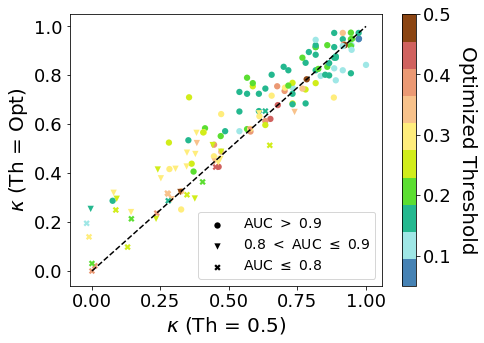

In [43]:
scatterplot_results(df_kappa, df_kappa, df_thresholds, df_auc, 
                    xax = 'standard', yax = 'GHOST', x_lab = "$\kappa$ (Th = 0.5)", y_lab = "$\kappa$ (Th = Opt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_ThOpt_vs_Th05.png", 
                    cmap = cmap3, norm = None, transparency = 1)

In [44]:
if method == 'RF':
    scatterplot_results_th_diff(df_kappa, df_kappa, df_thresholds, df_thresholds, df_auc, 
                    xax = 'GHOST', yax = 'OobOpt', x_lab = "$\kappa$ (Th = Opt)", y_lab = "$\kappa$ (Th = OobOpt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_ThOpt_vs_ThOob.png", 
                    cmap = cmap4, norm = None, transparency = 1)

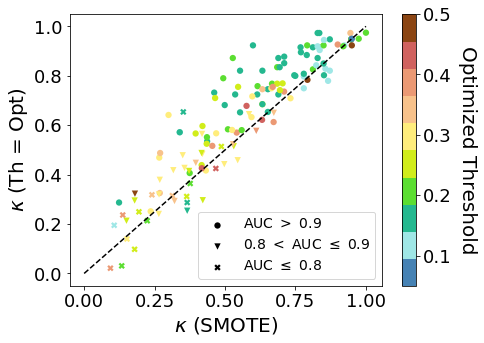

In [45]:
scatterplot_results(df_kappa, df_kappa, df_thresholds, df_auc, 
                    xax = 'SMOTE', yax = 'GHOST', x_lab = "$\kappa$ (SMOTE)", y_lab = "$\kappa$ (Th = Opt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_GHOST_vs_SMOTE.png", 
                    cmap = cmap3, norm = None, transparency = 1)

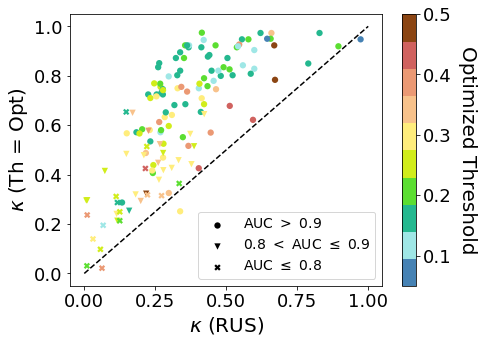

In [46]:
scatterplot_results(df_kappa, df_kappa, df_thresholds, df_auc, 
                    xax = 'RUS', yax = 'GHOST', x_lab = "$\kappa$ (RUS)", y_lab = "$\kappa$ (Th = Opt)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_GHOST_vs_RUS.png", 
                    cmap = cmap3, norm = None, transparency = 1)

### Compare to CP

In [47]:
import glob

if try_cp:
    files_preds = glob.glob(f"results/{basename}_predictions_*.csv")
    ACP_significance_level = 0.2

**Comparison between generalized threshold optimization and CP.**

For a fair comparison, in the plot below, we compare only the predictions where CP produced statistically significant results (at a ACP significance level of 0.2):

In [48]:
# calculate Cohen's kappa only on single predictions
if try_cp:
    assay_ids = []
    kappa_cp = [] 
    kappa_cp_single = [] 
    kappa_th05_single = []
    kappa_thopt_single = []
    for f1 in files_preds:
        assay_ids.append(f1.split('_')[3].replace('.csv',''))
        df_preds1 = pd.read_csv(f1)
        df_preds1['uncertain_CP'] = 0
        df_preds1['uncertain_CP'][df_preds1['p1'] >= df_preds1['p0']] = 1
        tmp = df_preds1.loc[(df_preds1[f'y_pred_{ACP_significance_level}']=="0") | (df_preds1[f'y_pred_{ACP_significance_level}']=="1")]
        print(tmp)
        kappa_cp_single.append(metrics.cohen_kappa_score(tmp.y_true,tmp.uncertain_CP))
        kappa_th05_single.append(metrics.cohen_kappa_score(tmp.y_true,tmp.Th05))
        kappa_thopt_single.append(metrics.cohen_kappa_score(tmp.y_true,tmp.ThOpt))
    df_kappa = df_kappa.reset_index().rename(columns = {'index': 'assay_id'})
    df_cp = pd.DataFrame({'assay_id': assay_ids, 'CP_single': kappa_cp_single, 'Th05_single':kappa_th05_single, 'GHOST_single': kappa_thopt_single})
    df_kappa = pd.merge(df_kappa, df_cp, how = 'left', on = 'assay_id')


In [49]:
if try_cp:
    scatterplot_results(df_kappa, df_kappa, df_thresholds.rename(columns = {'ThOpt': 'ThOpt_single'}), df_auc, 
                    xax = 'CP_single', yax = 'GHOST_single', x_lab = "$\kappa$ (CP, single pred.)", y_lab = "$\kappa$ (Th = Opt, single pred.)", 
                    errorbars = False, df_std1 = None, df_std2 = None, 
                    output_name = f"{output_folder}/scatterplot_{basename}_GHOST_vs_CP.png", 
                    cmap = cmap3, norm = None, transparency = 1)